# Início

https://www.kaggle.com/competitions/ieee-fraud-detection

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Undersample
        * Resample
        * Random UnderSampling (RUS)
        * Near Miss
        * Instance Hardness Threshold
    * Oversample
        * Resample
        * Random OverSampling (ROS)
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho
    * Algoritmos utilizados
        * Extra Trees
        * Decision Tree
    * Métricas de desempenho por threshold (0,05 a 0,50) e por técnica de balanceamento
        * F1-score positivo (iteração por iteração)
        * Wall time

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  0% | 10% |


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = 'C:/Users/arthu/Desktop/codigo_dissertacao/input/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
creditcard = pd.read_csv(f'{folder_path}creditcard.csv')

# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(creditcard)

Dataset Shape: (284807, 31)


Name   dtypes  Missing  Uniques          First Value       Second Value  \
0     Time  float64        0   124592    0.000000000000000  0.000000000000000   
1       V1  float64        0   275663   -1.359807133673800  1.191857111314860   
2       V2  float64        0   275663   -0.072781173309850  0.266150712059630   
3       V3  float64        0   275663    2.536346737969140  0.166480113353210   
4       V4  float64        0   275663    1.378155224274430  0.448154078460911   
5       V5  float64        0   275663   -0.338320769942518  0.060017649282224   
6       V6  float64        0   275663    0.462387777762292 -0.082360808815569   
7       V7  float64        0   275663    0.239598554061257 -0.078802983332311   
8       V8  float64        0   275663    0.098697901261051  0.085101654914810   
9       V9  float64        0   275663    0.363786969611213 -0.255425128109186   
10     V10  float64        0   275663    0.090794171978932 -0.166974414004614   
11     V11  float64        0   275663   -0.551599533260813  1.612726661054790   
12     V12  float64        0   275663   -0.617800855762348  1.065235311372870   
13     V13  float64        0   275663   -0.991389847235408  0.489095015896080   
14     V14  float64        0   275663   -0.311169353699879 -0.143772296441519   
15     V15  float64        0   275663    1.468176972094270  0.635558093258208   
16     V16  float64        0   275663   -0.470400525259478  0.463917041022171   
17     V17  float64        0   275663    0.207971241929242 -0.114804663102346   
18     V18  float64        0   275663    0.025790580198559 -0.183361270123994   
19     V19  float64        0   275663    0.403992960255733 -0.145783041325259   
20     V20  float64        0   275663    0.251412098239705 -0.069083135223020   
21     V21  float64        0   275663   -0.018306777944153 -0.225775248033138   
22     V22  float64        0   275663    0.277837575558899 -0.638671952771851   
23     V23  float64        0   275663   -0.110473910188767  0.101288021253234   
24     V24  float64        0   275663    0.066928074914673 -0.339846475529127   
25     V25  float64        0   275663    0.128539358273528  0.167170404418143   
26     V26  float64        0   275663   -0.189114843888824  0.125894532368176   
27     V27  float64        0   275663    0.133558376740387 -0.008983099143228   
28     V28  float64        0   275663   -0.021053053453821  0.014724169192493   
29  Amount  float64        0    32767  149.620000000000005  2.690000000000000   
30   Class    int64        0        2    0.000000000000000  0.000000000000000   

            Third Value             Entropy  
0     1.000000000000000  16.690000000000001  
1    -1.358354061598230  18.030000000000001  
2    -1.340163074736090  18.030000000000001  
3     1.773209342631190  18.030000000000001  
4     0.379779593034328  18.030000000000001  
5    -0.503198133318193  18.030000000000001  
6     1.800499380792630  18.030000000000001  
7     0.791460956450422  18.030000000000001  
8     0.247675786588991  18.030000000000001  
9    -1.514654322605830  18.030000000000001  
10    0.207642865216696  18.030000000000001  
11    0.624501459424895  18.030000000000001  
12    0.066083685268831  18.030000000000001  
13    0.717292731410831  18.030000000000001  
14   -0.165945922763554  18.030000000000001  
15    2.345864949015810  18.030000000000001  
16   -2.890083194442310  18.030000000000001  
17    1.109969378695990  18.030000000000001  
18   -0.121359313195888  18.030000000000001  
19   -2.261857095304140  18.030000000000001  
20    0.524979725224404  18.030000000000001  
21    0.247998153469754  18.030000000000001  
22    0.771679401917229  18.030000000000001  
23    0.909412262347719  18.030000000000001  
24   -0.689280956490685  18.030000000000001  
25   -0.327641833735251  18.030000000000001  
26   -0.139096571514147  18.030000000000001  
27   -0.055352794038426  18.030000000000001  
28   -0.059751840592920  18.030000000000001  
29  378.660000000000025  11.50000

In [10]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


Name   dtypes  Missing  Uniques First Value Second Value  \
0    TransactionID    int64        0   590540     2987000      2987001   
1          isFraud    int64        0        2           0            0   
2    TransactionDT    int64        0   573349       86400        86401   
3   TransactionAmt  float64        0    20902        68.5         29.0   
4        ProductCD   object        0        5           W            W   
5            card1    int64        0    13553       13926         2755   
6            card2  float64     8933      500         NaN        404.0   
7            card3  float64     1565      114       150.0        150.0   
8            card4   object     1577        4    discover   mastercard   
9            card5  float64     4259      119       142.0        102.0   
10           card6   object     1571        4      credit       credit   
11           addr1  float64    65706      332       315.0        325.0   
12           addr2  float64    65706       74        87.0         87.0   
13           dist1  float64   352271     2651        19.0          NaN   
14           dist2  float64   552913     1751         NaN          NaN   
15   P_emaildomain   object    94456       59         NaN    gmail.com   
16   R_emaildomain   object   453249       60         NaN          NaN   
17              C1  float64        0     1657         1.0          1.0   
18              C2  float64        0     1216         1.0          1.0   
19              C3  float64        0       27         0.0          0.0   
20              C4  float64        0     1260         0.0          0.0   
21              C5  float64        0      319         0.0          0.0   
22              C6  float64        0     1328         1.0          1.0   
23              C7  float64        0     1103         0.0          0.0   
24              C8  float64        0     1253         0.0          0.0   

    Third Value             Entropy  
0       2987002  19.170000000000002  
1             0   0.220000000000000  
2         86469  19.109999999999999  
3          59.0   8.350000000000000  
4             W   1.280000000000000  
5          4663   9.970000000000001  
6         490.0   6.320000000000000  
7         150.0   0.680000000000000  
8          visa   1.090000000000000  
9         166.0   2.660000000000000  
10        debit   0.820000000000000  
11        330.0   5.060000000000000  
12         87.0   0.080000000000000  
13        287.0   6.340000000000000  
14          NaN   7.420000000000000  
15  outlook.com   2.680000000000000  
16          NaN   2.760000000000000  
17          1.0   2.720000000000000  
18          1.0   2.750000000000000  
19          0.0   0.040000000000000  
20          0.0   1.120000000000000  
21          0.0   2.060000000000000  
22          1.0   2.520000000000000  
23          0.0   0.710000000000000  
24          0.0   1.250000000000000

In [11]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


Name   dtypes  Missing  Uniques         First Value  \
0    TransactionID    int64        0   506691             3663549   
1    TransactionDT    int64        0   494686            18403224   
2   TransactionAmt  float64        0    14119  31.949999999999999   
3        ProductCD   object        0        5                   W   
4            card1    int64        0    13244               10409   
5            card2  float64     8654      497               111.0   
6            card3  float64     3002      115               150.0   
7            card4   object     3086        4                visa   
8            card5  float64     4547      102               226.0   
9            card6   object     3007        3               debit   
10           addr1  float64    65609      292               170.0   
11           addr2  float64    65609       72                87.0   
12           dist1  float64   291217     1988                 1.0   
13           dist2  float64   470255     1814                 NaN   
14   P_emaildomain   object    69192       60           gmail.com   
15   R_emaildomain   object   370821       60                 NaN   
16              C1  float64        3     1174                 6.0   
17              C2  float64        3     1123                 6.0   
18              C3  float64        3       31                 0.0   
19              C4  float64        3      728                 0.0   
20              C5  float64        3      353                 3.0   
21              C6  float64        3      834                 4.0   
22              C7  float64        3      518                 0.0   
23              C8  float64        3      442                 0.0   
24              C9  float64        3      354                 6.0   

   Second Value  Third Value             Entropy  
0       3663550      3663551  18.949999999999999  
1      18403263     18403310  18.899999999999999  
2          49.0        171.0   8.080000000000000  
3             W            W   1.370000000000000  
4          4272         4476   9.949999999999999  
5         111.0        574.0   6.280000000000000  
6         150.0        150.0   0.810000000000000  
7          visa         visa   1.050000000000000  
8         226.0        226.0   2.630000000000000  
9         debit        debit   0.790000000000000  
10        299.0        472.0   5.100000000000000  
11         87.0         87.0   0.110000000000000  
12          4.0       2635.0   5.990000000000000  
13          NaN          NaN   7.900000000000000  
14      aol.com  hotmail.com   2.670000000000000  
15          NaN          NaN   2.690000000000000  
16          3.0          2.0   2.680000000000000  
17          2.0          2.0   2.760000000000000  
18          0.0          0.0   0.180000000000000  
19          0.0          0.0   1.210000000000000  
20          0.0          0.0   1.930000000000000  
21          1.0          5.0   2.470000000000000  
22          0.0          0.0   0.820000000000000  
23          0.0          0.0   1.360000000000000  
24          2.0          4.0   2.610000000000000

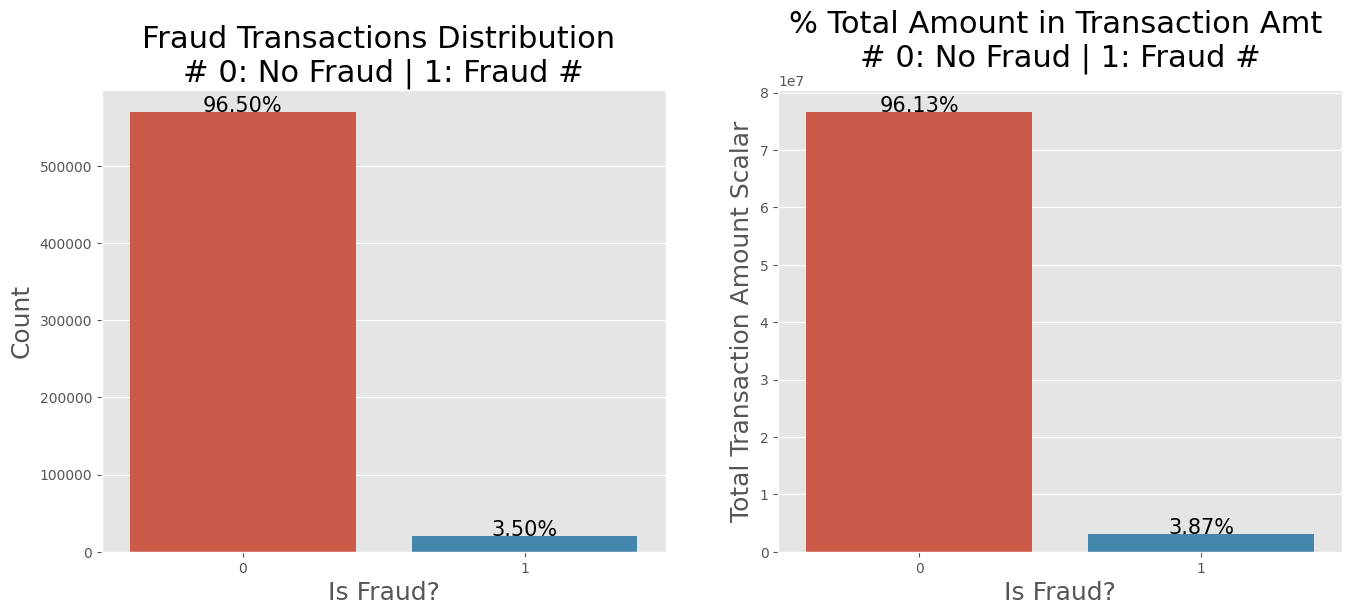

In [12]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

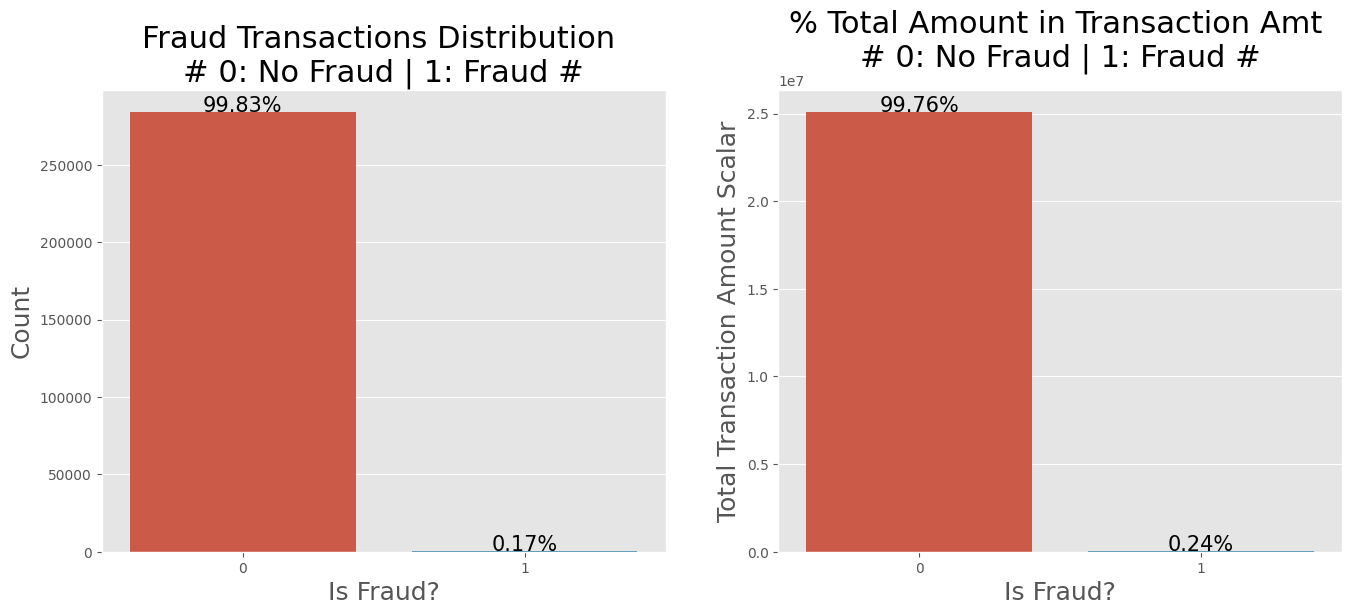

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
creditcard['Amount'] = creditcard['Amount'].astype(float)
total = len(creditcard)
total_amt = creditcard.groupby(['Class'])['Amount'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'Class', data = creditcard, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (creditcard.groupby(['Class'])['Amount'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'Class', y = 'Amount', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering (Dataset 01)

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

In [17]:
train

TransactionID  isFraud  TransactionDT       TransactionAmt ProductCD  \
0             2987000        0          86400   68.500000000000000         W   
1             2987001        0          86401   29.000000000000000         W   
2             2987002        0          86469   59.000000000000000         W   
3             2987003        0          86499   50.000000000000000         W   
4             2987004        0          86506   50.000000000000000         H   
...               ...      ...            ...                  ...       ...   
590535        3577535        0       15811047   49.000000000000000         W   
590536        3577536        0       15811049   39.500000000000000         W   
590537        3577537        0       15811079   30.949999999999999         W   
590538        3577538        0       15811088  117.000000000000000         W   
590539        3577539        0       15811131  279.949999999999989         W   

        card1  card2  card3       card4  card5  ... id_35  id_36  id_37  \
0       13926    NaN  150.0    discover  142.0  ...   NaN    NaN    NaN   
1        2755  404.0  150.0  mastercard  102.0  ...   NaN    NaN    NaN   
2        4663  490.0  150.0        visa  166.0  ...   NaN    NaN    NaN   
3       18132  567.0  150.0  mastercard  117.0  ...   NaN    NaN    NaN   
4        4497  514.0  150.0  mastercard  102.0  ...     T      F      T   
...       ...    ...    ...         ...    ...  ...   ...    ...    ...   
590535   6550    NaN  150.0        visa  226.0  ...   NaN    NaN    NaN   
590536  10444  225.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590537  12037  595.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590538   7826  481.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590539  15066  170.0  150.0  mastercard  102.0  ...   NaN    NaN    NaN   

        id_38  DeviceType                     DeviceInfo                Date  \
0         NaN         NaN                            NaN 2017-12-02 00:00:00   
1         NaN         NaN                            NaN 2017-12-02 00:00:01   
2         NaN         NaN                            NaN 2017-12-02 00:01:09   
3         NaN         NaN                            NaN 2017-12-02 00:01:39   
4           T      mobile  SAMSUNG SM-G892A Build/NRD90M 2017-12-02 00:01:46   
...       ...         ...                            ...                 ...   
590535    NaN         NaN                            NaN 2018-06-01 23:57:27   
590536    NaN         NaN                            NaN 2018-06-01 23:57:29   
590537    NaN         NaN                            NaN 2018-06-01 23:57:59   
590538    NaN         NaN                            NaN 2018-06-01 23:58:08   
590539    NaN         NaN                            NaN 2018-06-01 23:58:51   

        _Weekdays  _Hours  _Days  
0               5       0      2  
1               5       0      2  
2               5       0      2  
3               5       0      2  
4               5       0      2  
...           ...     ...    ...  
590535          4      23      1  
590536          4      23      1  
590537          4      23      1  
590538          4      23      1  
590539          4      23      1  

[590540 rows x 438 columns]

## Equalizando nomes de colunas entre bases de treino e teste

In [18]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [19]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [20]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [21]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [22]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

In [23]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

In [24]:
many_null_cols_train

['dist2',
 'R_emaildomain',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 '

In [25]:
len(many_null_cols_train)

208

In [26]:
many_null_cols_test

['dist2',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339',
 'id_03',
 'id_04',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_14',
 'id_16',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_30',
 'id_32',
 'id_33',
 'id_34',
 'DeviceInfo']

In [27]:
len(many_null_cols_test)

76

## Tratando Colunas com Valores Únicos

In [28]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [29]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [30]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

In [31]:
big_top_value_cols_train

['isFraud',
 'card3',
 'addr2',
 'dist2',
 'R_emaildomain',
 'C3',
 'C4',
 'C7',
 'C8',
 'C10',
 'C12',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V31',
 'V32',
 'V33',
 'V34',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V71',
 'V72',
 'V73',
 'V77',
 'V78',
 'V86',
 'V87',
 'V88',
 'V89',
 'V95',
 'V97',
 'V98',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V128',
 'V129',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V

In [32]:
len(big_top_value_cols_train)

330

In [33]:
big_top_value_cols_test

['card3',
 'card6',
 'addr2',
 'dist2',
 'C3',
 'C7',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V14',
 'V15',
 'V16',
 'V19',
 'V20',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V33',
 'V34',
 'V37',
 'V38',
 'V41',
 'V44',
 'V45',
 'V46',
 'V47',
 'V55',
 'V56',
 'V57',
 'V58',
 'V61',
 'V62',
 'V65',
 'V66',
 'V67',
 'V68',
 'V73',
 'V74',
 'V77',
 'V78',
 'V79',
 'V82',
 'V83',
 'V86',
 'V87',
 'V88',
 'V89',
 'V94',
 'V95',
 'V97',
 'V98',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V128',
 'V129',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V

In [34]:
len(big_top_value_cols_test)

195

## Concatenando as Colunas Desnecessárias e Removendo-as

In [35]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [36]:
cols_to_drop

['V180',
 'V16',
 'D7',
 'V192',
 'V186',
 'V293',
 'id_13',
 'V188',
 'V222',
 'V162',
 'V334',
 'V66',
 'id_17',
 'V44',
 'id_29',
 'C12',
 'V68',
 'C8',
 'V14',
 'V279',
 'V178',
 'V160',
 'V225',
 'V286',
 'V71',
 'V103',
 'V232',
 'V278',
 'V287',
 'V58',
 'V291',
 'V123',
 'id_20',
 'V126',
 'V231',
 'V95',
 'V37',
 'V336',
 'V326',
 'V315',
 'id_38',
 'V20',
 'V217',
 'V207',
 'V220',
 'V168',
 'V210',
 'V128',
 'V109',
 'V77',
 'V289',
 'D12',
 'V159',
 'V206',
 'V167',
 'V72',
 'V290',
 'V132',
 'V153',
 'V61',
 'V102',
 'V276',
 'V179',
 'V239',
 'id_15',
 'V313',
 'V211',
 'V59',
 'V270',
 'V121',
 'V230',
 'V78',
 'V113',
 'V114',
 'V166',
 'V111',
 'V294',
 'V260',
 'V21',
 'V176',
 'id_34',
 'V65',
 'V311',
 'id_27',
 'V146',
 'V25',
 'V302',
 'V119',
 'V174',
 'V67',
 'addr2',
 'V201',
 'id_22',
 'id_25',
 'V175',
 'V46',
 'V203',
 'D13',
 'V142',
 'V136',
 'id_01',
 'V89',
 'V22',
 'V172',
 'V328',
 'V214',
 'V86',
 'id_32',
 'V38',
 'id_24',
 'V161',
 'V19',
 'id_37',


In [37]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [38]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

In [39]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card4', 'card5', 'addr1', 'dist1',
       'P_emaildomain', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30', 'V35',
       'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52',
       'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85',
       'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', 'Date', '_Weekdays',
       '_Hours', '_Days'],
      dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [40]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [41]:
train.shape

(590540, 92)

In [42]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [43]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [44]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [45]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [46]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


Name   dtypes  Missing  Uniques First Value Second Value  \
0          isFraud    int64        0        2           0            0   
1   TransactionAmt  float64        0    20902        68.5         29.0   
2        ProductCD   object        0        5           W            W   
3            card1    int64        0    13553       13926         2755   
4            card2  float64     8933      500         NaN        404.0   
5            card4   object     1577        4    discover   mastercard   
6            card5  float64     4259      119       142.0        102.0   
7            addr1  float64    65706      332       315.0        325.0   
8            dist1  float64   352271     2651        19.0          NaN   
9    P_emaildomain   object    94456       59         NaN    gmail.com   
10              C1  float64        0     1657         1.0          1.0   
11              C2  float64        0     1216         1.0          1.0   
12              C5  float64        0      319         0.0          0.0   
13              C6  float64        0     1328         1.0          1.0   
14              C9  float64        0      205         1.0          0.0   
15             C11  float64        0     1476         2.0          1.0   
16             C13  float64        0     1597         1.0          1.0   
17             C14  float64        0     1108         1.0          1.0   
18              D1  float64     1269      641        14.0          0.0   
19              D2  float64   280797      641         NaN          NaN   
20              D3  float64   262878      649        13.0          NaN   
21              D4  float64   168922      808         NaN          0.0   
22              D5  float64   309841      688         NaN          NaN   
23             D10  float64    76022      818        13.0          0.0   
24             D11  float64   279287      676        13.0          NaN   
25             D15  float64    89113      859         0.0          0.0   
26              M1   object   271100        2           T          NaN   
27              M2   object   271100        2           T          NaN   
28              M3   object   271100        2           T          NaN   
29              M4   object   281444        3          M2           M0   
30              M5   object   350482        2           F            T   
31              M6   object   169360        2           T            T   
32              M7   object   346265        2         NaN          NaN   
33              M8   object   346252        2         NaN          NaN   
34              M9   object   346252        2         NaN          NaN   
35              V1  float64   279287        2         1.0          NaN   
36              V2  float64   279287        9         1.0          NaN   
37              V3  float64   279287       10         1.0          NaN   
38              V4  float64   279287        7         1.0          NaN   
39              V5  float64   279287        7         1.0          NaN   
40              V6  float64   279287       10         1.0          NaN   
41              V7  float64   279287       10         1.0          NaN   
42              V8  float64   279287        9         1.0          NaN   
43              V9  float64   279287        9         1.0          NaN   
44             V10  float64   279287        5         0.0          NaN   
45             V11  float64   279287        6         0.0          NaN   
46             V12  float64    76073        4         1.0          0.0   
47             V13  float64    76073        7         1.0          0.0   
48             V29  float64    76073        6         0.0          0.0   
49             V30  float64    76073        8         0.0          0.0   
50             V35  float64   168969        4         NaN          0.0   
51             V36  float64   168969        6         NaN          0.0   
52             V39  float64   168969       16         NaN          0.0   
53             V40

In [47]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [48]:
train = replace_missing_values(train)

In [49]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [50]:
test = replace_missing_values(test)

In [51]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [52]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [53]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [54]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [55]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [56]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [57]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [58]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [59]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [60]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [61]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [62]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [63]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [64]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [65]:
print(train.columns)

Index(['isFraud', 'TransactionAmt', 'card1', 'card2', 'card5', 'addr1',
       'dist1', 'C1', 'C2', 'C5',
       ...
       'M5_F', 'M5_T', 'M6_F', 'M6_T', 'M7_F', 'M7_T', 'M8_F', 'M8_T', 'M9_F',
       'M9_T'],
      dtype='object', length=164)


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML (Dataset 01)

In [66]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [67]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('isFraud',axis = 1)
y_train = train_split['isFraud'].astype('uint8')

X_test = test_split.drop('isFraud', axis = 1)
y_test = test_split['isFraud'].astype('uint8')

In [68]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [69]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    113975
1      4133
Name: count, dtype: int64

# Feature Engineering (Dataset 02)

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [70]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

#import datetime

#START_DATE = '2017-12-01'
#start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
#train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
#                                                             (seconds = x)))

#train['_Weekdays'] = train['Date'].dt.dayofweek
#train['_Hours'] = train['Date'].dt.hour
#train['_Days'] = train['Date'].dt.day

In [71]:
# fazendo o mesmo para base teste

#START_DATE = '2017-12-01'
#start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
#test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
#                                                             (seconds = x)))

#test['_Weekdays'] = test['Date'].dt.dayofweek
#test['_Hours'] = test['Date'].dt.hour
#test['_Days'] = test['Date'].dt.day

In [72]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
#pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [73]:
# importante para seguir com ajustes na base de forma otimizada
#train.columns.difference(test.columns)

In [74]:
# ajustar colunas de teste
#test.columns = test.columns.str.replace('-', '_')

In [75]:
# checando resultado final das diferenças
#train.columns.difference(test.columns)

## Tratando Colunas com Valores Faltantes

In [76]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [77]:
# lista completa de colunas com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [78]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_creditcard = [col for col in creditcard.columns if creditcard[col].isnull().sum() / creditcard.shape[0] > 0.75]
#many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [79]:
# checando se existem colunas apenas com um valor
one_value_cols_creditcard = [col for col in creditcard.columns if creditcard[col].nunique() <= 1]
#one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_creditcard)} columns in creditcard dataset with one unique value.')
#print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in creditcard dataset with one unique value.


In [80]:
# identificando colunas com valor único
one_value_cols_creditcard = [col for col in creditcard.columns if creditcard[col].nunique() <= 1]
#one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [81]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_creditcard = [col for col in creditcard.columns if \
                            creditcard[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
#big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
#                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [82]:
cols_to_drop = list(set(many_null_cols_creditcard + big_top_value_cols_creditcard + \
                        one_value_cols_creditcard))# + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'Class' da remoção
cols_to_drop.remove('Class')
len(cols_to_drop)

0

In [83]:
creditcard = creditcard.drop(cols_to_drop, axis=1)
#test = test.drop(cols_to_drop, axis=1)

In [84]:
# checando novamente a diferença entre colunas das bases treino e teste
#train.columns.difference(test.columns)

## Identificando Linhas com Valores Faltantes e Removendo-as

In [85]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * creditcard.shape[1] + 1)
creditcard = creditcard.dropna(axis = 0, thresh = min_count)

#min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
#test = test.dropna(axis = 0, thresh = min_count)

In [86]:
creditcard.shape

(284807, 31)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [87]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
#train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
#test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [88]:
# checando por diferenças de colunas entre as bases de treino e teste
#train.columns.difference(test.columns)

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [89]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [90]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(creditcard)

Dataset Shape: (284807, 31)


Name   dtypes  Missing  Uniques          First Value       Second Value  \
0     Time  float64        0   124592    0.000000000000000  0.000000000000000   
1       V1  float64        0   275663   -1.359807133673800  1.191857111314860   
2       V2  float64        0   275663   -0.072781173309850  0.266150712059630   
3       V3  float64        0   275663    2.536346737969140  0.166480113353210   
4       V4  float64        0   275663    1.378155224274430  0.448154078460911   
5       V5  float64        0   275663   -0.338320769942518  0.060017649282224   
6       V6  float64        0   275663    0.462387777762292 -0.082360808815569   
7       V7  float64        0   275663    0.239598554061257 -0.078802983332311   
8       V8  float64        0   275663    0.098697901261051  0.085101654914810   
9       V9  float64        0   275663    0.363786969611213 -0.255425128109186   
10     V10  float64        0   275663    0.090794171978932 -0.166974414004614   
11     V11  float64        0   275663   -0.551599533260813  1.612726661054790   
12     V12  float64        0   275663   -0.617800855762348  1.065235311372870   
13     V13  float64        0   275663   -0.991389847235408  0.489095015896080   
14     V14  float64        0   275663   -0.311169353699879 -0.143772296441519   
15     V15  float64        0   275663    1.468176972094270  0.635558093258208   
16     V16  float64        0   275663   -0.470400525259478  0.463917041022171   
17     V17  float64        0   275663    0.207971241929242 -0.114804663102346   
18     V18  float64        0   275663    0.025790580198559 -0.183361270123994   
19     V19  float64        0   275663    0.403992960255733 -0.145783041325259   
20     V20  float64        0   275663    0.251412098239705 -0.069083135223020   
21     V21  float64        0   275663   -0.018306777944153 -0.225775248033138   
22     V22  float64        0   275663    0.277837575558899 -0.638671952771851   
23     V23  float64        0   275663   -0.110473910188767  0.101288021253234   
24     V24  float64        0   275663    0.066928074914673 -0.339846475529127   
25     V25  float64        0   275663    0.128539358273528  0.167170404418143   
26     V26  float64        0   275663   -0.189114843888824  0.125894532368176   
27     V27  float64        0   275663    0.133558376740387 -0.008983099143228   
28     V28  float64        0   275663   -0.021053053453821  0.014724169192493   
29  Amount  float64        0    32767  149.620000000000005  2.690000000000000   
30   Class    int64        0        2    0.000000000000000  0.000000000000000   

            Third Value             Entropy  
0     1.000000000000000  16.690000000000001  
1    -1.358354061598230  18.030000000000001  
2    -1.340163074736090  18.030000000000001  
3     1.773209342631190  18.030000000000001  
4     0.379779593034328  18.030000000000001  
5    -0.503198133318193  18.030000000000001  
6     1.800499380792630  18.030000000000001  
7     0.791460956450422  18.030000000000001  
8     0.247675786588991  18.030000000000001  
9    -1.514654322605830  18.030000000000001  
10    0.207642865216696  18.030000000000001  
11    0.624501459424895  18.030000000000001  
12    0.066083685268831  18.030000000000001  
13    0.717292731410831  18.030000000000001  
14   -0.165945922763554  18.030000000000001  
15    2.345864949015810  18.030000000000001  
16   -2.890083194442310  18.030000000000001  
17    1.109969378695990  18.030000000000001  
18   -0.121359313195888  18.030000000000001  
19   -2.261857095304140  18.030000000000001  
20    0.524979725224404  18.030000000000001  
21    0.247998153469754  18.030000000000001  
22    0.771679401917229  18.030000000000001  
23    0.909412262347719  18.030000000000001  
24   -0.689280956490685  18.030000000000001  
25   -0.327641833735251  18.030000000000001  
26   -0.139096571514147  18.030000000000001  
27   -0.055352794038426  18.030000000000001  
28   -0.059751840592920  18.030000000000001  
29  378.660000000000025  11.50000

In [91]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [92]:
creditcard = replace_missing_values(creditcard)

In [93]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [94]:
#test = replace_missing_values(test)

In [95]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [96]:
# identificando os atributos classificados como "object" para codificação
object_columns = creditcard.select_dtypes(include = "object").columns
print(object_columns)

Index([], dtype='object')


In [97]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
#object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
#       'M5', 'M6', 'M7', 'M8', 'M9']

In [98]:
# Aplicando One-Hot Encoding em várias colunas
#creditcard = pd.get_dummies(creditcard, columns = object_columns_treated)
#test = pd.get_dummies(test, columns = object_columns_treated)

In [99]:
# checando se ainda existem colunas "object"
checking_remaining_objects_creditcard = resumetable(creditcard)[['Name', 'dtypes']]
checking_remaining_objects_creditcard[checking_remaining_objects_creditcard['dtypes'] == 'object']

Dataset Shape: (284807, 31)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [100]:
# checando se ainda existem colunas "object"
#checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
#checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

In [101]:
# checando se ainda existem colunas categóricas
cols = creditcard.columns
num_cols = creditcard._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [102]:
# checando se ainda existem colunas categóricas
#cols = test.columns
#num_cols = test._get_numeric_data().columns
#cat_cols = list(set(cols) - set(num_cols))
#cat_cols

In [103]:
# checando por diferenças entre as colunas de treino e teste
#train.columns.difference(test.columns)

## Checando colunas com valores negativos para métodos de seleção de atributos

In [104]:
columns_negative_values = creditcard.columns[creditcard.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')


In [105]:
# separando as columas com valores negativos
negative_columns_treated = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

In [106]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in creditcard.columns:
        le.fit(list(creditcard[col].astype(str).values))# + list(test[col].astype(str).values))
        creditcard[col] = le.fit_transform(list(creditcard[col].astype(str).values))
        #test[col] = le.fit_transform(list(test[col].astype(str).values))

In [107]:
# última checagem de valores negativos
columns_negative_values = creditcard.columns[creditcard.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML (Dataset 02)

In [108]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
#train_split, test_split = train_test_split(creditcard, test_size=0.2, random_state=42, stratify = creditcard.Class)

In [109]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
#X_train = train_split.drop('Class',axis = 1)
#y_train = train_split['Class'].astype('uint8')

#X_test = test_split.drop('Class', axis = 1)
#y_test = test_split['Class'].astype('uint8')

In [110]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
#print("Distribuição das classes no conjunto de treinamento:")
#print(y_train.value_counts())

#print("\nDistribuição das classes no conjunto de teste:")
#print(y_test.value_counts())

In [111]:
# combinando as classes minoritária com a majoritária subamostrada
#test_split = pd.concat([X_test, y_test], \
#                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#test_split.Class.value_counts()

# Balanceamento de Classes (Datasets 01 e 02)

### Undersample com Resample

In [112]:
%%time

from sklearn.utils import resample

#not_fraud = train_split[train_split.Class == 0]
#fraud = train_split[train_split.Class == 1]

not_fraud = train_split[train_split.isFraud == 0]
fraud = train_split[train_split.isFraud == 1]


not_fraud_undersampled = resample(not_fraud,
                                  replace = False, # sample without replacement
                                  n_samples = len(fraud), # match minority n
                                  random_state = 0)



# combinando as classes minoritária com majoritária subamostrada 
undersample_with_resample = pd.concat([not_fraud_undersampled, fraud])

X_train_undersample_with_resample = undersample_with_resample.drop('isFraud',axis = 1)
y_train_undersample_with_resample = undersample_with_resample['isFraud'].astype('uint8')

#X_train_undersample_with_resample = undersample_with_resample.drop('Class',axis = 1)
#y_train_undersample_with_resample = undersample_with_resample['Class'].astype('uint8')

# contando as classes minoritária e majoritária
undersample_with_resample.isFraud.value_counts()
#undersample_with_resample.Class.value_counts()

Wall time: 205 ms


isFraud
0    16530
1    16530
Name: count, dtype: int64

### Undersample com Random Undersampling (RUS)

In [113]:
%%time

import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_train_undersample_with_rus, y_train_undersample_with_rus = rus.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada 
undersample_with_rus = pd.concat([X_train_undersample_with_rus, y_train_undersample_with_rus], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_rus.isFraud.value_counts()
#undersample_with_rus.Class.value_counts()

Wall time: 901 ms


isFraud
0    16530
1    16530
Name: count, dtype: int64

### Undersample com Near Miss

In [114]:
%%time

from imblearn.under_sampling import NearMiss

nm = NearMiss()

X_train_undersample_with_near_miss, y_train_undersample_with_near_miss = nm.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_near_miss = pd.concat([X_train_undersample_with_near_miss, y_train_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_near_miss.isFraud.value_counts()
#undersample_with_near_miss.Class.value_counts()

Wall time: 24 s


isFraud
0    16530
1    16530
Name: count, dtype: int64

### Undersample com One Sided Selection

In [115]:
%%time

from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection(random_state=0)

X_train_undersample_with_oss, y_train_undersample_with_oss = oss.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_oss = pd.concat([X_train_undersample_with_oss, \
                                        y_train_undersample_with_oss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_oss.Class.value_counts()

NameError: name 'undersample_with_iht' is not defined

### Undersample com Instance Hardness Threshold

In [116]:
%%time

from imblearn.under_sampling import InstanceHardnessThreshold

iht = InstanceHardnessThreshold(random_state=0)

X_train_undersample_with_iht, y_train_undersample_with_iht = iht.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_iht = pd.concat([X_train_undersample_with_iht, \
                                        y_train_undersample_with_iht], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_iht.Class.value_counts()

Wall time: 11min 17s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com Neighbourhood Cleaning Rule

In [117]:
%%time

from imblearn.under_sampling import NeighbourhoodCleaningRule

ncl = NeighbourhoodCleaningRule()

X_train_undersample_with_ncl, y_train_undersample_with_ncl = ncl.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_ncl = pd.concat([X_train_undersample_with_ncl, \
                                        y_train_undersample_with_ncl], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_ncl.Class.value_counts()

Wall time: 11min 24s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com Edited Nearest Neighbours

In [118]:
%%time

from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()

X_train_undersample_with_enn, y_train_undersample_with_enn = enn.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_enn = pd.concat([X_train_undersample_with_enn, \
                                        y_train_undersample_with_enn], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_enn.Class.value_counts()

Wall time: 10min 45s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com Tomek Links

In [119]:
%%time

from imblearn.under_sampling import TomekLinks

tl = TomekLinks()

X_train_undersample_with_tl, y_train_undersample_with_tl = tl.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_tl = pd.concat([X_train_undersample_with_tl, \
                                        y_train_undersample_with_tl], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_tl.Class.value_counts()

Wall time: 11min 20s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com All KNN

In [120]:
%%time

from imblearn.under_sampling import AllKNN

allknn = AllKNN()

X_train_undersample_with_allknn, y_train_undersample_with_allknn = allknn.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_allknn = pd.concat([X_train_undersample_with_allknn, \
                                        y_train_undersample_with_allknn], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_allknn.Class.value_counts()

Wall time: 31min 4s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com Repeated Edited Nearest Neighbours

%%time

from imblearn.under_sampling import RepeatedEditedNearestNeighbours

renn = RepeatedEditedNearestNeighbours()

X_train_undersample_with_renn, y_train_undersample_with_renn = renn.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_renn = pd.concat([X_train_undersample_with_renn, \
                                        y_train_undersample_with_renn], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_renn.Class.value_counts()

### Oversample com Resample

In [121]:
%%time

fraud_upsampled = resample(fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(not_fraud), # match number in majority class
                           random_state = 27)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_resample = pd.concat([not_fraud, fraud_upsampled])

X_train_oversample_with_resample = oversample_with_resample.drop('isFraud',axis = 1)
y_train_oversample_with_resample = oversample_with_resample['isFraud'].astype('uint8')

#X_train_oversample_with_resample = oversample_with_resample.drop('Class',axis = 1)
#y_train_oversample_with_resample = oversample_with_resample['Class'].astype('uint8')

# contando as classes minoritária e majoritária
oversample_with_resample.isFraud.value_counts()
#oversample_with_resample.Class.value_counts()

Wall time: 955 ms


isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversample com Random Oversampling (ROS)

In [122]:
%%time

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_oversample_with_ros, y_train_oversample_with_ros = ros.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_ros = pd.concat([X_train_oversample_with_ros, y_train_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
oversample_with_ros.isFraud.value_counts()
#oversample_with_ros.Class.value_counts()

Wall time: 6.77 s


isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com SMOTE

In [123]:
%%time

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()
#train_oversample_with_smote.Class.value_counts()

Wall time: 6.9 s
Parser   : 312 ms


isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversample com Borderline SMOTE

In [124]:
%%time

from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42)

X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                   y_train_oversample_with_borderline_smote], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
oversample_with_borderline_smote.isFraud.value_counts()
#oversample_with_borderline_smote.Class.value_counts()

Wall time: 31.5 s


isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [125]:
%%time

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)

X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()
#train_oversample_with_adasyn.Class.value_counts()

Wall time: 28.9 s


isFraud
1    456567
0    455902
Name: count, dtype: int64

In [126]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 5.6e+03 s


# Redução de Dimensionalidade

In [127]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

## Sem Balanceamento

In [128]:
# QUI QUADRADO
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_chi2 = SelectKBest(chi2, k = 25)
new_100_chi2 = model_100_chi2.fit(X_train, y_train)
X_train_100_chi2 = new_100_chi2.transform(X_train)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train.iloc[:, cols]

cols_100_chi2 = features_df_new_100_chi2.columns

In [129]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train, y_train)
X_train_100_anova = new_100_chi2.transform(X_train)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train.iloc[:, cols]

cols_100_anova = features_df_new_100_anova.columns

## Undersample com Resample

In [130]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 25)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)
X_train_undersample_with_resample_100_chi2 = new_100_chi2.transform(X_train_undersample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_resample.iloc[:, cols]

undersample_with_resample_100_chi2 = features_df_new_100_chi2.columns

In [131]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)
X_train_undersample_with_resample_100_anova = new_100_chi2.transform(X_train_undersample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_resample.iloc[:, cols]

undersample_with_resample_cols_100_anova = features_df_new_100_anova.columns

## Undersample com Random Undersampling (RUS)

In [132]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)
X_train_undersample_with_rus_100_chi2 = new_100_chi2.transform(X_train_undersample_with_rus)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_rus.iloc[:, cols]

undersample_with_rus_100_chi2 = features_df_new_100_chi2.columns

In [133]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)
X_train_undersample_with_rus_100_anova = new_100_chi2.transform(X_train_undersample_with_rus)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_rus.iloc[:, cols]

undersample_with_rus_cols_100_anova = features_df_new_100_anova.columns

## Undersample com Near Miss

In [134]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_chi2 = new_100_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

undersample_with_near_miss_100_chi2 = features_df_new_100_chi2.columns

In [135]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_anova = new_100_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_near_miss.iloc[:, cols]

undersample_with_near_miss_cols_100_anova = features_df_new_100_anova.columns

## Undersample com Instance Hardness Threshold

In [136]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)
X_train_undersample_with_iht_100_chi2 = new_100_chi2.transform(X_train_undersample_with_iht)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_iht.iloc[:, cols]

undersample_with_iht_100_chi2 = features_df_new_100_chi2.columns

In [137]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)
X_train_undersample_with_iht_100_anova = new_100_chi2.transform(X_train_undersample_with_iht)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_iht.iloc[:, cols]

undersample_with_iht_cols_100_anova = features_df_new_100_anova.columns

## Undersampling com Neighbourhood Cleaning Rule

In [138]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)
X_train_undersample_with_ncl_100_chi2 = new_100_chi2.transform(X_train_undersample_with_ncl)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_ncl.iloc[:, cols]

undersample_with_ncl_100_chi2 = features_df_new_100_chi2.columns

In [139]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)
X_train_undersample_with_ncl_100_anova = new_100_chi2.transform(X_train_undersample_with_ncl)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_ncl.iloc[:, cols]

undersample_with_ncl_cols_100_anova = features_df_new_100_anova.columns

## Undersampling com Edited Nearest Neighbours

In [140]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)
X_train_undersample_with_enn_100_chi2 = new_100_chi2.transform(X_train_undersample_with_enn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_enn.iloc[:, cols]

undersample_with_enn_100_chi2 = features_df_new_100_chi2.columns

In [141]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)
X_train_undersample_with_enn_100_anova = new_100_chi2.transform(X_train_undersample_with_enn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_enn.iloc[:, cols]

undersample_with_enn_cols_100_anova = features_df_new_100_anova.columns

## Undersampling com Tomek Links

In [142]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)
X_train_undersample_with_tl_100_chi2 = new_100_chi2.transform(X_train_undersample_with_tl)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_tl.iloc[:, cols]

undersample_with_tl_100_chi2 = features_df_new_100_chi2.columns

In [143]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)
X_train_undersample_with_tl_100_anova = new_100_chi2.transform(X_train_undersample_with_tl)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_tl.iloc[:, cols]

undersample_with_tl_cols_100_anova = features_df_new_100_anova.columns

## Undersampling com All KNN

In [144]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)
X_train_undersample_with_allknn_100_chi2 = new_100_chi2.transform(X_train_undersample_with_allknn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_allknn.iloc[:, cols]

undersample_with_allknn_100_chi2 = features_df_new_100_chi2.columns

In [145]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)
X_train_undersample_with_allknn_100_anova = new_100_chi2.transform(X_train_undersample_with_allknn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_allknn.iloc[:, cols]

undersample_with_allknn_cols_100_anova = features_df_new_100_anova.columns

## Undersampling com Repeated Edited Nearest Neighbours

# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_renn, y_train_undersample_with_renn)
X_train_undersample_with_renn_100_chi2 = new_100_chi2.transform(X_train_undersample_with_renn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_renn.iloc[:, cols]

undersample_with_renn_100_chi2 = features_df_new_100_chi2.columns

# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_renn, y_train_undersample_with_renn)
X_train_undersample_with_renn_100_anova = new_100_chi2.transform(X_train_undersample_with_renn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_renn.iloc[:, cols]

undersample_with_renn_cols_100_anova = features_df_new_100_anova.columns

## Oversample com Resample

In [146]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_chi2 = new_100_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_resample.iloc[:, cols]

oversample_with_resample_100_chi2 = features_df_new_100_chi2.columns

In [147]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_anova = new_100_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_resample.iloc[:, cols]

oversample_with_resample_cols_100_anova = features_df_new_100_anova.columns

## Oversample com Random Oversampling (ROS)

In [148]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_chi2 = new_100_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_ros.iloc[:, cols]

oversample_with_ros_100_chi2 = features_df_new_100_chi2.columns

In [149]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_anova = new_100_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_ros.iloc[:, cols]

oversample_with_ros_cols_100_anova = features_df_new_100_anova.columns

## Oversampling com SMOTE

In [150]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

oversample_with_smote_100_chi2 = features_df_new_100_chi2.columns

In [151]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_anova = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_smote.iloc[:, cols]

oversample_with_smote_cols_100_anova = features_df_new_100_anova.columns

## Oversample com Borderline SMOTE

In [152]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

oversample_with_borderline_smote_100_chi2 = features_df_new_100_chi2.columns

In [153]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_anova = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

oversample_with_borderline_smote_cols_100_anova = features_df_new_100_anova.columns

## Oversampling com AdaSyn

In [154]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

oversample_with_adasyn_100_chi2 = features_df_new_100_chi2.columns

In [155]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_anova = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_adasyn.iloc[:, cols]

oversample_with_adasyn_cols_100_anova = features_df_new_100_anova.columns

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [156]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [158]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [159]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

## Sem Balanceamento Nem Limiares

### Top 100 Qui-Quadrado

In [160]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 27s


0.5833714721586576

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

In [162]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 8.44 s


0.4981676321078142

In [163]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

0:	learn: 0.5480650	total: 384ms	remaining: 1.54s
1:	learn: 0.4314610	total: 505ms	remaining: 757ms
2:	learn: 0.3491888	total: 553ms	remaining: 369ms
3:	learn: 0.2852046	total: 598ms	remaining: 149ms
4:	learn: 0.2430361	total: 644ms	remaining: 0us
Wall time: 5 s


0.19199311235471372

In [164]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 44.9 s


0.14064590101280336

In [165]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 59.7 s


0.2748212867355044

In [166]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 3.99 s
Compiler : 125 ms


0.000964785335262904

In [167]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 20s


0.38704479535932973

In [168]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 332 ms


0.18450989558983946

### Top 100 ANOVA

In [169]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 23s


0.002387774594078319

In [170]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 17.1 s


0.0

In [171]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 8.35 s


0.04100581896098986

In [172]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

0:	learn: 0.5480650	total: 42.5ms	remaining: 170ms
1:	learn: 0.4314610	total: 97.5ms	remaining: 146ms
2:	learn: 0.3491888	total: 142ms	remaining: 94.6ms
3:	learn: 0.2852046	total: 182ms	remaining: 45.6ms
4:	learn: 0.2430361	total: 226ms	remaining: 0us
Wall time: 937 ms


0.0

In [173]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 44.9 s


0.12528544096772204

In [174]:
# Ajuste e transforme o conjunto de treinamento
X_train_100_anova_scaled = scaler.fit_transform(X_train_100_anova)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_anova])

# Treine o modelo e calcule o F1-Score positivo
clf_ada.fit(X_train_100_anova_scaled, y_train)
previsoes = clf_ada.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

Wall time: 59.5 s


0.05972681524083393

In [175]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 3.71 s


0.05964715765891908

In [176]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 20s


0.0

In [177]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 270 ms


0.08705612829324168

### Todos os atributos

In [178]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 2min 47s


0.6465901848311026

In [179]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 17.6 s


0.0

In [180]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 8.31 s


0.4981676321078142

In [181]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

0:	learn: 0.5480650	total: 59ms	remaining: 236ms
1:	learn: 0.4314610	total: 99.3ms	remaining: 149ms
2:	learn: 0.3491888	total: 144ms	remaining: 95.9ms
3:	learn: 0.2852046	total: 230ms	remaining: 57.4ms
4:	learn: 0.2430361	total: 274ms	remaining: 0us
Wall time: 1.03 s


0.19199311235471372

In [182]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 44.7 s


0.14064590101280336

In [183]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 59.6 s


0.2748212867355044

In [184]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 3.73 s


0.000964785335262904

In [185]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 19s


0.38704479535932973

In [186]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 294 ms


0.18450989558983946

## Validação Cruzada para Diferentes Limiares

### Reinicializando os classificadores

In [187]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [188]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 25s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.32998100668688657]                   NaN                   NaN   
1                     NaN  [0.4757744177109207]                   NaN   
2                     NaN                   NaN  [0.5563189589012849]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

         Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3   [0.598853769543817]                   NaN                   NaN   
4                   NaN  [0.6136569007589036]                   NaN   
5                   NaN                   NaN  [0.6152457390046924]   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

        Threshold: 0.35       Threshold: 0.4       Threshold: 0.45  \
0                   NaN                  NaN                   NaN   
1                   NaN                  NaN                   NaN   
2                   NaN                  NaN                   NaN   
3                   NaN                  NaN                   NaN   
4                   NaN                  NaN                   NaN   
5                   NaN                  NaN                   NaN   
6   [0.613633122507459]                  NaN                   NaN   
7                   NaN  [0.605567429839265]                   NaN   
8                   NaN                  NaN  [0.5937266589663961]   
9                   NaN                  NaN                   NaN   
10                  NaN                  NaN                   NaN   
11                  NaN                  NaN                   NaN   
12                  NaN                  NaN                   NaN   
13                  NaN                  NaN                   NaN   
14                  NaN                  NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7      

In [189]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 29.3 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.25584224032705816]                    NaN                    NaN   
1                     NaN  [0.33287129642914415]                    NaN   
2                     NaN                    NaN  [0.28503532946201754]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.21222708702643497]                    NaN                    NaN   
4                     NaN  [0.09617272806483397]                    NaN   
5                     NaN                    NaN  [0.07545340004441665]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35          Threshold: 0.4 Threshold: 0.45  \
0                     NaN                     NaN             NaN   
1                     NaN                     NaN             NaN   
2                     NaN                     NaN             NaN   
3                     NaN                     NaN             NaN   
4                     NaN                     NaN             NaN   
5                     NaN                     NaN             NaN   
6   [0.03791673418947579]                     NaN             NaN   
7                     NaN  [0.000966183574879227]             NaN   
8                     NaN                     NaN           [0.0]   
9                     NaN                     NaN             NaN   
10                    NaN                     NaN             NaN   
11                    NaN                     NaN             NaN   
12                    NaN                     NaN             NaN   
13                    NaN                     NaN             NaN   
14                    NaN                     NaN             NaN   

   Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0             NaN             NaN            NaN             NaN   
1             NaN             NaN            NaN             NaN   
2             NaN             NaN            NaN             NaN   
3             NaN             NaN            NaN             NaN   
4             NaN             NaN            NaN             NaN   
5             NaN             NaN            NaN             NaN   
6             NaN          

In [190]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 13.7 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.472970896921127]                   NaN                   NaN   
1                   NaN  [0.4810701056489949]                   NaN   
2                   NaN                   NaN  [0.4867882101728795]   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.4887983018942398]                    NaN                    NaN   
4                    NaN  [0.49089594994302155]                    NaN   
5                    NaN                    NaN  [0.49300453561828694]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4948435012749387]                   NaN                   NaN   
7                    NaN  [0.4948435012749387]                   NaN   
8                    NaN                   NaN  [0.4948435012749387]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN     

In [191]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5480650	total: 43ms	remaining: 172ms
1:	learn: 0.4314610	total: 83.6ms	remaining: 125ms
2:	learn: 0.3491888	total: 128ms	remaining: 85.4ms
3:	learn: 0.2852046	total: 169ms	remaining: 42.2ms
4:	learn: 0.2430361	total: 212ms	remaining: 0us
Wall time: 6.16 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.07212637475965675]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3   [0.19321015101752292]                   NaN                   NaN   
4                     NaN  [0.3785406873107226]                   NaN   
5                     NaN                   NaN  [0.3732042668843474]   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.33562592837169164]                    NaN                    NaN   
7                     NaN  [0.24289883573111587]                    NaN   
8                     NaN                    NaN  [0.21978204307048924]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    Na

In [192]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 50.1 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.14064018173912468]                    NaN                    NaN   
1                     NaN  [0.14064018173912468]                    NaN   
2                     NaN                    NaN  [0.14064018173912468]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.14064018173912468]                    NaN                    NaN   
4                     NaN  [0.14064018173912468]                    NaN   
5                     NaN                    NaN  [0.14064018173912468]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.14064018173912468]                    NaN                    NaN   
7                     NaN  [0.14064018173912468]                    NaN   
8                     NaN                    NaN  [0.14064018173912468]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [193]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 25s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                    NaN             NaN            NaN             NaN   
1                    NaN             NaN            NaN             NaN   
2                    NaN             NaN            NaN             NaN   
3                    NaN             NaN            NaN             NaN   
4                    NaN        

In [194]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8.47 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.09818923102305765]                    NaN                    NaN   
1                     NaN  [0.10206254467686779]                    NaN   
2                     NaN                    NaN  [0.08567600493242908]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06261478048435153]                    NaN                    NaN   
4                     NaN  [0.04147500683543718]                    NaN   
5                     NaN                    NaN  [0.02783304746650478]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35          Threshold: 0.4          Threshold: 0.45  \
0                     NaN                     NaN                      NaN   
1                     NaN                     NaN                      NaN   
2                     NaN                     NaN                      NaN   
3                     NaN                     NaN                      NaN   
4                     NaN                     NaN                      NaN   
5                     NaN                     NaN                      NaN   
6   [0.01300089763572529]                     NaN                      NaN   
7                     NaN  [0.004747313311802095]                      NaN   
8                     NaN                     NaN  [0.0024038627827467395]   
9                     NaN                     NaN                      NaN   
10                    NaN                     NaN                      NaN   
11                    NaN                     NaN                      NaN   
12                    NaN                     NaN                      NaN   
13                    NaN                     NaN                      NaN   
14                    NaN                     NaN                      NaN   

             Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                       NaN             NaN            NaN             NaN   
1                       NaN             NaN            NaN             NaN   
2                       NaN             NaN            NaN             NaN   
3                       NaN             NaN    

In [195]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 19min 36s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.3375182404669292]                   NaN                   NaN   
1                    NaN  [0.3375182404669292]                   NaN   
2                    NaN                   NaN  [0.3375182404669292]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3375182404669292]                   NaN                   NaN   
4                    NaN  [0.3375182404669292]                   NaN   
5                    NaN                   NaN  [0.3375182404669292]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.38687600417874746]                    NaN                    NaN   
7                     NaN  [0.38687600417874746]                    NaN   
8                     NaN                    NaN  [0.38687600417874746]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN    

In [196]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.66 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.09241019973743617]                    NaN                   NaN   
1                     NaN  [0.09607347519660357]                   NaN   
2                     NaN                    NaN  [0.1030105096014515]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.1441035240218827]                    NaN                    NaN   
4                    NaN  [0.17730319417954954]                    NaN   
5                    NaN                    NaN  [0.18228921150795593]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18332753930212622]                    NaN                    NaN   
7                     NaN  [0.18462594426721426]                    NaN   
8                     NaN                    NaN  [0.18480075748701622]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                

### Top 100 ANOVA

In [197]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 47s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.07388422537714094]                   NaN                    NaN   
1                     NaN  [0.1148928405032819]                    NaN   
2                     NaN                   NaN  [0.12131232222491947]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11601972441683037]                    NaN                    NaN   
4                     NaN  [0.09412658931879848]                    NaN   
5                     NaN                    NaN  [0.07013479812455156]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.35          Threshold: 0.4         Threshold: 0.45  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                      NaN                     NaN                     NaN   
5                      NaN                     NaN                     NaN   
6   [0.024930914225396502]                     NaN                     NaN   
7                      NaN  [0.016900614086153894]                     NaN   
8                      NaN                     NaN  [0.004704985141526294]   
9                      NaN                     NaN                     NaN   
10                     NaN                     NaN                     NaN   
11                     NaN                     NaN                     NaN   
12                     NaN                     NaN                     NaN   
13                     NaN                     NaN                     NaN   
14                     NaN                     NaN                     NaN   

             Threshold: 0.5           Threshold: 0.55 Threshold: 0.6  \
0                       NaN                       NaN            NaN   
1                       NaN                       NaN            NaN   
2                       NaN                       NaN            NaN   
3                       NaN                       NaN            NaN   
4              

In [198]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 28.1 s


Threshold: 0.05        Threshold: 0.1         Threshold: 0.15  \
0   [0.06663787470085118]                   NaN                     NaN   
1                     NaN  [0.1281409342186059]                     NaN   
2                     NaN                   NaN  [0.004731621557886917]   
3                     NaN                   NaN                     NaN   
4                     NaN                   NaN                     NaN   
5                     NaN                   NaN                     NaN   
6                     NaN                   NaN                     NaN   
7                     NaN                   NaN                     NaN   
8                     NaN                   NaN                     NaN   
9                     NaN                   NaN                     NaN   
10                    NaN                   NaN                     NaN   
11                    NaN                   NaN                     NaN   
12                    NaN                   NaN                     NaN   
13                    NaN                   NaN                     NaN   
14                    NaN                   NaN                     NaN   

             Threshold: 0.2 Threshold: 0.25 Threshold: 0.3 Threshold: 0.35  \
0                       NaN             NaN            NaN             NaN   
1                       NaN             NaN            NaN             NaN   
2                       NaN             NaN            NaN             NaN   
3   [0.0009626969416126043]             NaN            NaN             NaN   
4                       NaN           [0.0]            NaN             NaN   
5                       NaN             NaN          [0.0]             NaN   
6                       NaN             NaN            NaN           [0.0]   
7                       NaN             NaN            NaN             NaN   
8                       NaN             NaN            NaN             NaN   
9                       NaN             NaN            NaN             NaN   
10                      NaN             NaN            NaN             NaN   
11                      NaN             NaN            NaN             NaN   
12                      NaN             NaN            NaN             NaN   
13                      NaN             NaN            NaN             NaN   
14                      NaN             NaN            NaN             NaN   

   Threshold: 0.4 Threshold: 0.45 Threshold: 0.5 Threshold: 0.55  \
0             NaN             NaN            NaN             NaN   
1             NaN             NaN            NaN             NaN   
2             NaN             NaN            NaN             NaN   
3             NaN             NaN            NaN             NaN   
4             NaN             NaN            NaN             NaN   
5             NaN             NaN            NaN             NaN   
6             NaN             NaN            NaN             NaN   
7           [0.0]             NaN            NaN             NaN   
8             NaN           [0.0]            NaN             NaN   
9             NaN             NaN          [0.0]             NaN   
10            NaN             NaN            NaN           [0.0]   
11            NaN             NaN            NaN             NaN   
12            NaN             NaN            NaN             NaN   
13            NaN             NaN            NaN             NaN   
14            NaN             NaN            NaN             NaN   

   Threshold: 0.6 Threshold: 0.65 Threshold: 0.7 Threshold: 0.75  
0             NaN             NaN            NaN             NaN  
1             NaN             NaN            NaN             NaN  
2             NaN             NaN            NaN             NaN  
3             NaN             NaN            NaN             NaN  
4             NaN             NaN            NaN             NaN  
5             NaN             NaN            NaN             NaN  
6 

In [199]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 12.8 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.04100458734266636]                    NaN                    NaN   
1                     NaN  [0.04100458734266636]                    NaN   
2                     NaN                    NaN  [0.04100458734266636]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.04100458734266636]                    NaN                    NaN   
4                     NaN  [0.04100458734266636]                    NaN   
5                     NaN                    NaN  [0.04100458734266636]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.04100458734266636]                    NaN                    NaN   
7                     NaN  [0.04100458734266636]                    NaN   
8                     NaN                    NaN  [0.04100458734266636]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [200]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5480650	total: 46.3ms	remaining: 185ms
1:	learn: 0.4314610	total: 92.9ms	remaining: 139ms
2:	learn: 0.3491888	total: 145ms	remaining: 96.8ms
3:	learn: 0.2852046	total: 189ms	remaining: 47.3ms
4:	learn: 0.2430361	total: 235ms	remaining: 0us
Wall time: 7.69 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25          Threshold: 0.3  \
0                     NaN                   NaN                     NaN   
1                     NaN                   NaN                     NaN   
2                     NaN                   NaN                     NaN   
3   [0.08575559125126442]                   NaN                     NaN   
4                     NaN  [0.1382071959817735]                     NaN   
5                     NaN                   NaN  [0.033647980644349804]   
6                     NaN                   NaN                     NaN   
7                     NaN                   NaN                     NaN   
8                     NaN                   NaN                     NaN   
9                     NaN                   NaN                     NaN   
10                    NaN                   NaN                     NaN   
11                    NaN                   NaN                     NaN   
12                    NaN                   NaN                     NaN   
13                    NaN                   NaN                     NaN   
14                    NaN                   NaN                     NaN   

           Threshold: 0.35          Threshold: 0.4         Threshold: 0.45  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                      NaN                     NaN                     NaN   
5                      NaN                     NaN                     NaN   
6   [0.009595900915204694]                     NaN                     NaN   
7                      NaN  [0.006243126867693851]                     NaN   
8                      NaN                     NaN  [0.000965019498282987]   
9                      NaN                     NaN                     NaN   
10                     NaN                     NaN                     NaN   
11                     NaN                     NaN                     NaN   
12                     NaN                     NaN                     NaN   
13                     NaN                     NaN                     NaN   
14                     NaN                     NaN                     NaN   

   Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0             NaN             NaN            NaN             NaN   
1             NaN             NaN            NaN             NaN   
2             NaN             NaN            NaN             NaN   
3             NaN             NaN            NaN             NaN   
4             NaN  

In [201]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 49.8 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.12526612681033183]                    NaN                    NaN   
1                     NaN  [0.12526612681033183]                    NaN   
2                     NaN                    NaN  [0.12526612681033183]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.12526612681033183]                    NaN                    NaN   
4                     NaN  [0.12526612681033183]                    NaN   
5                     NaN                    NaN  [0.12526612681033183]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.12526612681033183]                    NaN                    NaN   
7                     NaN  [0.12526612681033183]                    NaN   
8                     NaN                    NaN  [0.12526612681033183]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [202]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 24s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

            Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                      NaN             NaN            NaN             NaN   
1                      NaN             NaN            NaN             NaN   
2                      NaN             NaN            NaN             NaN   
3                      NaN             NaN            NaN             NaN   
4                     

In [203]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8.19 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [204]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 19min 33s


Threshold: 0.05 Threshold: 0.1 Threshold: 0.15 Threshold: 0.2  \
0            [0.0]            NaN             NaN            NaN   
1              NaN          [0.0]             NaN            NaN   
2              NaN            NaN           [0.0]            NaN   
3              NaN            NaN             NaN          [0.0]   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN            NaN             NaN            NaN   
7              NaN            NaN             NaN            NaN   
8              NaN            NaN             NaN            NaN   
9              NaN            NaN             NaN            NaN   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.25 Threshold: 0.3 Threshold: 0.35 Threshold: 0.4  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4            [0.0]            NaN             NaN            NaN   
5              NaN          [0.0]             NaN            NaN   
6              NaN            NaN           [0.0]            NaN   
7              NaN            NaN             NaN          [0.0]   
8              NaN            NaN             NaN            NaN   
9              NaN            NaN             NaN            NaN   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.45 Threshold: 0.5 Threshold: 0.55 Threshold: 0.6  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN            NaN             NaN            NaN   
7              NaN            NaN             NaN            NaN   
8            [0.0]            NaN             NaN            NaN   
9              NaN          [0.0]             NaN            NaN   
10             NaN            NaN           [0.0]            NaN   
11             NaN            NaN             NaN          [0.0]   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.65 Threshold: 0.7 Threshold: 0.75  
0              NaN            NaN             NaN  
1              NaN            NaN             NaN  
2              NaN            NaN             NaN  
3              NaN            NaN             NaN  
4              NaN            NaN             NaN  
5              NaN            NaN             NaN  
6              NaN            NaN             NaN  
7              NaN            NaN             NaN  
8              NaN            NaN             NaN  
9              NaN            NaN             NaN  
10             NaN            NaN             NaN  
11             NaN            NaN             NaN  
12           [0.0]            NaN             NaN  
13      

In [205]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.21 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08705460249572752]                    NaN                    NaN   
4                     NaN  [0.08705460249572752]                    NaN   
5                     NaN                    NaN  [0.08705460249572752]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08705460249572752]                    NaN                    NaN   
7                     NaN  [0.08705460249572752]                    NaN   
8                     NaN                    NaN  [0.08705460249572752]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

### Todos os atributos

In [206]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 58s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.341533212430133]                   NaN                   NaN   
1                   NaN  [0.5427002026937056]                   NaN   
2                   NaN                   NaN  [0.6576771717665653]   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.7109026876595856]                   NaN                   NaN   
4                    NaN  [0.7295638957757247]                   NaN   
5                    NaN                   NaN  [0.7324419059436474]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7191726761012982]                   NaN                   NaN   
7                    NaN  [0.7034593384638604]                   NaN   
8                    NaN                   NaN  [0.6794596371843377]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN 

In [207]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 32.4 s


Threshold: 0.05       Threshold: 0.1       Threshold: 0.15  \
0   [0.1951469325420319]                  NaN                   NaN   
1                    NaN  [0.307641199009402]                   NaN   
2                    NaN                  NaN  [0.2612503992798684]   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   
5                    NaN                  NaN                   NaN   
6                    NaN                  NaN                   NaN   
7                    NaN                  NaN                   NaN   
8                    NaN                  NaN                   NaN   
9                    NaN                  NaN                   NaN   
10                   NaN                  NaN                   NaN   
11                   NaN                  NaN                   NaN   
12                   NaN                  NaN                   NaN   
13                   NaN                  NaN                   NaN   
14                   NaN                  NaN                   NaN   

           Threshold: 0.2         Threshold: 0.25 Threshold: 0.3  \
0                     NaN                     NaN            NaN   
1                     NaN                     NaN            NaN   
2                     NaN                     NaN            NaN   
3   [0.10755468751556907]                     NaN            NaN   
4                     NaN  [0.011051966622696521]            NaN   
5                     NaN                     NaN          [0.0]   
6                     NaN                     NaN            NaN   
7                     NaN                     NaN            NaN   
8                     NaN                     NaN            NaN   
9                     NaN                     NaN            NaN   
10                    NaN                     NaN            NaN   
11                    NaN                     NaN            NaN   
12                    NaN                     NaN            NaN   
13                    NaN                     NaN            NaN   
14                    NaN                     NaN            NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN            NaN             NaN            NaN   
7              NaN            NaN             NaN            NaN   
8              NaN            NaN             NaN            NaN   
9             

In [208]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 39.3 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5481279403787878]                   NaN                   NaN   
1                    NaN  [0.5481279403787878]                   NaN   
2                    NaN                   NaN  [0.5481279403787878]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5481279403787878]                   NaN                   NaN   
4                    NaN  [0.5481279403787878]                   NaN   
5                    NaN                   NaN  [0.5481279403787878]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5481279403787878]                   NaN                   NaN   
7                    NaN  [0.5481279403787878]                   NaN   
8                    NaN                   NaN  [0.5481279403787878]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [209]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5405221	total: 229ms	remaining: 917ms
1:	learn: 0.4263651	total: 293ms	remaining: 439ms
2:	learn: 0.3372659	total: 355ms	remaining: 237ms
3:	learn: 0.2817168	total: 412ms	remaining: 103ms
4:	learn: 0.2395719	total: 473ms	remaining: 0us
Wall time: 1min 21s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762383636441552]                    NaN   
2                     NaN                    NaN  [0.07251235983322121]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.1928437656720297]                   NaN                    NaN   
4                    NaN  [0.3448648344172286]                    NaN   
5                    NaN                   NaN  [0.39610842988235817]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.33457626810928376]                    NaN                    NaN   
7                     NaN  [0.30212654894178687]                    NaN   
8                     NaN                    NaN  [0.26624023543544023]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55       Threshold: 0.6  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3                     NaN                    NaN                  NaN   
4                     NaN                    NaN                  NaN   
5

In [210]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 1s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.14064018173912468]                    NaN                    NaN   
1                     NaN  [0.14064018173912468]                    NaN   
2                     NaN                    NaN  [0.14064018173912468]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.14064018173912468]                    NaN                    NaN   
4                     NaN  [0.14064018173912468]                    NaN   
5                     NaN                    NaN  [0.14064018173912468]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.14064018173912468]                    NaN                    NaN   
7                     NaN  [0.14064018173912468]                    NaN   
8                     NaN                    NaN  [0.14064018173912468]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [211]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 57s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06777189092546224]                    NaN   
8                     NaN                    NaN  [0.06786480658995933]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [212]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 24 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.1160014018558099]                    NaN                    NaN   
1                    NaN  [0.11696180734123922]                    NaN   
2                    NaN                    NaN  [0.05577657326803102]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

            Threshold: 0.2         Threshold: 0.25          Threshold: 0.3  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3   [0.021482786883782985]                     NaN                     NaN   
4                      NaN  [0.012345190317515662]                     NaN   
5                      NaN                     NaN  [0.007649923524634744]   
6                      NaN                     NaN                     NaN   
7                      NaN                     NaN                     NaN   
8                      NaN                     NaN                     NaN   
9                      NaN                     NaN                     NaN   
10                     NaN                     NaN                     NaN   
11                     NaN                     NaN                     NaN   
12                     NaN                     NaN                     NaN   
13                     NaN                     NaN                     NaN   
14                     NaN                     NaN                     NaN   

          Threshold: 0.35           Threshold: 0.4          Threshold: 0.45  \
0                     NaN                      NaN                      NaN   
1                     NaN                      NaN                      NaN   
2                     NaN                      NaN                      NaN   
3                     NaN                      NaN                      NaN   
4                     NaN                      NaN                      NaN   
5                     NaN                      NaN                      NaN   
6   [0.00527015196054428]                      NaN                      NaN   
7                     NaN  [0.0019139194139194138]                      NaN   
8                     NaN                      NaN  [0.0009626969416126043]   
9                     NaN                      NaN                      NaN   
10                    NaN                      NaN                      NaN   
11                    NaN                      NaN                      NaN   
12                    NaN                      NaN                      NaN   
13                    NaN                      NaN                      NaN   
14                    NaN                      NaN                      NaN   

              Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                        NaN             NaN            NaN             NaN   
1                        NaN             NaN            NaN             NaN   
2                        NaN             NaN            NaN             N

In [213]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 42min 8s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.3554200359440624]                   NaN                   NaN   
1                    NaN  [0.3554200359440624]                   NaN   
2                    NaN                   NaN  [0.3554200359440624]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3554200359440624]                   NaN                   NaN   
4                    NaN  [0.3554200359440624]                   NaN   
5                    NaN                   NaN  [0.3554200359440624]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.42038695120738157]                    NaN                    NaN   
7                     NaN  [0.42038695120738157]                    NaN   
8                     NaN                    NaN  [0.42038695120738157]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN    

In [214]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 13.8 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.15825730795624934]                   NaN                    NaN   
1                     NaN  [0.1681538256173487]                    NaN   
2                     NaN                   NaN  [0.17135211869032743]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.17405108513888576]                    NaN                    NaN   
4                     NaN  [0.17556814763913364]                    NaN   
5                     NaN                    NaN  [0.17742892632740742]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.17785779364791687]                    NaN                    NaN   
7                     NaN  [0.17872717194126964]                    NaN   
8                     NaN                    NaN  [0.17907833888334634]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

## Validação Cruzada para Undersampling com Resample

### Reinicializando os classificadores

In [215]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [216]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 54.4 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07703645722218745]                    NaN                    NaN   
1                     NaN  [0.08723614107889596]                    NaN   
2                     NaN                    NaN  [0.10197938549490834]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.12090124896127404]                    NaN                    NaN   
4                     NaN  [0.14271780515455834]                    NaN   
5                     NaN                    NaN  [0.16628602216895955]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.19265437960579285]                    NaN                    NaN   
7                     NaN  [0.21907062744371214]                    NaN   
8                     NaN                    NaN  [0.24720556309125402]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                  

In [217]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.2 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.07539166893864953]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.08924601699751832]                    NaN                   NaN   
7                     NaN  [0.10089507525490542]                   NaN   
8                     NaN                    NaN  [0.1628862246493948]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55       Threshold: 0.6  \
0                     NaN                   NaN                  NaN   
1                     NaN                   NaN                  NaN   
2                     NaN                   NaN                  NaN   
3                     NaN                   NaN                  NaN   
4                     NaN                   NaN                

In [218]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.8 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.18516655975765353]                    NaN                   NaN   
1                     NaN  [0.18516655975765353]                   NaN   
2                     NaN                    NaN  [0.1862099053561637]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.18705460785318787]                    NaN                    NaN   
4                     NaN  [0.18759347292566586]                    NaN   
5                     NaN                    NaN  [0.18777634009207447]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18921918754573028]                    NaN                    NaN   
7                     NaN  [0.18921918754573028]                    NaN   
8                     NaN                    NaN  [0.18921918754573028]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [219]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6510455	total: 12.6ms	remaining: 50.6ms
1:	learn: 0.6168811	total: 24.3ms	remaining: 36.4ms
2:	learn: 0.5910062	total: 34.9ms	remaining: 23.3ms
3:	learn: 0.5687918	total: 45.6ms	remaining: 11.4ms
4:	learn: 0.5520321	total: 56ms	remaining: 0us
Wall time: 5.12 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06767199601289327]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08828993980816774]                    NaN                    NaN   
7                     NaN  [0.09886655347309764]                    NaN   
8                     NaN                    NaN  [0.16706615739835678]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN            

In [220]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8.77 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.0709467678946744]                    NaN                    NaN   
1                    NaN  [0.08023401236370925]                    NaN   
2                    NaN                    NaN  [0.08876395436922016]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.09916408393821612]                   NaN                    NaN   
4                     NaN  [0.1163919653009309]                    NaN   
5                     NaN                   NaN  [0.14159346910179077]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.16204611545619646]                    NaN                   NaN   
7                     NaN  [0.18371766492363859]                   NaN   
8                     NaN                    NaN  [0.2090863819720552]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5         

In [221]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 31.1 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06776855029159574]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [222]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.42 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.06885494761981435]                    NaN                   NaN   
1                     NaN  [0.07028623198587586]                   NaN   
2                     NaN                    NaN  [0.0721833305557775]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07468462370891084]                    NaN                    NaN   
4                     NaN  [0.07759637168936577]                    NaN   
5                     NaN                    NaN  [0.08041230482830924]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08363869194293076]                    NaN                    NaN   
7                     NaN  [0.08796772561788244]                    NaN   
8                     NaN                    NaN  [0.09310546007939403]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [223]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 36s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10211054262402171]                    NaN                    NaN   
1                     NaN  [0.10211054262402171]                    NaN   
2                     NaN                    NaN  [0.10211054262402171]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.10211054262402171]                    NaN                    NaN   
4                     NaN  [0.10211054262402171]                    NaN   
5                     NaN                    NaN  [0.10211054262402171]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.15499332842782573]                    NaN                    NaN   
7                     NaN  [0.15499332842782573]                    NaN   
8                     NaN                    NaN  [0.15499332842782573]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [224]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.51 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08366461005031176]                    NaN                    NaN   
1                     NaN  [0.08483328796248775]                    NaN   
2                     NaN                    NaN  [0.08553579338518354]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08629556740389213]                    NaN                    NaN   
4                     NaN  [0.08697991631374352]                    NaN   
5                     NaN                    NaN  [0.08737760445926848]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6   [0.08815817290451193]                   NaN                   NaN   
7                     NaN  [0.0889717200710808]                   NaN   
8                     NaN                   NaN  [0.0898824002338788]   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                

### Top 100 ANOVA

In [225]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

In [226]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

In [227]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

In [228]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

In [229]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

In [230]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

In [231]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

In [232]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

In [233]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_resample_100_anova' is not defined

### Todos os atributos

In [234]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 9s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.0731511265404722]                    NaN                    NaN   
1                    NaN  [0.08512849721610759]                    NaN   
2                    NaN                    NaN  [0.10067870138717874]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11950849456674337]                    NaN                    NaN   
4                     NaN  [0.14227693094879884]                    NaN   
5                     NaN                    NaN  [0.16910953362318476]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.19953596565647058]                    NaN                   NaN   
7                     NaN  [0.23540583508198187]                   NaN   
8                     NaN                    NaN  [0.2764277863247923]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    N

In [235]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17.4 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.07178776656215485]                    NaN                   NaN   
4                     NaN  [0.08843250244554382]                   NaN   
5                     NaN                    NaN  [0.0921382280240295]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09306526248179825]                    NaN                    NaN   
7                     NaN  [0.09441721160057563]                    NaN   
8                     NaN                    NaN  [0.09594895393828484]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [236]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.17 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.18920023857942328]                    NaN                    NaN   
1                     NaN  [0.18920023857942328]                    NaN   
2                     NaN                    NaN  [0.18920023857942328]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.18920023857942328]                    NaN                    NaN   
4                     NaN  [0.18920023857942328]                    NaN   
5                     NaN                    NaN  [0.18920023857942328]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18920023857942328]                    NaN                    NaN   
7                     NaN  [0.18920023857942328]                    NaN   
8                     NaN                    NaN  [0.18920023857942328]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [237]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6494145	total: 14ms	remaining: 55.9ms
1:	learn: 0.6174621	total: 27.5ms	remaining: 41.3ms
2:	learn: 0.5918717	total: 40.8ms	remaining: 27.2ms
3:	learn: 0.5695893	total: 52.3ms	remaining: 13.1ms
4:	learn: 0.5545298	total: 64.2ms	remaining: 0us
Wall time: 1min 6s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06852174217445958]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08743115788154712]                    NaN                    NaN   
7                     NaN  [0.09727297912581251]                    NaN   
8                     NaN                    NaN  [0.16715931589505223]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN             

In [238]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 16.1 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.07245609783319314]                    NaN                   NaN   
1                     NaN  [0.08300749310838054]                   NaN   
2                     NaN                    NaN  [0.0942401284177493]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.1088339409914375]                    NaN                   NaN   
4                    NaN  [0.12593233137195728]                   NaN   
5                    NaN                    NaN  [0.1449080233638147]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                     NaN                   NaN                  NaN   
1                     NaN                   NaN                  NaN   
2                     NaN                   NaN                  NaN   
3                     NaN                   NaN                  NaN   
4                     NaN                   NaN                  NaN   
5                     NaN                   NaN                  NaN   
6   [0.16594849970238773]                   NaN                  NaN   
7                     NaN  [0.1876465786216332]                  NaN   
8                     NaN                   NaN  [0.208519976618722]   
9                     NaN                   NaN                  NaN   
10                    NaN                   NaN                  NaN   
11                    NaN                   NaN                  NaN   
12                    NaN                   NaN                  NaN   
13                    NaN                   NaN                  NaN   
14                    NaN                   NaN                  NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN           

In [239]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 26s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [240]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.76 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06917083396500537]                    NaN                    NaN   
1                     NaN  [0.07066958894299344]                    NaN   
2                     NaN                    NaN  [0.07261690510913736]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07491589896476261]                    NaN                    NaN   
4                     NaN  [0.07743155045908148]                    NaN   
5                     NaN                    NaN  [0.08020446442015128]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08374309276904113]                    NaN                    NaN   
7                     NaN  [0.08727789056172772]                    NaN   
8                     NaN                    NaN  [0.09226644520745893]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

In [241]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 17s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10074570420269087]                    NaN                    NaN   
1                     NaN  [0.10074570420269087]                    NaN   
2                     NaN                    NaN  [0.10074570420269087]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.10074570420269087]                    NaN                    NaN   
4                     NaN  [0.10074570420269087]                    NaN   
5                     NaN                    NaN  [0.10074570420269087]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.15643517399114204]                    NaN                    NaN   
7                     NaN  [0.15643517399114204]                    NaN   
8                     NaN                    NaN  [0.15643517399114204]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [242]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 12.4 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.12913002714857438]                    NaN                    NaN   
1                     NaN  [0.13553200696602458]                    NaN   
2                     NaN                    NaN  [0.13980620168950814]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.14332068549034022]                    NaN                    NaN   
4                     NaN  [0.14707258366144627]                    NaN   
5                     NaN                    NaN  [0.15061099971348685]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.15254798787907559]                    NaN                    NaN   
7                     NaN  [0.15506070503985908]                    NaN   
8                     NaN                    NaN  [0.15724606222283838]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

## Validação Cruzada para Undersampling com RUS

### Reinicializando os classificadores

In [243]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [244]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 53.6 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07729315144975316]                    NaN                    NaN   
1                     NaN  [0.08603906832346965]                    NaN   
2                     NaN                    NaN  [0.09957223741250779]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11831927461201339]                    NaN                    NaN   
4                     NaN  [0.13804025113461002]                    NaN   
5                     NaN                    NaN  [0.16365946428075134]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.18735126090261328]                   NaN                    NaN   
7                     NaN  [0.2113899356101976]                    NaN   
8                     NaN                   NaN  [0.23616027299851533]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                 

In [245]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 13.5 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.07673007674536883]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08784546662975812]                    NaN                    NaN   
7                     NaN  [0.09942058430483584]                    NaN   
8                     NaN                    NaN  [0.12510053015655606]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                  

In [246]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.85 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.15162979114099445]                    NaN                   NaN   
1                     NaN  [0.15406670963381947]                   NaN   
2                     NaN                    NaN  [0.1589951524134085]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.1634711048918581]                   NaN                    NaN   
4                    NaN  [0.1703663677461833]                    NaN   
5                    NaN                   NaN  [0.17863163827566247]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18229562202693342]                    NaN                    NaN   
7                     NaN  [0.18399091561614464]                    NaN   
8                     NaN                    NaN  [0.18708948627533778]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                

In [247]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6494658	total: 10.9ms	remaining: 43.7ms
1:	learn: 0.6183389	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.5947841	total: 32.4ms	remaining: 21.6ms
3:	learn: 0.5721199	total: 42.4ms	remaining: 10.6ms
4:	learn: 0.5563115	total: 52.3ms	remaining: 0us
Wall time: 4.76 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06862800828874024]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08863874391124218]                    NaN                    NaN   
7                     NaN  [0.09967522349381627]                    NaN   
8                     NaN                    NaN  [0.16738566299455104]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                  

In [248]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.92 s
Compiler : 123 ms


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07129047632803498]                    NaN                    NaN   
1                     NaN  [0.07977286861882907]                    NaN   
2                     NaN                    NaN  [0.08870895464102715]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.09622596751743202]                    NaN                   NaN   
4                     NaN  [0.10719804259590145]                   NaN   
5                     NaN                    NaN  [0.1309028227407455]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.16322622709254414]                    NaN                    NaN   
7                     NaN  [0.18476357300557752]                    NaN   
8                     NaN                    NaN  [0.20711239000213907]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN      

In [249]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 25.3 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06776355202381197]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [250]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.78 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06891671510708]                    NaN                    NaN   
1                  NaN  [0.07023928153409179]                    NaN   
2                  NaN                    NaN  [0.07186330869191282]   
3                  NaN                    NaN                    NaN   
4                  NaN                    NaN                    NaN   
5                  NaN                    NaN                    NaN   
6                  NaN                    NaN                    NaN   
7                  NaN                    NaN                    NaN   
8                  NaN                    NaN                    NaN   
9                  NaN                    NaN                    NaN   
10                 NaN                    NaN                    NaN   
11                 NaN                    NaN                    NaN   
12                 NaN                    NaN                    NaN   
13                 NaN                    NaN                    NaN   
14                 NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.07414878479620389]                   NaN                    NaN   
4                     NaN  [0.0770007638758152]                    NaN   
5                     NaN                   NaN  [0.07975821330913396]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.0832570402396884]                    NaN                    NaN   
7                    NaN  [0.08711916726442721]                    NaN   
8                    NaN                    NaN  [0.09199175320359618]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN               

In [251]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 30s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10799164170871711]                    NaN                    NaN   
1                     NaN  [0.10799164170871711]                    NaN   
2                     NaN                    NaN  [0.10799164170871711]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.10799164170871711]                    NaN                    NaN   
4                     NaN  [0.10799164170871711]                    NaN   
5                     NaN                    NaN  [0.10799164170871711]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.16341901773638817]                    NaN                    NaN   
7                     NaN  [0.16341901773638817]                    NaN   
8                     NaN                    NaN  [0.16341901773638817]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [252]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.97 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07984260448486884]                    NaN                    NaN   
1                     NaN  [0.08089215688706215]                    NaN   
2                     NaN                    NaN  [0.08130554495818393]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.08189976162631593]                    NaN                   NaN   
4                     NaN  [0.08228828843494687]                   NaN   
5                     NaN                    NaN  [0.0825744083297761]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08283927650869226]                    NaN                    NaN   
7                     NaN  [0.08313788232976886]                    NaN   
8                     NaN                    NaN  [0.08347536787976555]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

### Top 100 ANOVA

In [253]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

In [254]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

In [255]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

In [256]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

In [257]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

In [258]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

In [259]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

In [260]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

In [261]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_rus_100_anova' is not defined

### Todos os atributos

In [262]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 9s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.0731511265404722]                    NaN                    NaN   
1                    NaN  [0.08512849721610759]                    NaN   
2                    NaN                    NaN  [0.10067870138717874]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11950849456674337]                    NaN                    NaN   
4                     NaN  [0.14227693094879884]                    NaN   
5                     NaN                    NaN  [0.16910953362318476]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.19953596565647058]                    NaN                   NaN   
7                     NaN  [0.23540583508198187]                   NaN   
8                     NaN                    NaN  [0.2764277863247923]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    N

In [263]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17.1 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.07178776656215485]                    NaN                   NaN   
4                     NaN  [0.08843250244554382]                   NaN   
5                     NaN                    NaN  [0.0921382280240295]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09306526248179825]                    NaN                    NaN   
7                     NaN  [0.09441721160057563]                    NaN   
8                     NaN                    NaN  [0.09594895393828484]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [264]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.42 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.18920023857942328]                    NaN                    NaN   
1                     NaN  [0.18920023857942328]                    NaN   
2                     NaN                    NaN  [0.18920023857942328]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.18920023857942328]                    NaN                    NaN   
4                     NaN  [0.18920023857942328]                    NaN   
5                     NaN                    NaN  [0.18920023857942328]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18920023857942328]                    NaN                    NaN   
7                     NaN  [0.18920023857942328]                    NaN   
8                     NaN                    NaN  [0.18920023857942328]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [265]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6494145	total: 12.6ms	remaining: 50.5ms
1:	learn: 0.6174621	total: 26.2ms	remaining: 39.3ms
2:	learn: 0.5918717	total: 39.1ms	remaining: 26.1ms
3:	learn: 0.5695893	total: 51.2ms	remaining: 12.8ms
4:	learn: 0.5545298	total: 63.3ms	remaining: 0us
Wall time: 1min 6s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06852174217445958]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08743115788154712]                    NaN                    NaN   
7                     NaN  [0.09727297912581251]                    NaN   
8                     NaN                    NaN  [0.16715931589505223]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN             

In [266]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 16 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.07245609783319314]                    NaN                   NaN   
1                     NaN  [0.08300749310838054]                   NaN   
2                     NaN                    NaN  [0.0942401284177493]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.1088339409914375]                    NaN                   NaN   
4                    NaN  [0.12593233137195728]                   NaN   
5                    NaN                    NaN  [0.1449080233638147]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                     NaN                   NaN                  NaN   
1                     NaN                   NaN                  NaN   
2                     NaN                   NaN                  NaN   
3                     NaN                   NaN                  NaN   
4                     NaN                   NaN                  NaN   
5                     NaN                   NaN                  NaN   
6   [0.16594849970238773]                   NaN                  NaN   
7                     NaN  [0.1876465786216332]                  NaN   
8                     NaN                   NaN  [0.208519976618722]   
9                     NaN                   NaN                  NaN   
10                    NaN                   NaN                  NaN   
11                    NaN                   NaN                  NaN   
12                    NaN                   NaN                  NaN   
13                    NaN                   NaN                  NaN   
14                    NaN                   NaN                  NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN           

In [267]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 26s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [268]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.81 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06917083396500537]                    NaN                    NaN   
1                     NaN  [0.07066958894299344]                    NaN   
2                     NaN                    NaN  [0.07261690510913736]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07491589896476261]                    NaN                    NaN   
4                     NaN  [0.07743155045908148]                    NaN   
5                     NaN                    NaN  [0.08020446442015128]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08374309276904113]                    NaN                    NaN   
7                     NaN  [0.08727789056172772]                    NaN   
8                     NaN                    NaN  [0.09226644520745893]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

In [269]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 17s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10074570420269087]                    NaN                    NaN   
1                     NaN  [0.10074570420269087]                    NaN   
2                     NaN                    NaN  [0.10074570420269087]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.10074570420269087]                    NaN                    NaN   
4                     NaN  [0.10074570420269087]                    NaN   
5                     NaN                    NaN  [0.10074570420269087]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.15643517399114204]                    NaN                    NaN   
7                     NaN  [0.15643517399114204]                    NaN   
8                     NaN                    NaN  [0.15643517399114204]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [270]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 12.6 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.12913002714857438]                    NaN                    NaN   
1                     NaN  [0.13553200696602458]                    NaN   
2                     NaN                    NaN  [0.13980620168950814]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.14332068549034022]                    NaN                    NaN   
4                     NaN  [0.14707258366144627]                    NaN   
5                     NaN                    NaN  [0.15061099971348685]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.15254798787907559]                    NaN                    NaN   
7                     NaN  [0.15506070503985908]                    NaN   
8                     NaN                    NaN  [0.15724606222283838]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

## Validação Cruzada para Undersampling com Near Miss

### Reinicializando os classificadores

In [271]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [272]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 31.2 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06897702516425437]                    NaN                    NaN   
1                     NaN  [0.06915489430680803]                    NaN   
2                     NaN                    NaN  [0.06921371271076074]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06939294739410776]                    NaN                    NaN   
4                     NaN  [0.06951161448934136]                    NaN   
5                     NaN                    NaN  [0.06972710809881137]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06980055689322469]                    NaN                    NaN   
7                     NaN  [0.06998315005328011]                    NaN   
8                     NaN                    NaN  [0.07017805612568097]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

In [273]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 13.6 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.07087423608834138]                    NaN   
5                     NaN                    NaN  [0.07390235121514441]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.07890131206048825]                    NaN                    NaN   
7                     NaN  [0.07955528212960686]                    NaN   
8                     NaN                    NaN  [0.07980564028197379]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [274]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.47 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07000879493855591]                    NaN                    NaN   
1                     NaN  [0.07008205992808707]                    NaN   
2                     NaN                    NaN  [0.07018188732603846]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07028517067307527]                    NaN                    NaN   
4                     NaN  [0.07029472928018798]                    NaN   
5                     NaN                    NaN  [0.07031976738173876]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.07039487530025365]                    NaN                    NaN   
7                     NaN  [0.07039487530025365]                    NaN   
8                     NaN                    NaN  [0.07040767973042558]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                 

In [275]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5644507	total: 11.1ms	remaining: 44.6ms
1:	learn: 0.4730544	total: 22.2ms	remaining: 33.3ms
2:	learn: 0.4052051	total: 33.2ms	remaining: 22.1ms
3:	learn: 0.3537634	total: 44ms	remaining: 11ms
4:	learn: 0.3196599	total: 55.1ms	remaining: 0us
Wall time: 4.62 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.06762051672817032]                    NaN                   NaN   
4                     NaN  [0.06960806826455547]                   NaN   
5                     NaN                    NaN  [0.0698524266100571]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.07407044797610186]                    NaN                    NaN   
7                     NaN  [0.07530772079469825]                    NaN   
8                     NaN                    NaN  [0.07550859369094995]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [276]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.46 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06883455944765389]                    NaN                    NaN   
1                     NaN  [0.07019480265412939]                    NaN   
2                     NaN                    NaN  [0.07161175254336247]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07208069571420703]                    NaN                    NaN   
4                     NaN  [0.07328514704950487]                    NaN   
5                     NaN                    NaN  [0.07335059330295013]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.07365284050142959]                   NaN                    NaN   
7                     NaN  [0.0741231232493251]                    NaN   
8                     NaN                   NaN  [0.07434567646755472]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [277]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 24.8 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN             

In [278]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.59 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06793901284260737]                    NaN                    NaN   
1                     NaN  [0.06836600543335544]                    NaN   
2                     NaN                    NaN  [0.06937325331955287]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07168885249967635]                    NaN                    NaN   
4                     NaN  [0.07309632623407722]                    NaN   
5                     NaN                    NaN  [0.07342330936951198]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.07400906928934523]                    NaN                   NaN   
7                     NaN  [0.07513786929156648]                   NaN   
8                     NaN                    NaN  [0.0749132030331174]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN      

In [279]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 31s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06824217798720233]                    NaN                    NaN   
1                     NaN  [0.06824217798720233]                    NaN   
2                     NaN                    NaN  [0.06824217798720233]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06824217798720233]                    NaN                    NaN   
4                     NaN  [0.06824217798720233]                    NaN   
5                     NaN                    NaN  [0.06824217798720233]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06717235847761502]                    NaN                    NaN   
7                     NaN  [0.06717235847761502]                    NaN   
8                     NaN                    NaN  [0.06717235847761502]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [280]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.98 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.0727539322626021]                    NaN                    NaN   
1                    NaN  [0.07273084137585024]                    NaN   
2                    NaN                    NaN  [0.07270456777439381]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.07269037522621966]                    NaN                   NaN   
4                     NaN  [0.07267995964605649]                   NaN   
5                     NaN                    NaN  [0.0726874070504677]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.07264411348997082]                    NaN                   NaN   
7                     NaN  [0.07262871275410218]                   NaN   
8                     NaN                    NaN  [0.0726377477937284]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5         

### Top 100 ANOVA

In [281]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

In [282]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

In [283]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

In [284]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

In [285]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

In [286]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

In [287]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

In [288]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

In [289]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_near_miss_100_anova' is not defined

### Todos os atributos

In [290]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 41.6 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06884415393359453]                    NaN                    NaN   
1                     NaN  [0.06894816298145741]                    NaN   
2                     NaN                    NaN  [0.06923466645041425]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06926711997325971]                    NaN                    NaN   
4                     NaN  [0.06948687380915337]                    NaN   
5                     NaN                    NaN  [0.06969635409933073]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06977053728050578]                    NaN                    NaN   
7                     NaN  [0.06998021931744124]                    NaN   
8                     NaN                    NaN  [0.07022854391499424]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [291]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17.5 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06715045716600351]                    NaN   
5                     NaN                    NaN  [0.06697613637145139]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06689222442619897]                    NaN                    NaN   
7                     NaN  [0.06690696914555008]                    NaN   
8                     NaN                    NaN  [0.06688021835435161]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN            

In [292]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8.69 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06991542109233564]                    NaN                    NaN   
1                     NaN  [0.06991542109233564]                    NaN   
2                     NaN                    NaN  [0.06991542109233564]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06991542109233564]                    NaN                    NaN   
4                     NaN  [0.06991542109233564]                    NaN   
5                     NaN                    NaN  [0.06991542109233564]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06991542109233564]                    NaN                    NaN   
7                     NaN  [0.06991542109233564]                    NaN   
8                     NaN                    NaN  [0.06991542109233564]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [293]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5543125	total: 13.8ms	remaining: 55ms
1:	learn: 0.4536557	total: 27.2ms	remaining: 40.8ms
2:	learn: 0.3951482	total: 40.9ms	remaining: 27.2ms
3:	learn: 0.3439968	total: 53.8ms	remaining: 13.4ms
4:	learn: 0.3077965	total: 66.6ms	remaining: 0us
Wall time: 1min 5s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06860743326997897]                    NaN   
5                     NaN                    NaN  [0.06957060775718957]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.07048254034887365]                    NaN                    NaN   
7                     NaN  [0.07359159880349894]                    NaN   
8                     NaN                    NaN  [0.07195516601603563]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

In [294]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06936630131201701]                    NaN                    NaN   
1                     NaN  [0.06987544730681469]                    NaN   
2                     NaN                    NaN  [0.07045554074506157]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.0710708324408711]                    NaN                    NaN   
4                    NaN  [0.07151662949276849]                    NaN   
5                    NaN                    NaN  [0.07193443713798192]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.07208954172164897]                    NaN                    NaN   
7                     NaN  [0.07234212349042343]                    NaN   
8                     NaN                    NaN  [0.07269187994096347]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [295]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 25s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [296]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06834741129469195]                    NaN                    NaN   
1                     NaN  [0.06881825910635184]                    NaN   
2                     NaN                    NaN  [0.06961795226538368]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.07085731843519996]                    NaN                   NaN   
4                     NaN  [0.07173716234549302]                   NaN   
5                     NaN                    NaN  [0.0722164908207453]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.07277181632273055]                    NaN                    NaN   
7                     NaN  [0.07320634235664002]                    NaN   
8                     NaN                    NaN  [0.07344012358740612]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN      

In [297]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 18s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.0676568025636151]                   NaN                   NaN   
1                    NaN  [0.0676568025636151]                   NaN   
2                    NaN                   NaN  [0.0676568025636151]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.0676568025636151]                   NaN                   NaN   
4                    NaN  [0.0676568025636151]                   NaN   
5                    NaN                   NaN  [0.0676568025636151]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06659655979607285]                    NaN                    NaN   
7                     NaN  [0.06659655979607285]                    NaN   
8                     NaN                    NaN  [0.06659655979607285]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN    

In [298]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 12.5 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.0657693787547148]                    NaN                    NaN   
1                    NaN  [0.06571241095978615]                    NaN   
2                    NaN                    NaN  [0.06571081869520795]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06571536735571203]                    NaN                    NaN   
4                     NaN  [0.06570276666353639]                    NaN   
5                     NaN                    NaN  [0.06570934368400187]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06571394969535191]                    NaN                    NaN   
7                     NaN  [0.06569818661029489]                    NaN   
8                     NaN                    NaN  [0.06568428578656449]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN    

## Validação Cruzada para Undersampling com IHT

### Reinicializando os classificadores

In [299]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [300]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 22s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.15422080895643367]                    NaN                    NaN   
1                     NaN  [0.19816690943154333]                    NaN   
2                     NaN                    NaN  [0.22986380092669675]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.25572755161975624]                    NaN                    NaN   
4                     NaN  [0.27957891861787143]                    NaN   
5                     NaN                    NaN  [0.30080917881247543]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35       Threshold: 0.4        Threshold: 0.45  \
0                     NaN                  NaN                    NaN   
1                     NaN                  NaN                    NaN   
2                     NaN                  NaN                    NaN   
3                     NaN                  NaN                    NaN   
4                     NaN                  NaN                    NaN   
5                     NaN                  NaN                    NaN   
6   [0.32222943750816685]                  NaN                    NaN   
7                     NaN  [0.341330020604915]                    NaN   
8                     NaN                  NaN  [0.36040185965811344]   
9                     NaN                  NaN                    NaN   
10                    NaN                  NaN                    NaN   
11                    NaN                  NaN                    NaN   
12                    NaN                  NaN                    NaN   
13                    NaN                  NaN                    NaN   
14                    NaN                  NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5

In [301]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17.5 s


Threshold: 0.05         Threshold: 0.1      Threshold: 0.15  \
0   [0.08578675980339197]                    NaN                  NaN   
1                     NaN  [0.17151175883601064]                  NaN   
2                     NaN                    NaN  [0.182084368467533]   
3                     NaN                    NaN                  NaN   
4                     NaN                    NaN                  NaN   
5                     NaN                    NaN                  NaN   
6                     NaN                    NaN                  NaN   
7                     NaN                    NaN                  NaN   
8                     NaN                    NaN                  NaN   
9                     NaN                    NaN                  NaN   
10                    NaN                    NaN                  NaN   
11                    NaN                    NaN                  NaN   
12                    NaN                    NaN                  NaN   
13                    NaN                    NaN                  NaN   
14                    NaN                    NaN                  NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.21434254904514582]                    NaN                   NaN   
4                     NaN  [0.24887081726150492]                   NaN   
5                     NaN                    NaN  [0.2183821548452498]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.1463634025751555]                    NaN                    NaN   
7                    NaN  [0.09126118766235065]                    NaN   
8                    NaN                    NaN  [0.01908560216732588]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

   Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0             NaN             NaN            NaN             NaN   
1             NaN             NaN            NaN             NaN   
2             NaN             NaN            NaN             NaN   
3             NaN             NaN            NaN             NaN   
4             NaN             NaN            NaN             NaN   
5             NaN             NaN            NaN             Na

In [302]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.85 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.2791012192703227]                   NaN                   NaN   
1                    NaN  [0.2806059806979835]                   NaN   
2                    NaN                   NaN  [0.2815120997567906]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.2819400102624273]                    NaN                    NaN   
4                    NaN  [0.28235695200126104]                    NaN   
5                    NaN                    NaN  [0.28306699413318626]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.35       Threshold: 0.4      Threshold: 0.45  \
0                    NaN                  NaN                  NaN   
1                    NaN                  NaN                  NaN   
2                    NaN                  NaN                  NaN   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
5                    NaN                  NaN                  NaN   
6   [0.2839516999810937]                  NaN                  NaN   
7                    NaN  [0.284084648265116]                  NaN   
8                    NaN                  NaN  [0.284084648265116]   
9                    NaN                  NaN                  NaN   
10                   NaN                  NaN                  NaN   
11                   NaN                  NaN                  NaN   
12                   NaN                  NaN                  NaN   
13                   NaN                  NaN                  NaN   
14                   NaN                  NaN                  NaN   

         Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                   NaN                    NaN                    NaN   
4                   NaN                    NaN                    NaN   
5                   NaN                    NaN                    NaN   
6                   NaN                

In [303]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5374826	total: 23.3ms	remaining: 93.3ms
1:	learn: 0.4276610	total: 45.6ms	remaining: 68.4ms
2:	learn: 0.3527523	total: 66.8ms	remaining: 44.6ms
3:	learn: 0.2954775	total: 90.5ms	remaining: 22.6ms
4:	learn: 0.2591490	total: 112ms	remaining: 0us
Wall time: 4.59 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.08182228688977025]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2      Threshold: 0.25        Threshold: 0.3  \
0                     NaN                  NaN                   NaN   
1                     NaN                  NaN                   NaN   
2                     NaN                  NaN                   NaN   
3   [0.11040142325460867]                  NaN                   NaN   
4                     NaN  [0.171775862084482]                   NaN   
5                     NaN                  NaN  [0.2064153034095253]   
6                     NaN                  NaN                   NaN   
7                     NaN                  NaN                   NaN   
8                     NaN                  NaN                   NaN   
9                     NaN                  NaN                   NaN   
10                    NaN                  NaN                   NaN   
11                    NaN                  NaN                   NaN   
12                    NaN                  NaN                   NaN   
13                    NaN                  NaN                   NaN   
14                    NaN                  NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.23204564405912503]                    NaN                   NaN   
7                     NaN  [0.26139213488487284]                   NaN   
8                     NaN                    NaN  [0.2848018280923669]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN        

In [304]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 21.1 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.17582199358388434]                    NaN   
2                     NaN                    NaN  [0.17582199358388434]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.17582199358388434]                    NaN                    NaN   
4                     NaN  [0.17582199358388434]                    NaN   
5                     NaN                    NaN  [0.17582199358388434]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.17582199358388434]                    NaN                    NaN   
7                     NaN  [0.17582199358388434]                    NaN   
8                     NaN                    NaN  [0.17582199358388434]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [305]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 43.1 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                    NaN             NaN            NaN             NaN   
1                    NaN             NaN            NaN             NaN   
2                    NaN             NaN            NaN             NaN   
3                    NaN             NaN            NaN             NaN   
4                    NaN        

In [306]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6.05 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08679862827016105]                    NaN                    NaN   
1                     NaN  [0.10513895865197749]                    NaN   
2                     NaN                    NaN  [0.13008463310144067]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.1312904554389247]                    NaN                    NaN   
4                    NaN  [0.12372791422133367]                    NaN   
5                    NaN                    NaN  [0.11903656069160988]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.11398746315025299]                    NaN                    NaN   
7                     NaN  [0.10402745487980261]                    NaN   
8                     NaN                    NaN  [0.09042271057341258]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [307]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8min 38s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.23459060372769575]                    NaN                    NaN   
1                     NaN  [0.23459060372769575]                    NaN   
2                     NaN                    NaN  [0.23459060372769575]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.23459060372769575]                    NaN                    NaN   
4                     NaN  [0.23459060372769575]                    NaN   
5                     NaN                    NaN  [0.23459060372769575]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3280905016284376]                   NaN                   NaN   
7                    NaN  [0.3280905016284376]                   NaN   
8                    NaN                   NaN  [0.3280905016284376]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    Na

In [308]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.8 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08782351320397021]                    NaN                    NaN   
1                     NaN  [0.08825221462237091]                    NaN   
2                     NaN                    NaN  [0.08949920730599545]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.09400618845611063]                    NaN                   NaN   
4                     NaN  [0.11058888387432417]                   NaN   
5                     NaN                    NaN  [0.0950675077896953]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09057810221239064]                    NaN                    NaN   
7                     NaN  [0.08940075186241878]                    NaN   
8                     NaN                    NaN  [0.08792471371037411]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

### Top 100 ANOVA

In [309]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

In [310]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

In [311]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

In [312]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

In [313]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

In [314]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

In [315]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

In [316]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

In [317]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_iht_100_anova' is not defined

### Todas as colunas

In [318]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 16s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.14546888961757962]                   NaN                    NaN   
1                     NaN  [0.1874203448603627]                    NaN   
2                     NaN                   NaN  [0.22011822890474125]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.24932868566993943]                    NaN                   NaN   
4                     NaN  [0.27684461564162965]                   NaN   
5                     NaN                    NaN  [0.3036539859573847]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3317458283318434]                   NaN                   NaN   
7                    NaN  [0.3606619338503111]                   NaN   
8                    NaN                   NaN  [0.3907049421072063]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                  

In [319]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 21.9 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.08909210780891064]                    NaN                   NaN   
1                     NaN  [0.17138791616852445]                   NaN   
2                     NaN                    NaN  [0.1963216782696386]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.2106872243656353]                   NaN                    NaN   
4                    NaN  [0.2540418522133536]                    NaN   
5                    NaN                   NaN  [0.27289334422329165]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6   [0.2783908348380353]                    NaN                   NaN   
7                    NaN  [0.23431344596949827]                   NaN   
8                    NaN                    NaN  [0.1606897331423624]   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

           Threshold: 0.5         Threshold: 0.55           Threshold: 0.6  \
0                     NaN                     NaN                      NaN   
1                     NaN                     NaN                      NaN   
2                     NaN                     NaN                      NaN   
3                     NaN                     NaN                      NaN   
4                     NaN                     NaN                      NaN   
5                  

In [320]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 22 s


Threshold: 0.05       Threshold: 0.1      Threshold: 0.15  \
0   [0.293764370705279]                  NaN                  NaN   
1                   NaN  [0.293764370705279]                  NaN   
2                   NaN                  NaN  [0.293764370705279]   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.2      Threshold: 0.25       Threshold: 0.3  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3   [0.293764370705279]                  NaN                  NaN   
4                   NaN  [0.293764370705279]                  NaN   
5                   NaN                  NaN  [0.293764370705279]   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

        Threshold: 0.35       Threshold: 0.4      Threshold: 0.45  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6   [0.293764370705279]                  NaN                  NaN   
7                   NaN  [0.293764370705279]                  NaN   
8                   NaN                  NaN  [0.293764370705279]   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.5      Threshold: 0.55       Threshold: 0.6  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9  

In [321]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5408827	total: 33.2ms	remaining: 133ms
1:	learn: 0.4351064	total: 65.7ms	remaining: 98.5ms
2:	learn: 0.3584089	total: 97ms	remaining: 64.6ms
3:	learn: 0.2993344	total: 131ms	remaining: 32.6ms
4:	learn: 0.2611735	total: 161ms	remaining: 0us
Wall time: 1min 12s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.07610646736790978]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.1252431481216976]                   NaN                    NaN   
4                    NaN  [0.1794981401955245]                    NaN   
5                    NaN                   NaN  [0.21737930180314194]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6   [0.2460162446823698]                    NaN                   NaN   
7                    NaN  [0.26431191398368936]                   NaN   
8                    NaN                    NaN  [0.2730972313617245]   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN         

In [322]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 53.3 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.06762051672817032]                   NaN                   NaN   
1                     NaN  [0.1821151879543274]                   NaN   
2                     NaN                   NaN  [0.1821151879543274]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.1821151879543274]                   NaN                   NaN   
4                    NaN  [0.1821151879543274]                   NaN   
5                    NaN                   NaN  [0.1821151879543274]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.1821151879543274]                   NaN                   NaN   
7                    NaN  [0.1821151879543274]                   NaN   
8                    NaN                   NaN  [0.1821151879543274]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN       

In [323]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 18s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                    NaN             NaN            NaN             NaN   
1                    NaN             NaN            NaN             NaN   
2                    NaN             NaN            NaN             NaN   
3                    NaN             NaN            NaN             NaN   
4                    NaN        

In [324]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 15.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08673738220355001]                    NaN                    NaN   
1                     NaN  [0.11403218057504297]                    NaN   
2                     NaN                    NaN  [0.13477462594090592]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.14121737804680778]                   NaN                    NaN   
4                     NaN  [0.1285365200780229]                    NaN   
5                     NaN                   NaN  [0.11279554992064081]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09774291876680583]                    NaN                    NaN   
7                     NaN  [0.07751624919060254]                    NaN   
8                     NaN                    NaN  [0.06520706441738952]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN      

In [325]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 19min 41s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.23808460141049773]                    NaN                    NaN   
1                     NaN  [0.23808460141049773]                    NaN   
2                     NaN                    NaN  [0.23808460141049773]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.23808460141049773]                    NaN                    NaN   
4                     NaN  [0.23808460141049773]                    NaN   
5                     NaN                    NaN  [0.23808460141049773]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3430142835234369]                   NaN                   NaN   
7                    NaN  [0.3430142835234369]                   NaN   
8                    NaN                   NaN  [0.3430142835234369]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    Na

In [326]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 13.1 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.16386272999484017]                    NaN                    NaN   
1                     NaN  [0.16704634286092215]                    NaN   
2                     NaN                    NaN  [0.16886904018031193]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.1705335904227928]                    NaN                   NaN   
4                    NaN  [0.17169894987817397]                   NaN   
5                    NaN                    NaN  [0.1729189122691651]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.1730742411368633]                    NaN                    NaN   
7                    NaN  [0.17386101189294245]                    NaN   
8                    NaN                    NaN  [0.17425983145447071]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5          

## Validação Cruzada para Undersampling com NCL

### Reinicializando os classificadores

In [327]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [328]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 3s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.30729392672556965]                   NaN                   NaN   
1                     NaN  [0.4509297907894583]                   NaN   
2                     NaN                   NaN  [0.5334536573013706]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5767155615586759]                   NaN                   NaN   
4                    NaN  [0.5922985588071235]                   NaN   
5                    NaN                   NaN  [0.6025677931801008]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.6082690345643417]                   NaN                   NaN   
7                    NaN  [0.6036866097140389]                   NaN   
8                    NaN                   NaN  [0.6024154056928799]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN       

In [329]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 25.3 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.21743194042826103]                    NaN                    NaN   
1                     NaN  [0.35951311883800074]                    NaN   
2                     NaN                    NaN  [0.28186373340300175]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2         Threshold: 0.25          Threshold: 0.3  \
0                    NaN                     NaN                     NaN   
1                    NaN                     NaN                     NaN   
2                    NaN                     NaN                     NaN   
3   [0.1551629378955039]                     NaN                     NaN   
4                    NaN  [0.006734350201582977]                     NaN   
5                    NaN                     NaN  [0.000965019498282987]   
6                    NaN                     NaN                     NaN   
7                    NaN                     NaN                     NaN   
8                    NaN                     NaN                     NaN   
9                    NaN                     NaN                     NaN   
10                   NaN                     NaN                     NaN   
11                   NaN                     NaN                     NaN   
12                   NaN                     NaN                     NaN   
13                   NaN                     NaN                     NaN   
14                   NaN                     NaN                     NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN         

In [330]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.3996129830536694]                    NaN                    NaN   
1                    NaN  [0.44359790216579975]                    NaN   
2                    NaN                    NaN  [0.46721982213701274]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3   [0.472712150252182]                   NaN                   NaN   
4                   NaN  [0.4794211241822066]                   NaN   
5                   NaN                   NaN  [0.4840090177908169]   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4883874850834782]                   NaN                   NaN   
7                    NaN  [0.4888767901898598]                   NaN   
8                    NaN                   NaN  [0.4905846272424263]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    Na

In [331]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5397234	total: 40.1ms	remaining: 161ms
1:	learn: 0.4318311	total: 76.5ms	remaining: 115ms
2:	learn: 0.3480175	total: 115ms	remaining: 76.5ms
3:	learn: 0.2847046	total: 152ms	remaining: 38ms
4:	learn: 0.2433054	total: 193ms	remaining: 0us
Wall time: 4.69 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.07621802757711797]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.19788166945660762]                   NaN                    NaN   
4                     NaN  [0.3503502210009453]                    NaN   
5                     NaN                   NaN  [0.38302095383482043]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6   [0.36143296330418645]                   NaN                   NaN   
7                     NaN  [0.3462291155689874]                   NaN   
8                     NaN                   NaN  [0.2959831246470054]   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5    

In [332]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 41.3 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.25192233477181747]                    NaN                    NaN   
1                     NaN  [0.33422428276770766]                    NaN   
2                     NaN                    NaN  [0.39199885624632935]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.42088640922148335]                   NaN                    NaN   
4                     NaN  [0.4245020647479749]                    NaN   
5                     NaN                   NaN  [0.41636924586671836]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.4044085927003146]                   NaN                    NaN   
7                    NaN  [0.3910755812879926]                    NaN   
8                    NaN                   NaN  [0.37393214318929047]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                

In [333]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 8s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.06762051672817032]                    NaN                   NaN   
7                     NaN  [0.06763877444264056]                   NaN   
8                     NaN                    NaN  [0.0676725615858664]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN             NaN  

In [334]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.19 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10499474810919804]                    NaN                    NaN   
1                     NaN  [0.12241977873742778]                    NaN   
2                     NaN                    NaN  [0.11675898917172758]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09041640229882408]                    NaN                    NaN   
4                     NaN  [0.07510323915144751]                    NaN   
5                     NaN                    NaN  [0.05772960507521492]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                      NaN                    NaN                    NaN   
1                      NaN                    NaN                    NaN   
2                      NaN                    NaN                    NaN   
3                      NaN                    NaN                    NaN   
4                      NaN                    NaN                    NaN   
5                      NaN                    NaN                    NaN   
6   [0.040667163217168456]                    NaN                    NaN   
7                      NaN  [0.03161943581214137]                    NaN   
8                      NaN                    NaN  [0.02300934404716127]   
9                      NaN                    NaN                    NaN   
10                     NaN                    NaN                    NaN   
11                     NaN                    NaN                    NaN   
12                     NaN                    NaN                    NaN   
13                     NaN                    NaN                    NaN   
14                     NaN                    NaN                    NaN   

            Threshold: 0.5       Threshold: 0.55          Threshold: 0.6  \
0                      NaN                   NaN                     NaN   
1                      NaN                   NaN                     NaN   
2                      NaN                   NaN                     NaN   
3                      NaN                   NaN                     NaN   
4          

In [335]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17min 9s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.3189486852631634]                   NaN                   NaN   
1                    NaN  [0.3189486852631634]                   NaN   
2                    NaN                   NaN  [0.3189486852631634]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3189486852631634]                   NaN                   NaN   
4                    NaN  [0.3189486852631634]                   NaN   
5                    NaN                   NaN  [0.3189486852631634]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.41677763380208643]                    NaN                    NaN   
7                     NaN  [0.41677763380208643]                    NaN   
8                     NaN                    NaN  [0.41677763380208643]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN    

In [336]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.9 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08273392190562752]                    NaN                    NaN   
1                     NaN  [0.08380448676641243]                    NaN   
2                     NaN                    NaN  [0.08467810934959794]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08497681770459199]                    NaN                    NaN   
4                     NaN  [0.08588789256067379]                    NaN   
5                     NaN                    NaN  [0.08661876589456981]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08690676821910089]                    NaN                    NaN   
7                     NaN  [0.08681626910930214]                    NaN   
8                     NaN                    NaN  [0.08661183179846123]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

### Top 100 ANOVA

In [337]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

In [338]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

In [339]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

In [340]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

In [341]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

In [342]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

In [343]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

In [344]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

In [345]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_ncl_100_anova' is not defined

### Todas as colunas

In [346]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 47s


Threshold: 0.05         Threshold: 0.1      Threshold: 0.15  \
0   [0.3157562565786506]                    NaN                  NaN   
1                    NaN  [0.49974899831968395]                  NaN   
2                    NaN                    NaN  [0.608946655713004]   
3                    NaN                    NaN                  NaN   
4                    NaN                    NaN                  NaN   
5                    NaN                    NaN                  NaN   
6                    NaN                    NaN                  NaN   
7                    NaN                    NaN                  NaN   
8                    NaN                    NaN                  NaN   
9                    NaN                    NaN                  NaN   
10                   NaN                    NaN                  NaN   
11                   NaN                    NaN                  NaN   
12                   NaN                    NaN                  NaN   
13                   NaN                    NaN                  NaN   
14                   NaN                    NaN                  NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6777444485199552]                   NaN                   NaN   
4                    NaN  [0.7100907543948918]                   NaN   
5                    NaN                   NaN  [0.7211554318023196]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7193004959840066]                   NaN                   NaN   
7                    NaN  [0.7081031810859569]                   NaN   
8                    NaN                   NaN  [0.6899023836928933]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [347]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 30.9 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.19658468612046373]                   NaN                   NaN   
1                     NaN  [0.2695795174329848]                   NaN   
2                     NaN                   NaN  [0.3034726740655098]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25           Threshold: 0.3  \
0                    NaN                    NaN                      NaN   
1                    NaN                    NaN                      NaN   
2                    NaN                    NaN                      NaN   
3   [0.2073372619882757]                    NaN                      NaN   
4                    NaN  [0.07193996567518533]                      NaN   
5                    NaN                    NaN  [0.0014492753623188404]   
6                    NaN                    NaN                      NaN   
7                    NaN                    NaN                      NaN   
8                    NaN                    NaN                      NaN   
9                    NaN                    NaN                      NaN   
10                   NaN                    NaN                      NaN   
11                   NaN                    NaN                      NaN   
12                   NaN                    NaN                      NaN   
13                   NaN                    NaN                      NaN   
14                   NaN                    NaN                      NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN            NaN             NaN          

In [348]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 36.6 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5310836964941681]                   NaN                   NaN   
1                    NaN  [0.5310836964941681]                   NaN   
2                    NaN                   NaN  [0.5310836964941681]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5310836964941681]                   NaN                   NaN   
4                    NaN  [0.5310836964941681]                   NaN   
5                    NaN                   NaN  [0.5310836964941681]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5310836964941681]                   NaN                   NaN   
7                    NaN  [0.5310836964941681]                   NaN   
8                    NaN                   NaN  [0.5310836964941681]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5      Threshold: 0.55       Threshold: 0.6  \
0                    NaN                  NaN                  NaN   
1                    NaN                  NaN                  NaN   
2                    NaN                  NaN                  NaN   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
5                    NaN                  NaN                  NaN   
6                    NaN                  NaN               

In [349]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5433093	total: 61.3ms	remaining: 245ms
1:	learn: 0.4272177	total: 126ms	remaining: 189ms
2:	learn: 0.3441943	total: 188ms	remaining: 125ms
3:	learn: 0.2879659	total: 238ms	remaining: 59.6ms
4:	learn: 0.2421155	total: 300ms	remaining: 0us
Wall time: 1min 20s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06763656025817288]                    NaN   
2                     NaN                    NaN  [0.06937016724266752]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.19085485114898415]                    NaN                    NaN   
4                     NaN  [0.34124672114849014]                    NaN   
5                     NaN                    NaN  [0.39995167546835736]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6   [0.3899505730682221]                   NaN                  NaN   
7                    NaN  [0.3624649683778827]                  NaN   
8                    NaN                   NaN  [0.322902775289558]   
9                    NaN                   NaN                  NaN   
10                   NaN                   NaN                  NaN   
11                   NaN                   NaN                  NaN   
12                   NaN                   NaN                  NaN   
13                   NaN                   NaN                  NaN   
14                   NaN                   NaN                  NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                    

In [350]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 55s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.2586897211820919]                   NaN                    NaN   
1                    NaN  [0.3554710558942221]                    NaN   
2                    NaN                   NaN  [0.41810307770693694]   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.4576167778841181]                    NaN                   NaN   
4                    NaN  [0.46733168830221067]                   NaN   
5                    NaN                    NaN  [0.4658870972501368]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.45844546518904333]                    NaN                    NaN   
7                     NaN  [0.44885206432280345]                    NaN   
8                     NaN                    NaN  [0.42947926646156215]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN 

In [351]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 43s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06777411411034098]                    NaN   
8                     NaN                    NaN  [0.06786480658995933]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [352]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 23.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.11314177865245675]                    NaN                    NaN   
1                     NaN  [0.13925353015527134]                    NaN   
2                     NaN                    NaN  [0.07628977118054012]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2         Threshold: 0.25          Threshold: 0.3  \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                     NaN   
2                     NaN                     NaN                     NaN   
3   [0.03228788026447345]                     NaN                     NaN   
4                     NaN  [0.018869722599612133]                     NaN   
5                     NaN                     NaN  [0.012833550977531288]   
6                     NaN                     NaN                     NaN   
7                     NaN                     NaN                     NaN   
8                     NaN                     NaN                     NaN   
9                     NaN                     NaN                     NaN   
10                    NaN                     NaN                     NaN   
11                    NaN                     NaN                     NaN   
12                    NaN                     NaN                     NaN   
13                    NaN                     NaN                     NaN   
14                    NaN                     NaN                     NaN   

         Threshold: 0.35          Threshold: 0.4       Threshold: 0.45  \
0                    NaN                     NaN                   NaN   
1                    NaN                     NaN                   NaN   
2                    NaN                     NaN                   NaN   
3                    NaN                     NaN                   NaN   
4                    NaN                     NaN                   NaN   
5                    NaN                     NaN                   NaN   
6   [0.0104751834073569]                     NaN                   NaN   
7                    NaN  [0.007638471510611558]                   NaN   
8                    NaN                     NaN  [0.0047802304996336]   
9                    NaN                     NaN                   NaN   
10                   NaN                     NaN                   NaN   
11                   NaN                     NaN                   NaN   
12                   NaN                     NaN                   NaN   
13                   NaN                     NaN                   NaN   
14                   NaN                     NaN                   NaN   

             Threshold: 0.5          Threshold: 0.55           Threshold: 0.6  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       NaN                      NaN               

In [353]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 39min 31s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.31814187277379075]                    NaN                    NaN   
1                     NaN  [0.31814187277379075]                    NaN   
2                     NaN                    NaN  [0.31814187277379075]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.31814187277379075]                    NaN                    NaN   
4                     NaN  [0.31814187277379075]                    NaN   
5                     NaN                    NaN  [0.31814187277379075]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.42440742976450097]                    NaN                    NaN   
7                     NaN  [0.42440742976450097]                    NaN   
8                     NaN                    NaN  [0.42440742976450097]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [354]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 13.9 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.16099484708980114]                    NaN                    NaN   
1                     NaN  [0.16844088529840537]                    NaN   
2                     NaN                    NaN  [0.17327684985488492]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.17556429062984205]                    NaN                   NaN   
4                     NaN  [0.17641570987847585]                   NaN   
5                     NaN                    NaN  [0.1774010083502872]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.17806675576699263]                    NaN                    NaN   
7                     NaN  [0.17866444848056412]                    NaN   
8                     NaN                    NaN  [0.17880364373656915]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN           

## Validação Cruzada para Undersampling com ENN

### Reinicializando os classificadores

In [355]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [356]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 4s


Threshold: 0.05         Threshold: 0.1      Threshold: 0.15  \
0   [0.30609559856189]                    NaN                  NaN   
1                  NaN  [0.45018294939930764]                  NaN   
2                  NaN                    NaN  [0.534000820835136]   
3                  NaN                    NaN                  NaN   
4                  NaN                    NaN                  NaN   
5                  NaN                    NaN                  NaN   
6                  NaN                    NaN                  NaN   
7                  NaN                    NaN                  NaN   
8                  NaN                    NaN                  NaN   
9                  NaN                    NaN                  NaN   
10                 NaN                    NaN                  NaN   
11                 NaN                    NaN                  NaN   
12                 NaN                    NaN                  NaN   
13                 NaN                    NaN                  NaN   
14                 NaN                    NaN                  NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5778575733934656]                   NaN                   NaN   
4                    NaN  [0.5958310210516319]                   NaN   
5                    NaN                   NaN  [0.6082738972631975]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

        Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6   [0.610333468590343]                   NaN                   NaN   
7                   NaN  [0.6066841454022551]                   NaN   
8                   NaN                   NaN  [0.6014165701941554]   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                   

In [357]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 25.4 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.22043775347028935]                    NaN                   NaN   
1                     NaN  [0.35559088295500396]                   NaN   
2                     NaN                    NaN  [0.2756095151663795]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2         Threshold: 0.25          Threshold: 0.3  \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                     NaN   
2                     NaN                     NaN                     NaN   
3   [0.15620591229404887]                     NaN                     NaN   
4                     NaN  [0.006734350201582977]                     NaN   
5                     NaN                     NaN  [0.000965019498282987]   
6                     NaN                     NaN                     NaN   
7                     NaN                     NaN                     NaN   
8                     NaN                     NaN                     NaN   
9                     NaN                     NaN                     NaN   
10                    NaN                     NaN                     NaN   
11                    NaN                     NaN                     NaN   
12                    NaN                     NaN                     NaN   
13                    NaN                     NaN                     NaN   
14                    NaN                     NaN                     NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN         

In [358]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10.5 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.4048698987608132]                    NaN                   NaN   
1                    NaN  [0.44948610151935037]                   NaN   
2                    NaN                    NaN  [0.4724699001740775]   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.4780176572650962]                    NaN                   NaN   
4                    NaN  [0.48632451556345435]                   NaN   
5                    NaN                    NaN  [0.4897521818639813]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.49411957113978905]                    NaN                   NaN   
7                     NaN  [0.49482221626585365]                   NaN   
8                     NaN                    NaN  [0.4959076305224318]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN  

In [359]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5413298	total: 36.3ms	remaining: 145ms
1:	learn: 0.4312638	total: 79ms	remaining: 119ms
2:	learn: 0.3474349	total: 125ms	remaining: 83.3ms
3:	learn: 0.2872395	total: 168ms	remaining: 42ms
4:	learn: 0.2486148	total: 211ms	remaining: 0us
Wall time: 4.78 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06765648829582864]                    NaN   
2                     NaN                    NaN  [0.07427923680904297]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.17225521609915556]                   NaN                    NaN   
4                     NaN  [0.3331483944298261]                    NaN   
5                     NaN                   NaN  [0.38378585025571604]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.3063165790540518]                   NaN                    NaN   
7                    NaN  [0.2492543455694082]                    NaN   
8                    NaN                   NaN  [0.21086014091135183]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55          Threshold: 0.6  \
0                     NaN                    NaN                     NaN   
1                     NaN                    NaN                     NaN   
2                     NaN                    NaN                     NaN   
3                     NaN                    NaN                     NaN   
4                     NaN                    NaN                     NaN   

In [360]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 41.5 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.25181949646240154]                    NaN                    NaN   
1                     NaN  [0.33816357958285315]                    NaN   
2                     NaN                    NaN  [0.39711776950654054]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3   [0.42161222860958186]                   NaN                   NaN   
4                     NaN  [0.4268152446788152]                   NaN   
5                     NaN                   NaN  [0.4222803052487832]   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.4032973323703497]                   NaN                    NaN   
7                    NaN  [0.3902337251302754]                    NaN   
8                    NaN                   NaN  [0.37400318571219227]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN               

In [361]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 8s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6   [0.06762051672817032]                   NaN                   NaN   
7                     NaN  [0.0676398830444677]                   NaN   
8                     NaN                   NaN  [0.0676725615858664]   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN             NaN            NaN   

In [362]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.02 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10306473571344824]                    NaN                    NaN   
1                     NaN  [0.11756993348972378]                    NaN   
2                     NaN                    NaN  [0.11962235718444165]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09122894398137019]                    NaN                    NaN   
4                     NaN  [0.07229382280162118]                    NaN   
5                     NaN                    NaN  [0.05441534634555576]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4         Threshold: 0.45  \
0                     NaN                    NaN                     NaN   
1                     NaN                    NaN                     NaN   
2                     NaN                    NaN                     NaN   
3                     NaN                    NaN                     NaN   
4                     NaN                    NaN                     NaN   
5                     NaN                    NaN                     NaN   
6   [0.03973078088272394]                    NaN                     NaN   
7                     NaN  [0.02945290977713494]                     NaN   
8                     NaN                    NaN  [0.021109608878266503]   
9                     NaN                    NaN                     NaN   
10                    NaN                    NaN                     NaN   
11                    NaN                    NaN                     NaN   
12                    NaN                    NaN                     NaN   
13                    NaN                    NaN                     NaN   
14                    NaN                    NaN                     NaN   

            Threshold: 0.5         Threshold: 0.55          Threshold: 0.6  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4

In [363]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17min 18s


Threshold: 0.05       Threshold: 0.1      Threshold: 0.15  \
0   [0.339901690646653]                  NaN                  NaN   
1                   NaN  [0.339901690646653]                  NaN   
2                   NaN                  NaN  [0.339901690646653]   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.2      Threshold: 0.25       Threshold: 0.3  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3   [0.339901690646653]                  NaN                  NaN   
4                   NaN  [0.339901690646653]                  NaN   
5                   NaN                  NaN  [0.339901690646653]   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

        Threshold: 0.35       Threshold: 0.4      Threshold: 0.45  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6   [0.404407511011103]                  NaN                  NaN   
7                   NaN  [0.404407511011103]                  NaN   
8                   NaN                  NaN  [0.404407511011103]   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.5      Threshold: 0.55       Threshold: 0.6  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9  

In [364]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.03 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08275130627846884]                    NaN                    NaN   
1                     NaN  [0.08386276195787465]                    NaN   
2                     NaN                    NaN  [0.08467320608462545]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08507991902570973]                    NaN                    NaN   
4                     NaN  [0.08596619755149884]                    NaN   
5                     NaN                    NaN  [0.08673000670235861]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08689248384468798]                    NaN                    NaN   
7                     NaN  [0.08686452213083612]                    NaN   
8                     NaN                    NaN  [0.08669094174455763]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

### Top 100 ANOVA

In [365]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

In [366]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

In [367]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

In [368]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

In [369]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

In [370]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

In [371]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

In [372]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

In [373]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_enn_100_anova' is not defined

### Todas as colunas

In [374]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 47s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.31678146779298794]                   NaN                   NaN   
1                     NaN  [0.5019199625095283]                   NaN   
2                     NaN                   NaN  [0.6121915388060842]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6778321731639326]                   NaN                   NaN   
4                    NaN  [0.7103976917999544]                   NaN   
5                    NaN                   NaN  [0.7202794000320596]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7162150276215381]                   NaN                   NaN   
7                    NaN  [0.7029523168279851]                   NaN   
8                    NaN                   NaN  [0.6870517583588145]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5     Threshold: 0.55        Threshold: 0.6  \
0                    NaN                 NaN                   NaN   
1                    NaN                 NaN                   NaN   
2                    NaN                 NaN                   NaN   
3                    NaN                 NaN                   NaN   
4                    NaN                 NaN                   NaN   
5                    NaN                 NaN                   NaN   
6                    NaN                 NaN 

In [375]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 32.2 s


Threshold: 0.05        Threshold: 0.1     Threshold: 0.15  \
0   [0.1960081507468026]                   NaN                 NaN   
1                    NaN  [0.2726407409912942]                 NaN   
2                    NaN                   NaN  [0.29974815563672]   
3                    NaN                   NaN                 NaN   
4                    NaN                   NaN                 NaN   
5                    NaN                   NaN                 NaN   
6                    NaN                   NaN                 NaN   
7                    NaN                   NaN                 NaN   
8                    NaN                   NaN                 NaN   
9                    NaN                   NaN                 NaN   
10                   NaN                   NaN                 NaN   
11                   NaN                   NaN                 NaN   
12                   NaN                   NaN                 NaN   
13                   NaN                   NaN                 NaN   
14                   NaN                   NaN                 NaN   

           Threshold: 0.2         Threshold: 0.25           Threshold: 0.3  \
0                     NaN                     NaN                      NaN   
1                     NaN                     NaN                      NaN   
2                     NaN                     NaN                      NaN   
3   [0.18668354247169133]                     NaN                      NaN   
4                     NaN  [0.055535299692054674]                      NaN   
5                     NaN                     NaN  [0.0004830917874396135]   
6                     NaN                     NaN                      NaN   
7                     NaN                     NaN                      NaN   
8                     NaN                     NaN                      NaN   
9                     NaN                     NaN                      NaN   
10                    NaN                     NaN                      NaN   
11                    NaN                     NaN                      NaN   
12                    NaN                     NaN                      NaN   
13                    NaN                     NaN                      NaN   
14                    NaN                     NaN                      NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN            NaN             NaN            NaN   
7     

In [376]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 36.3 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5309000285475484]                   NaN                   NaN   
1                    NaN  [0.5309000285475484]                   NaN   
2                    NaN                   NaN  [0.5309000285475484]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5309000285475484]                   NaN                   NaN   
4                    NaN  [0.5309000285475484]                   NaN   
5                    NaN                   NaN  [0.5309000285475484]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5309000285475484]                   NaN                   NaN   
7                    NaN  [0.5309000285475484]                   NaN   
8                    NaN                   NaN  [0.5309000285475484]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [377]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5431674	total: 56.2ms	remaining: 225ms
1:	learn: 0.4269457	total: 116ms	remaining: 174ms
2:	learn: 0.3438394	total: 172ms	remaining: 115ms
3:	learn: 0.2876141	total: 223ms	remaining: 55.7ms
4:	learn: 0.2423969	total: 284ms	remaining: 0us
Wall time: 1min 20s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                   NaN   
1                     NaN  [0.06763158130867719]                   NaN   
2                     NaN                    NaN  [0.0693369994286112]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.19485995100547196]                   NaN                    NaN   
4                     NaN  [0.3415765104733818]                    NaN   
5                     NaN                   NaN  [0.38568925437676416]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6   [0.3757269761906393]                    NaN                   NaN   
7                    NaN  [0.35113509478084914]                   NaN   
8                    NaN                    NaN  [0.2921911714209277]   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN  

In [378]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 55s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.2618664091757678]                    NaN                   NaN   
1                    NaN  [0.35728005925863365]                   NaN   
2                    NaN                    NaN  [0.4228027241361422]   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.4551729628646105]                   NaN                    NaN   
4                    NaN  [0.4681713319282316]                    NaN   
5                    NaN                   NaN  [0.46143940501334846]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4558328761211968]                   NaN                   NaN   
7                    NaN  [0.4384803468883166]                   NaN   
8                    NaN                   NaN  [0.4154352846081215]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55       Threshold: 0.6  \
0                    NaN                    NaN                  NaN   
1                    NaN                    NaN                  NaN   
2                    NaN                    NaN                  NaN   
3                    NaN                    NaN                  NaN   
4                    NaN                    NaN                  NaN   
5                    NaN                    NaN                  NaN   
6             

In [379]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 44s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06777189092546224]                    NaN   
8                     NaN                    NaN  [0.06786480658995933]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [380]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 22.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.11691355735122404]                    NaN                    NaN   
1                     NaN  [0.14158748487260447]                    NaN   
2                     NaN                    NaN  [0.07937692966947248]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2         Threshold: 0.25        Threshold: 0.3  \
0                     NaN                     NaN                   NaN   
1                     NaN                     NaN                   NaN   
2                     NaN                     NaN                   NaN   
3   [0.03462134062406851]                     NaN                   NaN   
4                     NaN  [0.021058902211804696]                   NaN   
5                     NaN                     NaN  [0.0142039500814023]   
6                     NaN                     NaN                   NaN   
7                     NaN                     NaN                   NaN   
8                     NaN                     NaN                   NaN   
9                     NaN                     NaN                   NaN   
10                    NaN                     NaN                   NaN   
11                    NaN                     NaN                   NaN   
12                    NaN                     NaN                   NaN   
13                    NaN                     NaN                   NaN   
14                    NaN                     NaN                   NaN   

           Threshold: 0.35          Threshold: 0.4          Threshold: 0.45  \
0                      NaN                     NaN                      NaN   
1                      NaN                     NaN                      NaN   
2                      NaN                     NaN                      NaN   
3                      NaN                     NaN                      NaN   
4                      NaN                     NaN                      NaN   
5                      NaN                     NaN                      NaN   
6   [0.011885699915116083]                     NaN                      NaN   
7                      NaN  [0.009047743343065382]                      NaN   
8                      NaN                     NaN  [0.0057268740236305436]   
9                      NaN                     NaN                      NaN   
10                     NaN                     NaN                      NaN   
11                     NaN                     NaN                      NaN   
12                     NaN                     NaN                      NaN   
13                     NaN                     NaN                      NaN   
14                     NaN                     NaN                      NaN   

           Threshold: 0.5          Threshold: 0.55           Threshold: 0.6  \
0                     NaN                      NaN                      NaN   
1                     NaN                      NaN                      NaN   
2                     NaN                      NaN                      NaN   
3                     NaN  

In [381]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 39min 47s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.3211346665391376]                   NaN                   NaN   
1                    NaN  [0.3211346665391376]                   NaN   
2                    NaN                   NaN  [0.3211346665391376]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3211346665391376]                   NaN                   NaN   
4                    NaN  [0.3211346665391376]                   NaN   
5                    NaN                   NaN  [0.3211346665391376]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.41823762858746427]                    NaN                    NaN   
7                     NaN  [0.41823762858746427]                    NaN   
8                     NaN                    NaN  [0.41823762858746427]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN    

In [382]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 13.9 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.16187932919945533]                   NaN                    NaN   
1                     NaN  [0.1687735847313715]                    NaN   
2                     NaN                   NaN  [0.17328216271265287]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.17543666262784152]                    NaN                    NaN   
4                     NaN  [0.17700393385498786]                    NaN   
5                     NaN                    NaN  [0.17734125178002194]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.17833629425311254]                    NaN                    NaN   
7                     NaN  [0.17900168344910444]                    NaN   
8                     NaN                    NaN  [0.17903788440684443]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN           

## Validação Cruzada para Undersampling com TL

### Reinicializando os classificadores

In [383]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [384]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 8s


Threshold: 0.05       Threshold: 0.1       Threshold: 0.15  \
0   [0.32848132547079334]                  NaN                   NaN   
1                     NaN  [0.484055095147898]                   NaN   
2                     NaN                  NaN  [0.5590432068383533]   
3                     NaN                  NaN                   NaN   
4                     NaN                  NaN                   NaN   
5                     NaN                  NaN                   NaN   
6                     NaN                  NaN                   NaN   
7                     NaN                  NaN                   NaN   
8                     NaN                  NaN                   NaN   
9                     NaN                  NaN                   NaN   
10                    NaN                  NaN                   NaN   
11                    NaN                  NaN                   NaN   
12                    NaN                  NaN                   NaN   
13                    NaN                  NaN                   NaN   
14                    NaN                  NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6003046571005817]                   NaN                   NaN   
4                    NaN  [0.6105196392399126]                   NaN   
5                    NaN                   NaN  [0.6142467124280298]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.6184528945791371]                   NaN                   NaN   
7                    NaN  [0.6125414210436724]                   NaN   
8                    NaN                   NaN  [0.6051740943890799]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN 

In [385]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 26.5 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.23258255929910296]                   NaN                   NaN   
1                     NaN  [0.3412152061782881]                   NaN   
2                     NaN                   NaN  [0.2447906353748846]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.2         Threshold: 0.25 Threshold: 0.3  \
0                     NaN                     NaN            NaN   
1                     NaN                     NaN            NaN   
2                     NaN                     NaN            NaN   
3   [0.10513114418440339]                     NaN            NaN   
4                     NaN  [0.004331596011823333]            NaN   
5                     NaN                     NaN          [0.0]   
6                     NaN                     NaN            NaN   
7                     NaN                     NaN            NaN   
8                     NaN                     NaN            NaN   
9                     NaN                     NaN            NaN   
10                    NaN                     NaN            NaN   
11                    NaN                     NaN            NaN   
12                    NaN                     NaN            NaN   
13                    NaN                     NaN            NaN   
14                    NaN                     NaN            NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN            NaN             NaN            NaN   
7              NaN            NaN             NaN            NaN   
8              NaN            NaN             NaN  

In [386]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 11.2 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.4151182436430778]                    NaN                    NaN   
1                    NaN  [0.45777781612763835]                    NaN   
2                    NaN                    NaN  [0.47757858281905674]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3   [0.48308156162189564]                   NaN                   NaN   
4                     NaN  [0.4898575238851506]                   NaN   
5                     NaN                   NaN  [0.4935498205212373]   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4988982843744883]                   NaN                   NaN   
7                    NaN  [0.4999080430550212]                   NaN   
8                    NaN                   NaN  [0.4996200463598742]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN  

In [387]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5396948	total: 38.9ms	remaining: 155ms
1:	learn: 0.4301124	total: 78.3ms	remaining: 117ms
2:	learn: 0.3455535	total: 119ms	remaining: 79.5ms
3:	learn: 0.2847562	total: 161ms	remaining: 40.2ms
4:	learn: 0.2425916	total: 202ms	remaining: 0us
Wall time: 4.86 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.07583036892797326]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                   NaN                    NaN                   NaN   
1                   NaN                    NaN                   NaN   
2                   NaN                    NaN                   NaN   
3   [0.197260334503576]                    NaN                   NaN   
4                   NaN  [0.35371502022011986]                   NaN   
5                   NaN                    NaN  [0.3936662560961155]   
6                   NaN                    NaN                   NaN   
7                   NaN                    NaN                   NaN   
8                   NaN                    NaN                   NaN   
9                   NaN                    NaN                   NaN   
10                  NaN                    NaN                   NaN   
11                  NaN                    NaN                   NaN   
12                  NaN                    NaN                   NaN   
13                  NaN                    NaN                   NaN   
14                  NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.34493683181241164]                    NaN                    NaN   
7                     NaN  [0.30285635887479895]                    NaN   
8                     NaN                    NaN  [0.23554939998621421]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55          Threshold: 0.6  \
0                    NaN                    NaN                     NaN   
1                    NaN                    NaN                     NaN   
2                    NaN                    NaN                     NaN   
3                    NaN                    NaN                     NaN   
4                    NaN                    NaN                     NaN   
5    

In [388]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 43.6 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.2610727294646255]                   NaN                   NaN   
1                    NaN  [0.3556178894384872]                   NaN   
2                    NaN                   NaN  [0.4111272940439979]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.4268455456428204]                   NaN                   NaN   
4                    NaN  [0.4270019964467914]                   NaN   
5                    NaN                   NaN  [0.4105428983764329]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.3947074756925022]                    NaN                    NaN   
7                    NaN  [0.38176292785544386]                    NaN   
8                    NaN                    NaN  [0.36155944658471784]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6      

In [389]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 11s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.06762051672817032]                    NaN                   NaN   
7                     NaN  [0.06763600663676594]                   NaN   
8                     NaN                    NaN  [0.0676725615858664]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                    NaN             NaN            NaN             NaN   
1                    NaN             NaN            NaN             NaN   
2                    NaN             NaN            NaN             NaN   
3                    NaN             NaN            NaN             NaN   
4                    NaN             NaN        

In [390]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.18 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10188152938913933]                    NaN                    NaN   
1                     NaN  [0.10633211596711292]                    NaN   
2                     NaN                    NaN  [0.09496915435039385]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2         Threshold: 0.25         Threshold: 0.3  \
0                    NaN                     NaN                    NaN   
1                    NaN                     NaN                    NaN   
2                    NaN                     NaN                    NaN   
3   [0.0749835161467203]                     NaN                    NaN   
4                    NaN  [0.055933938969095855]                    NaN   
5                    NaN                     NaN  [0.03944167215886686]   
6                    NaN                     NaN                    NaN   
7                    NaN                     NaN                    NaN   
8                    NaN                     NaN                    NaN   
9                    NaN                     NaN                    NaN   
10                   NaN                     NaN                    NaN   
11                   NaN                     NaN                    NaN   
12                   NaN                     NaN                    NaN   
13                   NaN                     NaN                    NaN   
14                   NaN                     NaN                    NaN   

           Threshold: 0.35         Threshold: 0.4         Threshold: 0.45  \
0                      NaN                    NaN                     NaN   
1                      NaN                    NaN                     NaN   
2                      NaN                    NaN                     NaN   
3                      NaN                    NaN                     NaN   
4                      NaN                    NaN                     NaN   
5                      NaN                    NaN                     NaN   
6   [0.026029027598988987]                    NaN                     NaN   
7                      NaN  [0.01672770399706113]                     NaN   
8                      NaN                    NaN  [0.008611521843690528]   
9                      NaN                    NaN                     NaN   
10                     NaN                    NaN                     NaN   
11                     NaN                    NaN                     NaN   
12                     NaN                    NaN                     NaN   
13                     NaN                    NaN                     NaN   
14                     NaN                    NaN                     NaN   

            Threshold: 0.5         Threshold: 0.55           Threshold: 0.6  \
0                      NaN                     NaN                      NaN   
1                      NaN                     NaN                      NaN   
2                      NaN                     NaN                      NaN   
3                      NaN                     NaN         

In [391]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 18min 4s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.33565280591148844]                    NaN                    NaN   
1                     NaN  [0.33565280591148844]                    NaN   
2                     NaN                    NaN  [0.33565280591148844]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.33565280591148844]                    NaN                    NaN   
4                     NaN  [0.33565280591148844]                    NaN   
5                     NaN                    NaN  [0.33565280591148844]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4088969530620923]                   NaN                   NaN   
7                    NaN  [0.4088969530620923]                   NaN   
8                    NaN                   NaN  [0.4088969530620923]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    Na

In [392]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.91 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08246754338823666]                    NaN                    NaN   
1                     NaN  [0.08380170888831055]                    NaN   
2                     NaN                    NaN  [0.08459152493730185]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.08495386704641009]                    NaN                   NaN   
4                     NaN  [0.08582189045335328]                   NaN   
5                     NaN                    NaN  [0.0864473562963327]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08696414692281342]                    NaN                    NaN   
7                     NaN  [0.08681422028200265]                    NaN   
8                     NaN                    NaN  [0.08663340901374475]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

### Top 100 ANOVA

In [393]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

In [394]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

In [395]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

In [396]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

In [397]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

In [398]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

In [399]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

In [400]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

In [401]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_tl_100_anova' is not defined

### Todas as colunas

In [402]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 57s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.33781471373700744]                   NaN                   NaN   
1                     NaN  [0.5375369368757437]                   NaN   
2                     NaN                   NaN  [0.6480418242127279]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.7060590778035957]                   NaN                   NaN   
4                    NaN  [0.7274865493818898]                   NaN   
5                    NaN                   NaN  [0.7315639437371073]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7250680001351347]                   NaN                   NaN   
7                    NaN  [0.7037572429010217]                   NaN   
8                    NaN                   NaN  [0.6809893950292425]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55       Threshold: 0.6  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6                    NaN              

In [403]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 32.2 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.19621872562294973]                    NaN                   NaN   
1                     NaN  [0.30287093961974904]                   NaN   
2                     NaN                    NaN  [0.2686602272054331]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2         Threshold: 0.25 Threshold: 0.3  \
0                     NaN                     NaN            NaN   
1                     NaN                     NaN            NaN   
2                     NaN                     NaN            NaN   
3   [0.11748939055381402]                     NaN            NaN   
4                     NaN  [0.009133512507397473]            NaN   
5                     NaN                     NaN          [0.0]   
6                     NaN                     NaN            NaN   
7                     NaN                     NaN            NaN   
8                     NaN                     NaN            NaN   
9                     NaN                     NaN            NaN   
10                    NaN                     NaN            NaN   
11                    NaN                     NaN            NaN   
12                    NaN                     NaN            NaN   
13                    NaN                     NaN            NaN   
14                    NaN                     NaN            NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN            NaN             NaN            NaN   
7              NaN            NaN             NaN            NaN   
8              NaN            NaN  

In [404]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 37.9 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5450924296803507]                   NaN                   NaN   
1                    NaN  [0.5450924296803507]                   NaN   
2                    NaN                   NaN  [0.5450924296803507]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5450924296803507]                   NaN                   NaN   
4                    NaN  [0.5450924296803507]                   NaN   
5                    NaN                   NaN  [0.5450924296803507]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5450924296803507]                   NaN                   NaN   
7                    NaN  [0.5450924296803507]                   NaN   
8                    NaN                   NaN  [0.5450924296803507]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [405]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5408323	total: 57.5ms	remaining: 230ms
1:	learn: 0.4267978	total: 123ms	remaining: 185ms
2:	learn: 0.3430441	total: 188ms	remaining: 125ms
3:	learn: 0.2861889	total: 248ms	remaining: 61.9ms
4:	learn: 0.2405743	total: 326ms	remaining: 0us
Wall time: 1min 20s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762383636441552]                    NaN   
2                     NaN                    NaN  [0.07109940826133407]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2      Threshold: 0.25         Threshold: 0.3  \
0                    NaN                  NaN                    NaN   
1                    NaN                  NaN                    NaN   
2                    NaN                  NaN                    NaN   
3   [0.1852880252922183]                  NaN                    NaN   
4                    NaN  [0.344606246224771]                    NaN   
5                    NaN                  NaN  [0.38822135160517035]   
6                    NaN                  NaN                    NaN   
7                    NaN                  NaN                    NaN   
8                    NaN                  NaN                    NaN   
9                    NaN                  NaN                    NaN   
10                   NaN                  NaN                    NaN   
11                   NaN                  NaN                    NaN   
12                   NaN                  NaN                    NaN   
13                   NaN                  NaN                    NaN   
14                   NaN                  NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.3250604436122834]                   NaN                    NaN   
7                    NaN  [0.3073370998521918]                    NaN   
8                    NaN                   NaN  [0.24710918518895766]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN  

In [406]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 1s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.27559177185426426]                   NaN                   NaN   
1                     NaN  [0.3721385903678792]                   NaN   
2                     NaN                   NaN  [0.4322101909200435]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.4559947178500899]                   NaN                    NaN   
4                    NaN  [0.4626010920007923]                    NaN   
5                    NaN                   NaN  [0.45576255000235844]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

         Threshold: 0.35       Threshold: 0.4       Threshold: 0.45  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   
5                    NaN                  NaN                   NaN   
6   [0.4380974995595798]                  NaN                   NaN   
7                    NaN  [0.417482877820856]                   NaN   
8                    NaN                  NaN  [0.4003640567638175]   
9                    NaN                  NaN                   NaN   
10                   NaN                  NaN                   NaN   
11                   NaN                  NaN                   NaN   
12                   NaN                  NaN                   NaN   
13                   NaN                  NaN                   NaN   
14                   NaN                  NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                

In [407]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 56s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06783306942305646]                    NaN   
8                     NaN                    NaN  [0.06786480658995933]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [408]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 24.8 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.11459043263930797]                    NaN                   NaN   
1                     NaN  [0.12119499211679434]                   NaN   
2                     NaN                    NaN  [0.0611960358555772]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

            Threshold: 0.2        Threshold: 0.25          Threshold: 0.3  \
0                      NaN                    NaN                     NaN   
1                      NaN                    NaN                     NaN   
2                      NaN                    NaN                     NaN   
3   [0.028544194765896154]                    NaN                     NaN   
4                      NaN  [0.01691708119827249]                     NaN   
5                      NaN                    NaN  [0.012790840723534308]   
6                      NaN                    NaN                     NaN   
7                      NaN                    NaN                     NaN   
8                      NaN                    NaN                     NaN   
9                      NaN                    NaN                     NaN   
10                     NaN                    NaN                     NaN   
11                     NaN                    NaN                     NaN   
12                     NaN                    NaN                     NaN   
13                     NaN                    NaN                     NaN   
14                     NaN                    NaN                     NaN   

           Threshold: 0.35          Threshold: 0.4          Threshold: 0.45  \
0                      NaN                     NaN                      NaN   
1                      NaN                     NaN                      NaN   
2                      NaN                     NaN                      NaN   
3                      NaN                     NaN                      NaN   
4                      NaN                     NaN                      NaN   
5                      NaN                     NaN                      NaN   
6   [0.008069421290766834]                     NaN                      NaN   
7                      NaN  [0.005248388849564388]                      NaN   
8                      NaN                     NaN  [0.0033481622345228105]   
9                      NaN                     NaN                      NaN   
10                     NaN                     NaN                      NaN   
11                     NaN                     NaN                      NaN   
12                     NaN                     NaN                      NaN   
13                     NaN                     NaN                      NaN   
14                     NaN                     NaN                      NaN   

             Threshold: 0.5          Threshold: 0.55           Threshold: 0.6  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3  

In [409]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 41min 44s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.3484957206445568]                   NaN                   NaN   
1                    NaN  [0.3484957206445568]                   NaN   
2                    NaN                   NaN  [0.3484957206445568]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3484957206445568]                   NaN                   NaN   
4                    NaN  [0.3484957206445568]                   NaN   
5                    NaN                   NaN  [0.3484957206445568]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4247421896740543]                   NaN                   NaN   
7                    NaN  [0.4247421896740543]                   NaN   
8                    NaN                   NaN  [0.4247421896740543]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [410]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.1582794011463673]                    NaN                   NaN   
1                    NaN  [0.16810068519033167]                   NaN   
2                    NaN                    NaN  [0.1714285875269798]   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.17379074238802822]                    NaN                   NaN   
4                     NaN  [0.17560331795424405]                   NaN   
5                     NaN                    NaN  [0.1773051155496463]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.1776853889963747]                    NaN                    NaN   
7                    NaN  [0.17860127177232116]                    NaN   
8                    NaN                    NaN  [0.17928280609567052]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN       

## Validação Cruzada para Undersampling com All KNN

### Reinicializando os classificadores

In [411]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [412]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 3s
Parser   : 195 ms


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.30345930498523804]                    NaN                   NaN   
1                     NaN  [0.44392908807198095]                   NaN   
2                     NaN                    NaN  [0.5265876692968986]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2      Threshold: 0.25        Threshold: 0.3  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3   [0.5693438001266966]                  NaN                   NaN   
4                    NaN  [0.590039172010145]                   NaN   
5                    NaN                  NaN  [0.6008927836312817]   
6                    NaN                  NaN                   NaN   
7                    NaN                  NaN                   NaN   
8                    NaN                  NaN                   NaN   
9                    NaN                  NaN                   NaN   
10                   NaN                  NaN                   NaN   
11                   NaN                  NaN                   NaN   
12                   NaN                  NaN                   NaN   
13                   NaN                  NaN                   NaN   
14                   NaN                  NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.6057129125638154]                   NaN                   NaN   
7                    NaN  [0.6060757719554376]                   NaN   
8                    NaN                   NaN  [0.6004679661243221]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN       

In [413]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 25 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.2177921526262374]                    NaN                    NaN   
1                    NaN  [0.36391884927644674]                    NaN   
2                    NaN                    NaN  [0.28277595961053126]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2         Threshold: 0.25           Threshold: 0.3  \
0                     NaN                     NaN                      NaN   
1                     NaN                     NaN                      NaN   
2                     NaN                     NaN                      NaN   
3   [0.16020891800088816]                     NaN                      NaN   
4                     NaN  [0.007213960952278065]                      NaN   
5                     NaN                     NaN  [0.0014457831325301203]   
6                     NaN                     NaN                      NaN   
7                     NaN                     NaN                      NaN   
8                     NaN                     NaN                      NaN   
9                     NaN                     NaN                      NaN   
10                    NaN                     NaN                      NaN   
11                    NaN                     NaN                      NaN   
12                    NaN                     NaN                      NaN   
13                    NaN                     NaN                      NaN   
14                    NaN                     NaN                      NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6         

In [414]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10.5 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.4018497371201562]                   NaN                   NaN   
1                    NaN  [0.4452458619960324]                   NaN   
2                    NaN                   NaN  [0.4681012368299552]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.47538023812601493]                    NaN                   NaN   
4                     NaN  [0.48304637544676526]                   NaN   
5                     NaN                    NaN  [0.4866229009206953]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.49103921576275755]                    NaN                   NaN   
7                     NaN  [0.49135206890530975]                   NaN   
8                     NaN                    NaN  [0.4925347963281255]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN        

In [415]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5399156	total: 37.6ms	remaining: 150ms
1:	learn: 0.4321638	total: 73.7ms	remaining: 111ms
2:	learn: 0.3483758	total: 112ms	remaining: 74.4ms
3:	learn: 0.2850827	total: 150ms	remaining: 37.5ms
4:	learn: 0.2443512	total: 190ms	remaining: 0us
Wall time: 4.64 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.07566871708963405]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.18861469156856203]                    NaN                   NaN   
4                     NaN  [0.32987929482618056]                   NaN   
5                     NaN                    NaN  [0.3871393145337548]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.3647800947932326]                   NaN                    NaN   
7                    NaN  [0.3379356185330914]                    NaN   
8                    NaN                   NaN  [0.28922375153152513]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5          

In [416]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 41.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.25144891535052594]                    NaN                    NaN   
1                     NaN  [0.33427372919202525]                    NaN   
2                     NaN                    NaN  [0.39285047005130047]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2      Threshold: 0.25        Threshold: 0.3  \
0                     NaN                  NaN                   NaN   
1                     NaN                  NaN                   NaN   
2                     NaN                  NaN                   NaN   
3   [0.41988515413385735]                  NaN                   NaN   
4                     NaN  [0.426322623977728]                   NaN   
5                     NaN                  NaN  [0.4196568350022897]   
6                     NaN                  NaN                   NaN   
7                     NaN                  NaN                   NaN   
8                     NaN                  NaN                   NaN   
9                     NaN                  NaN                   NaN   
10                    NaN                  NaN                   NaN   
11                    NaN                  NaN                   NaN   
12                    NaN                  NaN                   NaN   
13                    NaN                  NaN                   NaN   
14                    NaN                  NaN                   NaN   

         Threshold: 0.35       Threshold: 0.4       Threshold: 0.45  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   
5                    NaN                  NaN                   NaN   
6   [0.4090788108431996]                  NaN                   NaN   
7                    NaN  [0.396222998412719]                   NaN   
8                    NaN                  NaN  [0.3788045105155152]   
9                    NaN                  NaN                   NaN   
10                   NaN                  NaN                   NaN   
11                   NaN                  NaN                   NaN   
12                   NaN                  NaN                   NaN   
13                   NaN                  NaN                   NaN   
14                   NaN                  NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6

In [417]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 7s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.06762051672817032]                    NaN                   NaN   
7                     NaN  [0.06763545460583589]                   NaN   
8                     NaN                    NaN  [0.0676725615858664]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN             NaN  

In [418]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.04 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10471826436159307]                    NaN                    NaN   
1                     NaN  [0.11924871564050873]                    NaN   
2                     NaN                    NaN  [0.09958428963035733]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08136605814141444]                    NaN                    NaN   
4                     NaN  [0.06869880307409797]                    NaN   
5                     NaN                    NaN  [0.04862252172650912]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35          Threshold: 0.4         Threshold: 0.45  \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                     NaN   
2                     NaN                     NaN                     NaN   
3                     NaN                     NaN                     NaN   
4                     NaN                     NaN                     NaN   
5                     NaN                     NaN                     NaN   
6   [0.03616768049046002]                     NaN                     NaN   
7                     NaN  [0.026795091887784957]                     NaN   
8                     NaN                     NaN  [0.019673906905796297]   
9                     NaN                     NaN                     NaN   
10                    NaN                     NaN                     NaN   
11                    NaN                     NaN                     NaN   
12                    NaN                     NaN                     NaN   
13                    NaN                     NaN                     NaN   
14                    NaN                     NaN                     NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   


In [419]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17min 21s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.33611437110123615]                    NaN                    NaN   
1                     NaN  [0.33611437110123615]                    NaN   
2                     NaN                    NaN  [0.33611437110123615]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.33611437110123615]                    NaN                    NaN   
4                     NaN  [0.33611437110123615]                    NaN   
5                     NaN                    NaN  [0.33611437110123615]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4034757975359146]                   NaN                   NaN   
7                    NaN  [0.4034757975359146]                   NaN   
8                    NaN                   NaN  [0.4034757975359146]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    Na

In [420]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.84 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.08279950005166278]                    NaN                   NaN   
1                     NaN  [0.08396821257490825]                   NaN   
2                     NaN                    NaN  [0.0847565809790369]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08527102618803359]                    NaN                    NaN   
4                     NaN  [0.08611965404542889]                    NaN   
5                     NaN                    NaN  [0.08672013496454647]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08691978237549368]                    NaN                    NaN   
7                     NaN  [0.08676514423072024]                    NaN   
8                     NaN                    NaN  [0.08682872470873049]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN      

### Top 100 ANOVA

In [421]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

In [422]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

In [423]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

In [424]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

In [425]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

In [426]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

In [427]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

In [428]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

In [429]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'undersample_with_allknn_100_anova' is not defined

### Todas as colunas

In [430]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 47s


Threshold: 0.05        Threshold: 0.1      Threshold: 0.15  \
0   [0.3100390234279433]                   NaN                  NaN   
1                    NaN  [0.4880226562402138]                  NaN   
2                    NaN                   NaN  [0.602383269972383]   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6                    NaN                   NaN                  NaN   
7                    NaN                   NaN                  NaN   
8                    NaN                   NaN                  NaN   
9                    NaN                   NaN                  NaN   
10                   NaN                   NaN                  NaN   
11                   NaN                   NaN                  NaN   
12                   NaN                   NaN                  NaN   
13                   NaN                   NaN                  NaN   
14                   NaN                   NaN                  NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6676070181874347]                   NaN                   NaN   
4                    NaN  [0.7008964550369773]                   NaN   
5                    NaN                   NaN  [0.7139225103367535]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7093957776024468]                   NaN                   NaN   
7                    NaN  [0.7045780375988357]                   NaN   
8                    NaN                   NaN  [0.6893594235780863]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                

In [431]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 31 s


Threshold: 0.05       Threshold: 0.1        Threshold: 0.15  \
0   [0.19538126944485978]                  NaN                    NaN   
1                     NaN  [0.270117543800887]                    NaN   
2                     NaN                  NaN  [0.30217781928495097]   
3                     NaN                  NaN                    NaN   
4                     NaN                  NaN                    NaN   
5                     NaN                  NaN                    NaN   
6                     NaN                  NaN                    NaN   
7                     NaN                  NaN                    NaN   
8                     NaN                  NaN                    NaN   
9                     NaN                  NaN                    NaN   
10                    NaN                  NaN                    NaN   
11                    NaN                  NaN                    NaN   
12                    NaN                  NaN                    NaN   
13                    NaN                  NaN                    NaN   
14                    NaN                  NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25          Threshold: 0.3  \
0                     NaN                    NaN                     NaN   
1                     NaN                    NaN                     NaN   
2                     NaN                    NaN                     NaN   
3   [0.20517607679398453]                    NaN                     NaN   
4                     NaN  [0.06442395878490706]                     NaN   
5                     NaN                    NaN  [0.000966183574879227]   
6                     NaN                    NaN                     NaN   
7                     NaN                    NaN                     NaN   
8                     NaN                    NaN                     NaN   
9                     NaN                    NaN                     NaN   
10                    NaN                    NaN                     NaN   
11                    NaN                    NaN                     NaN   
12                    NaN                    NaN                     NaN   
13                    NaN                    NaN                     NaN   
14                    NaN                    NaN                     NaN   

   Threshold: 0.35 Threshold: 0.4 Threshold: 0.45 Threshold: 0.5  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6            [0.0]            NaN             NaN            NaN   
7              NaN          [0.0]             NaN            NaN   
8              NaN            NaN           [0.0]            NaN   
9              NaN            NaN             NaN          [0.0]   
10             NaN            NaN             NaN            NaN   
11             NaN            NaN             NaN            NaN   
12             NaN            NaN             NaN            NaN   
13             NaN            NaN             NaN            NaN   
14             NaN            NaN             NaN            NaN   

   Threshold: 0.55 Threshold: 0.6 Threshold: 0.65 Threshold: 0.7  \
0              NaN            NaN             NaN            NaN   
1              NaN            NaN             NaN            NaN   
2              NaN            NaN             NaN            NaN   
3              NaN            NaN             NaN            NaN   
4              NaN            NaN             NaN            NaN   
5              NaN            NaN             NaN            NaN   
6              NaN            NaN             NaN          

In [432]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 36.1 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5290202833218187]                   NaN                   NaN   
1                    NaN  [0.5290202833218187]                   NaN   
2                    NaN                   NaN  [0.5290202833218187]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5290202833218187]                   NaN                   NaN   
4                    NaN  [0.5290202833218187]                   NaN   
5                    NaN                   NaN  [0.5290202833218187]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5290202833218187]                   NaN                   NaN   
7                    NaN  [0.5290202833218187]                   NaN   
8                    NaN                   NaN  [0.5290202833218187]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [433]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.5435954	total: 54.9ms	remaining: 220ms
1:	learn: 0.4276228	total: 114ms	remaining: 172ms
2:	learn: 0.3438391	total: 179ms	remaining: 120ms
3:	learn: 0.2878616	total: 236ms	remaining: 58.9ms
4:	learn: 0.2419534	total: 300ms	remaining: 0us
Wall time: 1min 20s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762106955472295]                    NaN   
2                     NaN                    NaN  [0.07130589620324379]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.1926637928980352]                    NaN                   NaN   
4                    NaN  [0.35968698212491823]                   NaN   
5                    NaN                    NaN  [0.3763428649737966]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4      Threshold: 0.45  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3                     NaN                    NaN                  NaN   
4                     NaN                    NaN                  NaN   
5                     NaN                    NaN                  NaN   
6   [0.39024099106411136]                    NaN                  NaN   
7                     NaN  [0.37625855692369337]                  NaN   
8                     NaN                    NaN  [0.318003521007837]   
9                     NaN                    NaN                  NaN   
10                    NaN                    NaN                  NaN   
11                    NaN                    NaN                  NaN   
12                    NaN                    NaN                  NaN   
13                    NaN                    NaN                  NaN   
14                    NaN                    NaN                  NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN         

In [434]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 56s


Threshold: 0.05        Threshold: 0.1      Threshold: 0.15  \
0   [0.260084890341009]                   NaN                  NaN   
1                   NaN  [0.3521833095805618]                  NaN   
2                   NaN                   NaN  [0.418818692328834]   
3                   NaN                   NaN                  NaN   
4                   NaN                   NaN                  NaN   
5                   NaN                   NaN                  NaN   
6                   NaN                   NaN                  NaN   
7                   NaN                   NaN                  NaN   
8                   NaN                   NaN                  NaN   
9                   NaN                   NaN                  NaN   
10                  NaN                   NaN                  NaN   
11                  NaN                   NaN                  NaN   
12                  NaN                   NaN                  NaN   
13                  NaN                   NaN                  NaN   
14                  NaN                   NaN                  NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.45128151356451696]                   NaN                    NaN   
4                     NaN  [0.4598299031379628]                    NaN   
5                     NaN                   NaN  [0.45940061640265617]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6   [0.45390721618017393]                   NaN                   NaN   
7                     NaN  [0.4382060673205519]                   NaN   
8                     NaN                   NaN  [0.4196406159298509]   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6              

In [435]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 42s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06777189092546224]                    NaN   
8                     NaN                    NaN  [0.06786480658995933]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                    NaN             NaN            NaN             NaN   
1                    NaN             NaN            NaN             NaN   
2                    NaN             NaN            NaN             NaN   
3                    NaN             NaN            NaN             NaN   
4                    NaN        

In [436]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 23 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.11364926855406124]                    NaN                    NaN   
1                     NaN  [0.13904137548404769]                    NaN   
2                     NaN                    NaN  [0.07050947717784392]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2         Threshold: 0.25          Threshold: 0.3  \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                     NaN   
2                     NaN                     NaN                     NaN   
3   [0.03155533850380024]                     NaN                     NaN   
4                     NaN  [0.019619641629687982]                     NaN   
5                     NaN                     NaN  [0.013711099406446867]   
6                     NaN                     NaN                     NaN   
7                     NaN                     NaN                     NaN   
8                     NaN                     NaN                     NaN   
9                     NaN                     NaN                     NaN   
10                    NaN                     NaN                     NaN   
11                    NaN                     NaN                     NaN   
12                    NaN                     NaN                     NaN   
13                    NaN                     NaN                     NaN   
14                    NaN                     NaN                     NaN   

           Threshold: 0.35          Threshold: 0.4         Threshold: 0.45  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                      NaN                     NaN                     NaN   
5                      NaN                     NaN                     NaN   
6   [0.011399526655907013]                     NaN                     NaN   
7                      NaN  [0.005716661592617895]                     NaN   
8                      NaN                     NaN  [0.004297139029700024]   
9                      NaN                     NaN                     NaN   
10                     NaN                     NaN                     NaN   
11                     NaN                     NaN                     NaN   
12                     NaN                     NaN                     NaN   
13                     NaN                     NaN                     NaN   
14                     NaN                     NaN                     NaN   

             Threshold: 0.5          Threshold: 0.55           Threshold: 0.6  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3  

In [437]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 40min 2s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.31335335050991553]                    NaN                    NaN   
1                     NaN  [0.31335335050991553]                    NaN   
2                     NaN                    NaN  [0.31335335050991553]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.31335335050991553]                    NaN                    NaN   
4                     NaN  [0.31335335050991553]                    NaN   
5                     NaN                    NaN  [0.31335335050991553]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4110220913030971]                   NaN                   NaN   
7                    NaN  [0.4110220913030971]                   NaN   
8                    NaN                   NaN  [0.4110220913030971]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    Na

In [438]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 13.8 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.16252157387800326]                    NaN                    NaN   
1                     NaN  [0.16961528392128428]                    NaN   
2                     NaN                    NaN  [0.17369621997374127]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.1758093497921392]                    NaN                   NaN   
4                    NaN  [0.17683286437076257]                   NaN   
5                    NaN                    NaN  [0.1775235914582853]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.17859260039588892]                    NaN                    NaN   
7                     NaN  [0.17883397237395604]                    NaN   
8                     NaN                    NaN  [0.17863858857229997]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    Na

## Validação Cruzada para Oversampling com Resample

### Reinicializando os classificadores

In [439]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [440]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 33s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.23098215363582564]                   NaN                    NaN   
1                     NaN  [0.2750702158838384]                    NaN   
2                     NaN                   NaN  [0.29778749583134595]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.32358593843710637]                   NaN                    NaN   
4                     NaN  [0.3499465689435691]                    NaN   
5                     NaN                   NaN  [0.37112332935873893]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6   [0.39030742733030344]                   NaN                   NaN   
7                     NaN  [0.4061329247270448]                   NaN   
8                     NaN                   NaN  [0.4214548972492954]   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN         

In [441]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 49.1 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.07641859351637208]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08770398998626902]                    NaN                    NaN   
7                     NaN  [0.10068994795578393]                    NaN   
8                     NaN                    NaN  [0.12581672773108918]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [442]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.4 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.2169665719829724]                   NaN                    NaN   
1                    NaN  [0.2280279652360556]                    NaN   
2                    NaN                   NaN  [0.24246708711607706]   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.2651358246204183]                   NaN                    NaN   
4                    NaN  [0.2921093363448613]                    NaN   
5                    NaN                   NaN  [0.31519750208366876]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3377092242151513]                   NaN                   NaN   
7                    NaN  [0.3574114948222003]                   NaN   
8                    NaN                   NaN  [0.3780046483037932]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   


In [443]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6489525	total: 86.1ms	remaining: 344ms
1:	learn: 0.6163921	total: 170ms	remaining: 256ms
2:	learn: 0.5919135	total: 246ms	remaining: 164ms
3:	learn: 0.5700620	total: 326ms	remaining: 81.5ms
4:	learn: 0.5517942	total: 407ms	remaining: 0us
Wall time: 5.1 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06765728032225642]                    NaN   
5                     NaN                    NaN  [0.06828688908228804]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6   [0.09041737034912421]                   NaN                   NaN   
7                     NaN  [0.1003645942302263]                   NaN   
8                     NaN                   NaN  [0.1740985234739861]   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5

In [444]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 24s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.07158840862359375]                    NaN                   NaN   
1                     NaN  [0.08031029718592353]                   NaN   
2                     NaN                    NaN  [0.0889995774858186]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09660583064270778]                    NaN                    NaN   
4                     NaN  [0.10883107567513872]                    NaN   
5                     NaN                    NaN  [0.13107371183745548]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

        Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                   NaN                    NaN                   NaN   
1                   NaN                    NaN                   NaN   
2                   NaN                    NaN                   NaN   
3                   NaN                    NaN                   NaN   
4                   NaN                    NaN                   NaN   
5                   NaN                    NaN                   NaN   
6   [0.153174304222832]                    NaN                   NaN   
7                   NaN  [0.18424494441849815]                   NaN   
8                   NaN                    NaN  [0.2058858071200881]   
9                   NaN                    NaN                   NaN   
10                  NaN                    NaN                   NaN   
11                  NaN                    NaN                   NaN   
12                  NaN                    NaN                   NaN   
13                  NaN                    NaN                   NaN   
14                  NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN  

In [445]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 27s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.06762051672817032]                    NaN                   NaN   
7                     NaN  [0.06762051672817032]                   NaN   
8                     NaN                    NaN  [0.0676725615858664]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN             NaN  

In [446]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.58 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06853716764204507]                    NaN                    NaN   
1                     NaN  [0.06983626338009927]                    NaN   
2                     NaN                    NaN  [0.07206589378989182]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.0746364884143235]                    NaN                   NaN   
4                    NaN  [0.07732784038594061]                   NaN   
5                    NaN                    NaN  [0.0799390158534931]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08328253921376443]                    NaN                    NaN   
7                     NaN  [0.08736679766765962]                    NaN   
8                     NaN                    NaN  [0.09200924081005185]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                

In [447]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 35min 32s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.36286129639312914]                    NaN                    NaN   
1                     NaN  [0.36286129639312914]                    NaN   
2                     NaN                    NaN  [0.36286129639312914]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.36286129639312914]                    NaN                    NaN   
4                     NaN  [0.36286129639312914]                    NaN   
5                     NaN                    NaN  [0.36286129639312914]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3919115470123166]                   NaN                   NaN   
7                    NaN  [0.3919115470123166]                   NaN   
8                    NaN                   NaN  [0.3919115470123166]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    Na

In [448]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.15 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07843120015704182]                    NaN                    NaN   
1                     NaN  [0.07941698605827816]                    NaN   
2                     NaN                    NaN  [0.08006896470244446]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.0806172281262066]                    NaN                    NaN   
4                    NaN  [0.08084526598963895]                    NaN   
5                    NaN                    NaN  [0.08092008438795824]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

        Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                   NaN                    NaN                    NaN   
4                   NaN                    NaN                    NaN   
5                   NaN                    NaN                    NaN   
6   [0.081349160081442]                    NaN                    NaN   
7                   NaN  [0.08152790506152054]                    NaN   
8                   NaN                    NaN  [0.08178658138913161]   
9                   NaN                    NaN                    NaN   
10                  NaN                    NaN                    NaN   
11                  NaN                    NaN                    NaN   
12                  NaN                    NaN                    NaN   
13                  NaN                    NaN                    NaN   
14                  NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5    

### Top 100 ANOVA

In [449]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

In [450]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

In [451]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

In [452]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

In [453]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

In [454]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

In [455]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

In [456]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

In [457]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_resample_100_anova' is not defined

### Todas as colunas

In [458]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 44s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.362140270950595]                   NaN                   NaN   
1                   NaN  [0.5654251867054316]                   NaN   
2                   NaN                   NaN  [0.6681373290458752]   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.7147637475553037]                   NaN                   NaN   
4                    NaN  [0.7288058491269378]                   NaN   
5                    NaN                   NaN  [0.7298940634522927]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7185972313486864]                   NaN                   NaN   
7                    NaN  [0.6988419108512998]                   NaN   
8                    NaN                   NaN  [0.6777160252114489]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN               

In [459]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 58 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07625260142023116]                    NaN                    NaN   
4                     NaN  [0.08941617580846285]                    NaN   
5                     NaN                    NaN  [0.09238472653020538]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09308396544276594]                    NaN                    NaN   
7                     NaN  [0.09445463304471576]                    NaN   
8                     NaN                    NaN  [0.09513547682263783]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN            

In [460]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 53.2 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5357427328693872]                   NaN                   NaN   
1                    NaN  [0.5357427328693872]                   NaN   
2                    NaN                   NaN  [0.5357427328693872]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5357427328693872]                   NaN                   NaN   
4                    NaN  [0.5357427328693872]                   NaN   
5                    NaN                   NaN  [0.5357427328693872]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5357427328693872]                   NaN                   NaN   
7                    NaN  [0.5357427328693872]                   NaN   
8                    NaN                   NaN  [0.5357427328693872]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [461]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6482216	total: 132ms	remaining: 530ms
1:	learn: 0.6128173	total: 257ms	remaining: 386ms
2:	learn: 0.5880907	total: 394ms	remaining: 262ms
3:	learn: 0.5654605	total: 522ms	remaining: 130ms
4:	learn: 0.5501874	total: 645ms	remaining: 0us
Wall time: 1min 36s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06768611367932051]                    NaN   
5                     NaN                    NaN  [0.06812632638187908]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.08842834263043856]                   NaN                    NaN   
7                     NaN  [0.1135968050559153]                    NaN   
8                     NaN                   NaN  [0.17303767763502195]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN     

In [462]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4min 6s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.0724091525086325]                    NaN                    NaN   
1                    NaN  [0.08319822642930856]                    NaN   
2                    NaN                    NaN  [0.09547802411862878]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11057710084645903]                    NaN                    NaN   
4                     NaN  [0.12734564202798276]                    NaN   
5                     NaN                    NaN  [0.14571389524824546]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.1659951664689861]                    NaN                    NaN   
7                    NaN  [0.19021684323255145]                    NaN   
8                    NaN                    NaN  [0.21110232533505732]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   


In [463]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8min 15s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06764984241205663]                    NaN   
8                     NaN                    NaN  [0.06786480658995933]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [464]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 36.2 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06910058874314653]                    NaN                    NaN   
1                     NaN  [0.07076957382574303]                    NaN   
2                     NaN                    NaN  [0.07284450247044276]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.07519384523029235]                    NaN                   NaN   
4                     NaN  [0.07761798635700898]                   NaN   
5                     NaN                    NaN  [0.0804899616184538]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08387858684760753]                    NaN                    NaN   
7                     NaN  [0.08759502679441224]                    NaN   
8                     NaN                    NaN  [0.09242687385106774]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [465]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1h 21min 7s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.3554779973531346]                   NaN                   NaN   
1                    NaN  [0.3554779973531346]                   NaN   
2                    NaN                   NaN  [0.3554779973531346]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3554779973531346]                   NaN                   NaN   
4                    NaN  [0.3554779973531346]                   NaN   
5                    NaN                   NaN  [0.3554779973531346]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.39497867785556506]                    NaN                    NaN   
7                     NaN  [0.39497867785556506]                    NaN   
8                     NaN                    NaN  [0.39497867785556506]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN    

In [466]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 15.6 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.1250419440686628]                    NaN                   NaN   
1                    NaN  [0.13145064675239948]                   NaN   
2                    NaN                    NaN  [0.1355781022267365]   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.1385328071261461]                    NaN                    NaN   
4                    NaN  [0.14159740738179527]                    NaN   
5                    NaN                    NaN  [0.14470900156360728]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.14752406583135066]                    NaN                   NaN   
7                     NaN  [0.15066795715917897]                   NaN   
8                     NaN                    NaN  [0.1532829025935658]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                   

## Validação Cruzada para Oversampling com Random OverSampling (ROS)

### Reinicializando os classificadores

In [467]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [468]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 33s
Parser   : 110 ms


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.23084379642418726]                   NaN                   NaN   
1                     NaN  [0.2759340824398073]                   NaN   
2                     NaN                   NaN  [0.3000249540791269]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25       Threshold: 0.3  \
0                    NaN                    NaN                  NaN   
1                    NaN                    NaN                  NaN   
2                    NaN                    NaN                  NaN   
3   [0.3230713507716197]                    NaN                  NaN   
4                    NaN  [0.35267579495638796]                  NaN   
5                    NaN                    NaN  [0.371112940545316]   
6                    NaN                    NaN                  NaN   
7                    NaN                    NaN                  NaN   
8                    NaN                    NaN                  NaN   
9                    NaN                    NaN                  NaN   
10                   NaN                    NaN                  NaN   
11                   NaN                    NaN                  NaN   
12                   NaN                    NaN                  NaN   
13                   NaN                    NaN                  NaN   
14                   NaN                    NaN                  NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.3845397564507148]                   NaN                    NaN   
7                    NaN  [0.3971650947123607]                    NaN   
8                    NaN                   NaN  [0.40878894659950965]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    N

In [469]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 48.9 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25       Threshold: 0.3  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3   [0.06762051672817032]                    NaN                  NaN   
4                     NaN  [0.06762051672817032]                  NaN   
5                     NaN                    NaN  [0.076527179722894]   
6                     NaN                    NaN                  NaN   
7                     NaN                    NaN                  NaN   
8                     NaN                    NaN                  NaN   
9                     NaN                    NaN                  NaN   
10                    NaN                    NaN                  NaN   
11                    NaN                    NaN                  NaN   
12                    NaN                    NaN                  NaN   
13                    NaN                    NaN                  NaN   
14                    NaN                    NaN                  NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08774110454737505]                    NaN                    NaN   
7                     NaN  [0.10059885463628515]                    NaN   
8                     NaN                    NaN  [0.12589183034898122]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5      

In [470]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.5 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.22378073392492656]                    NaN                    NaN   
1                     NaN  [0.23343710514010504]                    NaN   
2                     NaN                    NaN  [0.24866818539240532]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.27249341423889645]                    NaN                    NaN   
4                     NaN  [0.30197366711531004]                    NaN   
5                     NaN                    NaN  [0.32313465707978384]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6   [0.3402801015581543]                    NaN                   NaN   
7                    NaN  [0.36032905010696603]                   NaN   
8                    NaN                    NaN  [0.3789217080460984]   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5

In [471]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6491738	total: 78.4ms	remaining: 314ms
1:	learn: 0.6168405	total: 150ms	remaining: 226ms
2:	learn: 0.5915878	total: 224ms	remaining: 149ms
3:	learn: 0.5720948	total: 298ms	remaining: 74.4ms
4:	learn: 0.5536343	total: 373ms	remaining: 0us
Wall time: 4.87 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06764731182593925]                    NaN                    NaN   
4                     NaN  [0.06766282494252654]                    NaN   
5                     NaN                    NaN  [0.06793260285824783]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09007382944358923]                    NaN                    NaN   
7                     NaN  [0.11272590096751081]                    NaN   
8                     NaN                    NaN  [0.17412010059100075]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN       

In [472]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 24s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07131086599294709]                    NaN                    NaN   
1                     NaN  [0.07911838890596347]                    NaN   
2                     NaN                    NaN  [0.08800367677596885]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09584210225271869]                    NaN                    NaN   
4                     NaN  [0.10608995929474399]                    NaN   
5                     NaN                    NaN  [0.13264082761949317]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

        Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                   NaN                    NaN                   NaN   
1                   NaN                    NaN                   NaN   
2                   NaN                    NaN                   NaN   
3                   NaN                    NaN                   NaN   
4                   NaN                    NaN                   NaN   
5                   NaN                    NaN                   NaN   
6   [0.162232661924171]                    NaN                   NaN   
7                   NaN  [0.18399757108810327]                   NaN   
8                   NaN                    NaN  [0.2054999395270619]   
9                   NaN                    NaN                   NaN   
10                  NaN                    NaN                   NaN   
11                  NaN                    NaN                   NaN   
12                  NaN                    NaN                   NaN   
13                  NaN                    NaN                   NaN   
14                  NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                

In [473]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 28s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06781582056476158]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [474]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.26 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06855065551370257]                    NaN                    NaN   
1                     NaN  [0.06988635259079991]                    NaN   
2                     NaN                    NaN  [0.07192115211639696]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07435479375238563]                    NaN                    NaN   
4                     NaN  [0.07723286799015786]                    NaN   
5                     NaN                    NaN  [0.08021156389976064]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.0835841732366856]                    NaN                    NaN   
7                    NaN  [0.08801070928038132]                    NaN   
8                    NaN                    NaN  [0.09252934123208527]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [475]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 35min 3s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.33869052606328137]                    NaN                    NaN   
1                     NaN  [0.33869052606328137]                    NaN   
2                     NaN                    NaN  [0.33869052606328137]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.33869052606328137]                    NaN                    NaN   
4                     NaN  [0.33869052606328137]                    NaN   
5                     NaN                    NaN  [0.33869052606328137]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

        Threshold: 0.35       Threshold: 0.4      Threshold: 0.45  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6   [0.397260759111003]                  NaN                  NaN   
7                   NaN  [0.397260759111003]                  NaN   
8                   NaN                  NaN  [0.397260759111003]   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.5      Threshold: 0.55       Threshold: 0.6  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   

In [476]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.03 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07844259740480161]                    NaN                    NaN   
1                     NaN  [0.07948972076351485]                    NaN   
2                     NaN                    NaN  [0.07997139229749099]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08058308663001577]                    NaN                    NaN   
4                     NaN  [0.08083235780814362]                    NaN   
5                     NaN                    NaN  [0.08099739596197891]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08133190248610872]                    NaN                    NaN   
7                     NaN  [0.08161982015289114]                    NaN   
8                     NaN                    NaN  [0.08171529219857122]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

### Top 100 ANOVA

In [477]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

In [478]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

In [479]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

In [480]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

In [481]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

In [482]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

In [483]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

In [484]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

In [485]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_ros_100_anova' is not defined

### Todas as colunas

In [486]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 49s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.35885887176572634]                   NaN                   NaN   
1                     NaN  [0.5637339089834992]                   NaN   
2                     NaN                   NaN  [0.6691466139179874]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2      Threshold: 0.25        Threshold: 0.3  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3   [0.7152463864674876]                  NaN                   NaN   
4                    NaN  [0.730741125849694]                   NaN   
5                    NaN                  NaN  [0.7300591760720401]   
6                    NaN                  NaN                   NaN   
7                    NaN                  NaN                   NaN   
8                    NaN                  NaN                   NaN   
9                    NaN                  NaN                   NaN   
10                   NaN                  NaN                   NaN   
11                   NaN                  NaN                   NaN   
12                   NaN                  NaN                   NaN   
13                   NaN                  NaN                   NaN   
14                   NaN                  NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7198465928300999]                   NaN                   NaN   
7                    NaN  [0.6967346330509004]                   NaN   
8                    NaN                   NaN  [0.6726496048947576]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN 

In [487]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 58 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07644353126605172]                    NaN                    NaN   
4                     NaN  [0.08961122036125563]                    NaN   
5                     NaN                    NaN  [0.09227376065152752]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.0930815026733605]                   NaN                    NaN   
7                    NaN  [0.0943764944475497]                    NaN   
8                    NaN                   NaN  [0.09508727672586463]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                

In [488]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 53.8 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5405893185781092]                   NaN                   NaN   
1                    NaN  [0.5405893185781092]                   NaN   
2                    NaN                   NaN  [0.5405893185781092]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5405893185781092]                   NaN                   NaN   
4                    NaN  [0.5405893185781092]                   NaN   
5                    NaN                   NaN  [0.5405893185781092]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5405893185781092]                   NaN                   NaN   
7                    NaN  [0.5405893185781092]                   NaN   
8                    NaN                   NaN  [0.5405893185781092]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [489]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6484819	total: 123ms	remaining: 492ms
1:	learn: 0.6157760	total: 242ms	remaining: 363ms
2:	learn: 0.5904509	total: 363ms	remaining: 242ms
3:	learn: 0.5670593	total: 486ms	remaining: 122ms
4:	learn: 0.5516941	total: 821ms	remaining: 0us
Wall time: 1min 36s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06768919991031114]                    NaN   
5                     NaN                    NaN  [0.06939758240513723]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08819543679076511]                    NaN                    NaN   
7                     NaN  [0.11041975424105528]                    NaN   
8                     NaN                    NaN  [0.16896606559873495]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                  

In [490]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4min 2s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07272935900073452]                    NaN                    NaN   
1                     NaN  [0.08357472867145403]                    NaN   
2                     NaN                    NaN  [0.09524315235853306]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.10959046256792446]                   NaN                    NaN   
4                     NaN  [0.1260975449733476]                    NaN   
5                     NaN                   NaN  [0.14510604690894316]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.16526227557028633]                   NaN                    NaN   
7                     NaN  [0.1867963693938609]                    NaN   
8                     NaN                   NaN  [0.20846310482460145]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                

In [491]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8min 13s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06764928904238571]                    NaN   
8                     NaN                    NaN  [0.06786480658995933]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                    NaN             NaN            NaN             NaN   
1                    NaN             NaN            NaN             NaN   
2                    NaN             NaN            NaN             NaN   
3                    NaN             NaN            NaN             NaN   
4                    NaN        

In [492]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 36.8 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06921198709261786]                    NaN                    NaN   
1                     NaN  [0.07088451601507458]                    NaN   
2                     NaN                    NaN  [0.07294291894972083]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.0751615574450352]                   NaN                   NaN   
4                    NaN  [0.0777213776334383]                   NaN   
5                    NaN                   NaN  [0.0806822654319074]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08416672855141275]                    NaN                    NaN   
7                     NaN  [0.08801628265594705]                    NaN   
8                     NaN                    NaN  [0.09275427699154226]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5    

In [493]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1h 25min 6s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.3554200359440624]                   NaN                   NaN   
1                    NaN  [0.3554200359440624]                   NaN   
2                    NaN                   NaN  [0.3554200359440624]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3554200359440624]                   NaN                   NaN   
4                    NaN  [0.3554200359440624]                   NaN   
5                    NaN                   NaN  [0.3554200359440624]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.39497867785556506]                    NaN                    NaN   
7                     NaN  [0.39497867785556506]                    NaN   
8                     NaN                    NaN  [0.39497867785556506]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN    

In [494]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 16.6 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.12456814904377074]                    NaN                   NaN   
1                     NaN  [0.13059985618328182]                   NaN   
2                     NaN                    NaN  [0.1344509162574198]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.13752685147657456]                    NaN                    NaN   
4                     NaN  [0.14032660086939164]                    NaN   
5                     NaN                    NaN  [0.14353717644201194]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4      Threshold: 0.45  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3                     NaN                    NaN                  NaN   
4                     NaN                    NaN                  NaN   
5                     NaN                    NaN                  NaN   
6   [0.14636994942880127]                    NaN                  NaN   
7                     NaN  [0.14949622532215123]                  NaN   
8                     NaN                    NaN  [0.152027310680048]   
9                     NaN                    NaN                  NaN   
10                    NaN                    NaN                  NaN   
11                    NaN                    NaN                  NaN   
12                    NaN                    NaN                  NaN   
13                    NaN                    NaN                  NaN   
14                    NaN                    NaN                  NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5          

## Validação Cruzada para Oversampling com SMOTE

### Reinicializando os classificadores

In [495]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [496]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5min 5s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.14953928191717222]                    NaN                   NaN   
1                     NaN  [0.22903433868316353]                   NaN   
2                     NaN                    NaN  [0.3150053176329136]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3921193236887938]                   NaN                   NaN   
4                    NaN  [0.4399037310675741]                   NaN   
5                    NaN                   NaN  [0.4809837478245947]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6   [0.5288887584246457]                   NaN                  NaN   
7                    NaN  [0.5603575155609283]                  NaN   
8                    NaN                   NaN  [0.574205385867647]   
9                    NaN                   NaN                  NaN   
10                   NaN                   NaN                  NaN   
11                   NaN                   NaN                  NaN   
12                   NaN                   NaN                  NaN   
13                   NaN                   NaN                  NaN   
14                   NaN                   NaN                  NaN   

          Threshold: 0.5       Threshold: 0.55       Threshold: 0.6  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6                    NaN              

In [497]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 12s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06808500305673718]                    NaN                    NaN   
4                     NaN  [0.07310543471072187]                    NaN   
5                     NaN                    NaN  [0.07910641330843392]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.09648718637975323]                    NaN                   NaN   
7                     NaN  [0.14045800466239353]                   NaN   
8                     NaN                    NaN  [0.1707220165905939]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN           

In [498]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 19.5 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.2929745341497045]                    NaN                    NaN   
1                    NaN  [0.31948837785631456]                    NaN   
2                    NaN                    NaN  [0.36348483471106363]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.39043597554718357]                   NaN                    NaN   
4                     NaN  [0.4008753022890277]                    NaN   
5                     NaN                   NaN  [0.41158830796353685]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.4332040090493209]                   NaN                    NaN   
7                    NaN  [0.4464198626701245]                    NaN   
8                    NaN                   NaN  [0.45404752129912085]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN 

In [499]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6176147	total: 208ms	remaining: 831ms
1:	learn: 0.5519460	total: 286ms	remaining: 429ms
2:	learn: 0.5083888	total: 364ms	remaining: 243ms
3:	learn: 0.4719748	total: 443ms	remaining: 111ms
4:	learn: 0.4509487	total: 521ms	remaining: 0us
Wall time: 5.72 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.0711963776349285]                    NaN                    NaN   
4                    NaN  [0.07834812714611902]                    NaN   
5                    NaN                    NaN  [0.08307993283018092]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.13818810168758683]                    NaN                    NaN   
7                     NaN  [0.15355790462949645]                    NaN   
8                     NaN                    NaN  [0.17371678827947873]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN      

In [500]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 36s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.0795809229853911]                   NaN                    NaN   
1                    NaN  [0.0923893280403397]                    NaN   
2                    NaN                   NaN  [0.12414518627348983]   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.14183030088623116]                   NaN                    NaN   
4                     NaN  [0.1707686103412517]                    NaN   
5                     NaN                   NaN  [0.20019579959043368]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.22332750459861228]                    NaN                   NaN   
7                     NaN  [0.24817687568460514]                   NaN   
8                     NaN                    NaN  [0.2728526223810661]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55       Threshold: 0.6  \
0                    NaN                    NaN                  NaN   
1                    NaN                    NaN                  NaN   
2                    NaN                    NaN                  NaN   
3                    NaN                    NaN                  NaN   
4                    NaN                    NaN                  NaN   
5                    NaN              

In [501]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 37s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [502]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10.6 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06967274951988436]                    NaN                    NaN   
1                     NaN  [0.07132362980816957]                    NaN   
2                     NaN                    NaN  [0.07302986703394296]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07538712700999105]                    NaN                    NaN   
4                     NaN  [0.07827828182384301]                    NaN   
5                     NaN                    NaN  [0.08138076012102344]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.08484010380747271]                   NaN                    NaN   
7                     NaN  [0.0894552371334589]                    NaN   
8                     NaN                   NaN  [0.09412165727696546]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN     

In [503]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 41min 36s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.2565893442294665]                   NaN                   NaN   
1                    NaN  [0.2565893442294665]                   NaN   
2                    NaN                   NaN  [0.2565893442294665]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.2565893442294665]                   NaN                   NaN   
4                    NaN  [0.2565893442294665]                   NaN   
5                    NaN                   NaN  [0.2565893442294665]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.32885219157436585]                    NaN                    NaN   
7                     NaN  [0.32885219157436585]                    NaN   
8                     NaN                    NaN  [0.32885219157436585]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN    

In [504]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.28 s
Parser   : 102 ms


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07947938227182348]                    NaN                    NaN   
1                     NaN  [0.08009900622164262]                    NaN   
2                     NaN                    NaN  [0.08057638569764998]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08096234427639978]                    NaN                    NaN   
4                     NaN  [0.08136191282912139]                    NaN   
5                     NaN                    NaN  [0.08160527151679174]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08192921716763814]                    NaN                    NaN   
7                     NaN  [0.08214667133544222]                    NaN   
8                     NaN                    NaN  [0.08218794494999027]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

### Top 100 ANOVA

In [505]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

In [506]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

In [507]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

In [508]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

In [509]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

In [510]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

In [511]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

In [512]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

In [513]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_smote_100_anova' is not defined

### Todas as colunas

In [514]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8min 23s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.27175375537071583]                    NaN                   NaN   
1                     NaN  [0.44307217743103766]                   NaN   
2                     NaN                    NaN  [0.5659506301634253]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6439444286871014]                   NaN                   NaN   
4                    NaN  [0.6839776603516661]                   NaN   
5                    NaN                   NaN  [0.7084562621299016]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7145350991896047]                   NaN                   NaN   
7                    NaN  [0.7078169251988103]                   NaN   
8                    NaN                   NaN  [0.6968595857006175]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55      Threshold: 0.6  \
0                    NaN                   NaN                 NaN   
1                    NaN                   NaN                 NaN   
2                    NaN                   NaN                 NaN   
3                    NaN                   NaN                 NaN   
4                    NaN                   NaN                 NaN   
5                    NaN                   NaN                 NaN   
6                    NaN     

In [515]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 30s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.07769547529898355]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.08454418047881734]                    NaN                   NaN   
4                     NaN  [0.09000498455129852]                   NaN   
5                     NaN                    NaN  [0.0928650105366103]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.10251254378038333]                    NaN                    NaN   
7                     NaN  [0.11858674690397226]                    NaN   
8                     NaN                    NaN  [0.13364337223506872]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [516]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 30s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.48109718495546827]                    NaN                    NaN   
1                     NaN  [0.48109718495546827]                    NaN   
2                     NaN                    NaN  [0.48109718495546827]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.48109718495546827]                    NaN                    NaN   
4                     NaN  [0.48109718495546827]                    NaN   
5                     NaN                    NaN  [0.48109718495546827]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.48109718495546827]                    NaN                    NaN   
7                     NaN  [0.48109718495546827]                    NaN   
8                     NaN                    NaN  [0.48109718495546827]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [517]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6057922	total: 183ms	remaining: 731ms
1:	learn: 0.5400358	total: 365ms	remaining: 547ms
2:	learn: 0.4834998	total: 546ms	remaining: 364ms
3:	learn: 0.4519096	total: 713ms	remaining: 178ms
4:	learn: 0.4196478	total: 981ms	remaining: 0us
Wall time: 1min 49s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.07311676542754639]                    NaN   
5                     NaN                    NaN  [0.09025569903341862]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.14961145378924662]                   NaN                    NaN   
7                     NaN  [0.1844043549371545]                    NaN   
8                     NaN                   NaN  [0.19751360505687693]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN      

In [518]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8min 33s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.10198192846206752]                    NaN                    NaN   
1                     NaN  [0.13536395353343864]                    NaN   
2                     NaN                    NaN  [0.16525042597559692]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.19301991134682947]                    NaN                   NaN   
4                     NaN  [0.22112117313580026]                   NaN   
5                     NaN                    NaN  [0.2454209731986428]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

         Threshold: 0.35       Threshold: 0.4     Threshold: 0.45  \
0                    NaN                  NaN                 NaN   
1                    NaN                  NaN                 NaN   
2                    NaN                  NaN                 NaN   
3                    NaN                  NaN                 NaN   
4                    NaN                  NaN                 NaN   
5                    NaN                  NaN                 NaN   
6   [0.2696909141976008]                  NaN                 NaN   
7                    NaN  [0.290510417212816]                 NaN   
8                    NaN                  NaN  [0.31111214785193]   
9                    NaN                  NaN                 NaN   
10                   NaN                  NaN                 NaN   
11                   NaN                  NaN                 NaN   
12                   NaN                  NaN                 NaN   
13                   NaN                  NaN                 NaN   
14                   NaN                  NaN                 NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6       

In [519]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 11min 20s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                    NaN             NaN            NaN             NaN   
1                    NaN             NaN            NaN             NaN   
2                    NaN             NaN            NaN             NaN   
3                    NaN             NaN            NaN             NaN   
4                    NaN        

In [520]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 38.3 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.06954635590416294]                   NaN                    NaN   
1                     NaN  [0.0713587715184651]                    NaN   
2                     NaN                   NaN  [0.07336599634521121]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07574413943368691]                    NaN                    NaN   
4                     NaN  [0.07850023445678342]                    NaN   
5                     NaN                    NaN  [0.08153264573696203]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08484580970487181]                    NaN                    NaN   
7                     NaN  [0.08861017432012332]                    NaN   
8                     NaN                    NaN  [0.09344348252933167]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN      

In [521]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1h 21min 13s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.26820480453762685]                    NaN                    NaN   
1                     NaN  [0.26820480453762685]                    NaN   
2                     NaN                    NaN  [0.26820480453762685]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.26820480453762685]                    NaN                    NaN   
4                     NaN  [0.26820480453762685]                    NaN   
5                     NaN                    NaN  [0.26820480453762685]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

        Threshold: 0.35       Threshold: 0.4      Threshold: 0.45  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6   [0.324744439275505]                  NaN                  NaN   
7                   NaN  [0.324744439275505]                  NaN   
8                   NaN                  NaN  [0.324744439275505]   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.5      Threshold: 0.55       Threshold: 0.6  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   

In [522]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 15.3 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.12202269897485048]                    NaN                    NaN   
1                     NaN  [0.12415048422960265]                    NaN   
2                     NaN                    NaN  [0.12533854851751128]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3   [0.12603494748987867]                   NaN                   NaN   
4                     NaN  [0.1269857496678259]                   NaN   
5                     NaN                   NaN  [0.1277835749680242]   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.12862989053571863]                    NaN                    NaN   
7                     NaN  [0.12912657216032317]                    NaN   
8                     NaN                    NaN  [0.12987200157040196]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                   NaN                    NaN                    NaN   
4                   NaN                    NaN                    NaN   
5

## Validação Cruzada para Oversample com Borderline SMOTE

### Reinicializando os classificadores

In [523]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [524]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4min 22s
Parser   : 123 ms


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.15578707800236893]                    NaN                   NaN   
1                     NaN  [0.23680377168417416]                   NaN   
2                     NaN                    NaN  [0.3067348922288873]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.36030439764663985]                    NaN                   NaN   
4                     NaN  [0.40299469577111247]                   NaN   
5                     NaN                    NaN  [0.4513856446471425]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35       Threshold: 0.4        Threshold: 0.45  \
0                     NaN                  NaN                    NaN   
1                     NaN                  NaN                    NaN   
2                     NaN                  NaN                    NaN   
3                     NaN                  NaN                    NaN   
4                     NaN                  NaN                    NaN   
5                     NaN                  NaN                    NaN   
6   [0.46872638259885474]                  NaN                    NaN   
7                     NaN  [0.474184262037345]                    NaN   
8                     NaN                  NaN  [0.48368993885775097]   
9                     NaN                  NaN                    NaN   
10                    NaN                  NaN                    NaN   
11                    NaN                  NaN                    NaN   
12                    NaN                  NaN                    NaN   
13                    NaN                  NaN                    NaN   
14                    NaN                  NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN               

In [525]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 3s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07056382976135664]                    NaN                    NaN   
4                     NaN  [0.07411623098640392]                    NaN   
5                     NaN                    NaN  [0.08188630850441936]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.10761184946265856]                    NaN                    NaN   
7                     NaN  [0.12594151274713528]                    NaN   
8                     NaN                    NaN  [0.14607881474453882]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

In [526]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 19.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.2509284174860552]                    NaN                    NaN   
1                    NaN  [0.29891717688040365]                    NaN   
2                    NaN                    NaN  [0.32604862608098567]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.3387086011168593]                    NaN                    NaN   
4                    NaN  [0.35332899540225526]                    NaN   
5                    NaN                    NaN  [0.37760424951317934]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6   [0.3843366605453751]                    NaN                   NaN   
7                    NaN  [0.38389382694320295]                   NaN   
8                    NaN                    NaN  [0.3902746315547469]   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.5      Threshold: 0.55         Threshold: 0.6  \
0                    NaN                  NaN                    NaN   
1                    NaN                  NaN                    NaN   
2                    NaN                  NaN                    NaN   
3                    NaN                  NaN                    NaN   
4                    NaN                  NaN                    NaN   
5                    NaN              

In [527]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6169247	total: 257ms	remaining: 1.03s
1:	learn: 0.5544889	total: 340ms	remaining: 510ms
2:	learn: 0.5199177	total: 422ms	remaining: 281ms
3:	learn: 0.4848000	total: 502ms	remaining: 125ms
4:	learn: 0.4580758	total: 578ms	remaining: 0us
Wall time: 5.66 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06763435483294052]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25       Threshold: 0.3  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3   [0.07232221511553476]                    NaN                  NaN   
4                     NaN  [0.07854347221065164]                  NaN   
5                     NaN                    NaN  [0.092723740078984]   
6                     NaN                    NaN                  NaN   
7                     NaN                    NaN                  NaN   
8                     NaN                    NaN                  NaN   
9                     NaN                    NaN                  NaN   
10                    NaN                    NaN                  NaN   
11                    NaN                    NaN                  NaN   
12                    NaN                    NaN                  NaN   
13                    NaN                    NaN                  NaN   
14                    NaN                    NaN                  NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.11201618928781232]                   NaN                    NaN   
7                     NaN  [0.1181572856821574]                    NaN   
8                     NaN                   NaN  [0.17278967815698043]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.5      Threshold: 0.55        Threshold: 0.6  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   
5                    NaN     

In [528]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 22s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08075509925221828]                    NaN                    NaN   
1                     NaN  [0.09388382694265437]                    NaN   
2                     NaN                    NaN  [0.11162493835972183]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.12232345791388596]                    NaN                    NaN   
4                     NaN  [0.15414214087149392]                    NaN   
5                     NaN                    NaN  [0.16469655546069484]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.19846683050498842]                    NaN                   NaN   
7                     NaN  [0.21885866324902564]                   NaN   
8                     NaN                    NaN  [0.2383947605165709]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55       Threshold: 0.6  \
0                     NaN                   NaN                  NaN   
1                     NaN                   NaN                  NaN   
2                     NaN                   NaN                  NaN   
3                     NaN                   NaN                  NaN   
4                     NaN                   NaN                

In [529]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 23s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [530]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.66 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06886280184768308]                    NaN                    NaN   
1                     NaN  [0.07081609021712995]                    NaN   
2                     NaN                    NaN  [0.07351367412002818]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07578345382517158]                    NaN                    NaN   
4                     NaN  [0.07822772527803355]                    NaN   
5                     NaN                    NaN  [0.08105594424661873]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.0845530234453176]                    NaN                    NaN   
7                    NaN  [0.08805677051100802]                    NaN   
8                    NaN                    NaN  [0.09242646511348149]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [531]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 35min 23s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.2746547863249762]                   NaN                   NaN   
1                    NaN  [0.2746547863249762]                   NaN   
2                    NaN                   NaN  [0.2746547863249762]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.2746547863249762]                   NaN                   NaN   
4                    NaN  [0.2746547863249762]                   NaN   
5                    NaN                   NaN  [0.2746547863249762]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3488287214671252]                   NaN                   NaN   
7                    NaN  [0.3488287214671252]                   NaN   
8                    NaN                   NaN  [0.3488287214671252]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [532]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.19 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08061230138131734]                    NaN                    NaN   
1                     NaN  [0.08120267872229525]                    NaN   
2                     NaN                    NaN  [0.08167491137128392]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08192135500251768]                    NaN                    NaN   
4                     NaN  [0.08202530385153994]                    NaN   
5                     NaN                    NaN  [0.08245543461981723]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6   [0.08269113386293245]                   NaN                   NaN   
7                     NaN  [0.0827003140014582]                   NaN   
8                     NaN                   NaN  [0.0829934877399325]   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                

### Top 100 ANOVA

In [533]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

In [534]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

In [535]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

In [536]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

In [537]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

In [538]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

In [539]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

In [540]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

In [541]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_borderline_smote_100_anova' is not defined

### Todas as colunas

In [542]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 59s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.2822900213613154]                    NaN                   NaN   
1                    NaN  [0.45516481733536035]                   NaN   
2                    NaN                    NaN  [0.5817072430352573]   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25       Threshold: 0.3  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3   [0.6555950251520302]                   NaN                  NaN   
4                    NaN  [0.6947630328915164]                  NaN   
5                    NaN                   NaN  [0.710332836083553]   
6                    NaN                   NaN                  NaN   
7                    NaN                   NaN                  NaN   
8                    NaN                   NaN                  NaN   
9                    NaN                   NaN                  NaN   
10                   NaN                   NaN                  NaN   
11                   NaN                   NaN                  NaN   
12                   NaN                   NaN                  NaN   
13                   NaN                   NaN                  NaN   
14                   NaN                   NaN                  NaN   

        Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   NaN                   NaN                  NaN   
5                   NaN                   NaN                  NaN   
6   [0.711469606832925]                   NaN                  NaN   
7                   NaN  [0.7047524999592218]                  NaN   
8                   NaN                   NaN  [0.694367312094008]   
9                   NaN                   NaN                  NaN   
10                  NaN                   NaN                  NaN   
11                  NaN                   NaN                  NaN   
12                  NaN                   NaN                  NaN   
13                  NaN                   NaN                  NaN   
14                  NaN                   NaN                  NaN   

          Threshold: 0.5       Threshold: 0.55       Threshold: 0.6  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6                    NaN                   NaN                  NaN   
7             

In [543]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 27s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.07270842464295635]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08053312209576549]                    NaN                    NaN   
4                     NaN  [0.08645059737422772]                    NaN   
5                     NaN                    NaN  [0.09887896785969658]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.11087343440189346]                    NaN                   NaN   
7                     NaN  [0.12509538813060228]                   NaN   
8                     NaN                    NaN  [0.1358312324578635]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [544]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 20s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.4681192067193204]                   NaN                   NaN   
1                    NaN  [0.4681192067193204]                   NaN   
2                    NaN                   NaN  [0.4681192067193204]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.4681192067193204]                   NaN                   NaN   
4                    NaN  [0.4681192067193204]                   NaN   
5                    NaN                   NaN  [0.4681192067193204]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4681192067193204]                   NaN                   NaN   
7                    NaN  [0.4681192067193204]                   NaN   
8                    NaN                   NaN  [0.4681192067193204]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [545]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6171364	total: 185ms	remaining: 739ms
1:	learn: 0.5462158	total: 324ms	remaining: 486ms
2:	learn: 0.4978539	total: 467ms	remaining: 311ms
3:	learn: 0.4484752	total: 603ms	remaining: 151ms
4:	learn: 0.4161573	total: 735ms	remaining: 0us
Wall time: 1min 38s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06813247745644284]                    NaN                    NaN   
4                     NaN  [0.07545166846290448]                    NaN   
5                     NaN                    NaN  [0.11425090811122654]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

        Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                   NaN                    NaN                   NaN   
1                   NaN                    NaN                   NaN   
2                   NaN                    NaN                   NaN   
3                   NaN                    NaN                   NaN   
4                   NaN                    NaN                   NaN   
5                   NaN                    NaN                   NaN   
6   [0.150269266979893]                    NaN                   NaN   
7                   NaN  [0.17893074927683705]                   NaN   
8                   NaN                    NaN  [0.2071666354176105]   
9                   NaN                    NaN                   NaN   
10                  NaN                    NaN                   NaN   
11                  NaN                    NaN                   NaN   
12                  NaN                    NaN                   NaN   
13                  NaN                    NaN                   NaN   
14                  NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5    

In [546]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 59s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.1049185636341651]                    NaN                    NaN   
1                    NaN  [0.13771053453869164]                    NaN   
2                    NaN                    NaN  [0.16997701027140094]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.20132798231566632]                   NaN                    NaN   
4                     NaN  [0.2277143659399043]                    NaN   
5                     NaN                   NaN  [0.25206158209950935]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6   [0.2737092351051004]                   NaN                  NaN   
7                    NaN  [0.2946859866161729]                  NaN   
8                    NaN                   NaN  [0.313374719981822]   
9                    NaN                   NaN                  NaN   
10                   NaN                   NaN                  NaN   
11                   NaN                   NaN                  NaN   
12                   NaN                   NaN                  NaN   
13                   NaN                   NaN                  NaN   
14                   NaN                   NaN                  NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN           

In [547]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10min 53s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [548]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 38.5 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07106627030816634]                    NaN                    NaN   
1                     NaN  [0.07325482220856504]                    NaN   
2                     NaN                    NaN  [0.07559922890176504]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07783486990182027]                    NaN                    NaN   
4                     NaN  [0.08033764431124665]                    NaN   
5                     NaN                    NaN  [0.08306554281163551]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08625844524888102]                    NaN                    NaN   
7                     NaN  [0.08931175331414175]                    NaN   
8                     NaN                    NaN  [0.09481354245699578]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN            

In [549]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1h 20min 41s


Threshold: 0.05       Threshold: 0.1      Threshold: 0.15  \
0   [0.309774139542973]                  NaN                  NaN   
1                   NaN  [0.309774139542973]                  NaN   
2                   NaN                  NaN  [0.309774139542973]   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.2      Threshold: 0.25       Threshold: 0.3  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3   [0.309774139542973]                  NaN                  NaN   
4                   NaN  [0.309774139542973]                  NaN   
5                   NaN                  NaN  [0.309774139542973]   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.36951003966205126]                    NaN                    NaN   
7                     NaN  [0.36951003966205126]                    NaN   
8                     NaN                    NaN  [0.36951003966205126]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN 

In [550]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.9 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.12644808078556288]                    NaN                    NaN   
1                     NaN  [0.12856846645682415]                    NaN   
2                     NaN                    NaN  [0.13004450347576285]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.13137502944373672]                   NaN                    NaN   
4                     NaN  [0.1324126673902209]                    NaN   
5                     NaN                   NaN  [0.13358728494738065]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.13490324577194937]                    NaN                   NaN   
7                     NaN  [0.13611636024042664]                   NaN   
8                     NaN                    NaN  [0.1371602073363533]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                

## Validação Cruzada para Oversample com AdaSyn

### Reinicializando os classificadores

In [551]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Top 100 Qui-Quadrado

In [552]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 59s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.15426559497906042]                    NaN                   NaN   
1                     NaN  [0.24047212525102263]                   NaN   
2                     NaN                    NaN  [0.3297745394085518]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.4100704145222885]                    NaN                   NaN   
4                    NaN  [0.47076084926297207]                   NaN   
5                    NaN                    NaN  [0.5194714088650705]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5552374082071542]                   NaN                   NaN   
7                    NaN  [0.5746470499213256]                   NaN   
8                    NaN                   NaN  [0.5832535813237222]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   

In [553]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 57.6 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06784782666925597]                    NaN                    NaN   
4                     NaN  [0.06996514036995284]                    NaN   
5                     NaN                    NaN  [0.07569357333121579]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.08675689121833453]                    NaN                    NaN   
7                     NaN  [0.11202282792580805]                    NaN   
8                     NaN                    NaN  [0.17851698996890059]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN             

In [554]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17.3 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.4396867149802454]                   NaN                    NaN   
1                    NaN  [0.4453185162564825]                    NaN   
2                    NaN                   NaN  [0.45321565796810664]   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.45975786052860057]                    NaN                    NaN   
4                     NaN  [0.46130727722313997]                    NaN   
5                     NaN                    NaN  [0.46325805469913617]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.46652296294463447]                    NaN                   NaN   
7                     NaN  [0.46694366190884995]                   NaN   
8                     NaN                    NaN  [0.4675887059135741]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5      Threshold: 0.55        Threshold: 0.6  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   
5                    NaN    

In [555]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6246068	total: 93.3ms	remaining: 373ms
1:	learn: 0.5637433	total: 170ms	remaining: 254ms
2:	learn: 0.5063475	total: 251ms	remaining: 167ms
3:	learn: 0.4788257	total: 327ms	remaining: 81.8ms
4:	learn: 0.4511609	total: 404ms	remaining: 0us
Wall time: 5.45 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762106955472295]                    NaN                    NaN   
4                     NaN  [0.07228838768115434]                    NaN   
5                     NaN                    NaN  [0.07749357944380895]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.0984470025605247]                    NaN                    NaN   
7                    NaN  [0.15740164418625094]                    NaN   
8                    NaN                    NaN  [0.20720061329423145]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [556]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 13s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07849072956488308]                    NaN                    NaN   
1                     NaN  [0.09525343049966291]                    NaN   
2                     NaN                    NaN  [0.12235630560656255]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.1427226624771788]                    NaN                    NaN   
4                    NaN  [0.17370356435809314]                    NaN   
5                    NaN                    NaN  [0.20162251257605224]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.2251335268253265]                    NaN                    NaN   
7                    NaN  [0.24802305261980298]                    NaN   
8                    NaN                    NaN  [0.27282631931071993]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5

In [557]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 1s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [558]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.49 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06898942754724105]                    NaN                    NaN   
1                     NaN  [0.07094477298298604]                    NaN   
2                     NaN                    NaN  [0.07354135598429098]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25       Threshold: 0.3  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3   [0.07593467094254494]                    NaN                  NaN   
4                     NaN  [0.07863372721445021]                  NaN   
5                     NaN                    NaN  [0.081462851520511]   
6                     NaN                    NaN                  NaN   
7                     NaN                    NaN                  NaN   
8                     NaN                    NaN                  NaN   
9                     NaN                    NaN                  NaN   
10                    NaN                    NaN                  NaN   
11                    NaN                    NaN                  NaN   
12                    NaN                    NaN                  NaN   
13                    NaN                    NaN                  NaN   
14                    NaN                    NaN                  NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.0848819880112068]                    NaN                    NaN   
7                    NaN  [0.08956807935523621]                    NaN   
8                    NaN                    NaN  [0.09424243381094524]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5    

In [559]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 35min 11s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.2403270149128296]                   NaN                   NaN   
1                    NaN  [0.2403270149128296]                   NaN   
2                    NaN                   NaN  [0.2403270149128296]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.2403270149128296]                   NaN                   NaN   
4                    NaN  [0.2403270149128296]                   NaN   
5                    NaN                   NaN  [0.2403270149128296]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3014074383524738]                   NaN                   NaN   
7                    NaN  [0.3014074383524738]                   NaN   
8                    NaN                   NaN  [0.3014074383524738]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [560]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.26 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08104591373698686]                    NaN                    NaN   
1                     NaN  [0.08140793931741411]                    NaN   
2                     NaN                    NaN  [0.08158856601096029]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08204005195216976]                    NaN                    NaN   
4                     NaN  [0.08233260026765948]                    NaN   
5                     NaN                    NaN  [0.08255744426525716]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4      Threshold: 0.45  \
0                    NaN                    NaN                  NaN   
1                    NaN                    NaN                  NaN   
2                    NaN                    NaN                  NaN   
3                    NaN                    NaN                  NaN   
4                    NaN                    NaN                  NaN   
5                    NaN                    NaN                  NaN   
6   [0.0828065846217997]                    NaN                  NaN   
7                    NaN  [0.08314860162686255]                  NaN   
8                    NaN                    NaN  [0.083363768828368]   
9                    NaN                    NaN                  NaN   
10                   NaN                    NaN                  NaN   
11                   NaN                    NaN                  NaN   
12                   NaN                    NaN                  NaN   
13                   NaN                    NaN                  NaN   
14                   NaN                    NaN                  NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5    

### Top 100 ANOVA

In [561]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

In [562]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

In [563]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

In [564]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

In [565]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

In [566]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

In [567]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

In [568]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

In [569]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

NameError: name 'oversample_with_adasyn_100_anova' is not defined

### Todas as colunas

In [570]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 8s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.27374832498377033]                   NaN                   NaN   
1                     NaN  [0.4438138083042699]                   NaN   
2                     NaN                   NaN  [0.5641025708614787]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6390547557382837]                   NaN                   NaN   
4                    NaN  [0.6834501764508525]                   NaN   
5                    NaN                   NaN  [0.7054004351925156]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7138257431097305]                   NaN                   NaN   
7                    NaN  [0.7068884892698046]                   NaN   
8                    NaN                   NaN  [0.6984111499772708]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN       

In [571]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 9s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                   NaN   
1                     NaN  [0.06762051672817032]                   NaN   
2                     NaN                    NaN  [0.0758742584212497]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25       Threshold: 0.3  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3   [0.08367148659729073]                    NaN                  NaN   
4                     NaN  [0.08880301825125955]                  NaN   
5                     NaN                    NaN  [0.092790442216043]   
6                     NaN                    NaN                  NaN   
7                     NaN                    NaN                  NaN   
8                     NaN                    NaN                  NaN   
9                     NaN                    NaN                  NaN   
10                    NaN                    NaN                  NaN   
11                    NaN                    NaN                  NaN   
12                    NaN                    NaN                  NaN   
13                    NaN                    NaN                  NaN   
14                    NaN                    NaN                  NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.10248612234642807]                   NaN                    NaN   
7                     NaN  [0.1240166581733558]                    NaN   
8                     NaN                   NaN  [0.13640313115882244]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN  

In [572]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 6s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.4992370979339384]                   NaN                   NaN   
1                    NaN  [0.4992370979339384]                   NaN   
2                    NaN                   NaN  [0.4992370979339384]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.4992370979339384]                   NaN                   NaN   
4                    NaN  [0.4992370979339384]                   NaN   
5                    NaN                   NaN  [0.4992370979339384]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4992370979339384]                   NaN                   NaN   
7                    NaN  [0.4992370979339384]                   NaN   
8                    NaN                   NaN  [0.4992370979339384]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [573]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

0:	learn: 0.6025149	total: 147ms	remaining: 586ms
1:	learn: 0.5482334	total: 315ms	remaining: 472ms
2:	learn: 0.4968516	total: 467ms	remaining: 311ms
3:	learn: 0.4575837	total: 613ms	remaining: 153ms
4:	learn: 0.4239796	total: 757ms	remaining: 0us
Wall time: 1min 36s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.07003165241843275]                    NaN   
5                     NaN                    NaN  [0.08570322514634417]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.12085594822630123]                    NaN                   NaN   
7                     NaN  [0.17476572107900784]                   NaN   
8                     NaN                    NaN  [0.2231497938994969]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                 

In [574]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 45s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.1003803355153946]                    NaN                    NaN   
1                    NaN  [0.13562045582779508]                    NaN   
2                    NaN                    NaN  [0.16942445915530963]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.20249304367826687]                    NaN                   NaN   
4                     NaN  [0.23472602923245206]                   NaN   
5                     NaN                    NaN  [0.2684139184653826]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.29519857075710554]                    NaN                   NaN   
7                     NaN  [0.32217809117055524]                   NaN   
8                     NaN                    NaN  [0.3463185066753762]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5               

In [575]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10min 31s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06762051672817032]                    NaN                    NaN   
1                     NaN  [0.06762051672817032]                    NaN   
2                     NaN                    NaN  [0.06762051672817032]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06762051672817032]                    NaN                    NaN   
4                     NaN  [0.06762051672817032]                    NaN   
5                     NaN                    NaN  [0.06762051672817032]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06762051672817032]                    NaN                    NaN   
7                     NaN  [0.06762051672817032]                    NaN   
8                     NaN                    NaN  [0.06762051672817032]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5 Threshold: 0.55 Threshold: 0.6 Threshold: 0.65  \
0                     NaN             NaN            NaN             NaN   
1                     NaN             NaN            NaN             NaN   
2                     NaN             NaN            NaN             NaN   
3                     NaN             NaN            NaN             NaN   
4                     NaN  

In [576]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 41 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06919173170945632]                    NaN                    NaN   
1                     NaN  [0.07163281594446794]                    NaN   
2                     NaN                    NaN  [0.07417809778274306]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.07640293566302273]                    NaN                   NaN   
4                     NaN  [0.07895486669976315]                   NaN   
5                     NaN                    NaN  [0.0819883776759205]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.08527622458410233]                    NaN                   NaN   
7                     NaN  [0.08876543735607444]                   NaN   
8                     NaN                    NaN  [0.0933358226499245]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   Na

In [577]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1h 22min 46s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.2647666090889055]                   NaN                   NaN   
1                    NaN  [0.2647666090889055]                   NaN   
2                    NaN                   NaN  [0.2647666090889055]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.2647666090889055]                   NaN                   NaN   
4                    NaN  [0.2647666090889055]                   NaN   
5                    NaN                   NaN  [0.2647666090889055]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3165831066249648]                   NaN                   NaN   
7                    NaN  [0.3165831066249648]                   NaN   
8                    NaN                   NaN  [0.3165831066249648]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [578]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 15.5 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.11302863589499001]                    NaN                    NaN   
1                     NaN  [0.11451952405653829]                    NaN   
2                     NaN                    NaN  [0.11560342447329523]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11631443595694387]                    NaN                    NaN   
4                     NaN  [0.11704523374084652]                    NaN   
5                     NaN                    NaN  [0.11773483666286397]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.11830318082992382]                    NaN                   NaN   
7                     NaN  [0.11867927282229288]                   NaN   
8                     NaN                    NaN  [0.1191533241656714]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

# Cálculo tempo total do script

In [579]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 8.3e+04 s
